In [1]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix, roc_auc_score

import joblib
import numpy as np
from pathlib import Path

# pour enlever les warnings
import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
# load dataset containing sex and participant id
df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")
df

Unnamed: 0   V1  index  Subject  Age_in_Yrs  Gender  HasGT ZygositySR  \
0           156  170    206   152831          29       0      1    NotTwin   
1           266  385    462   248339          26       0      1      NotMZ   
2           152  429    515   329440          30       0      1    NotTwin   
3           511  717    854   952863          23       1      1    NotTwin   
4           410  267    316   180533          31       1      1         MZ   
..          ...  ...    ...      ...         ...     ...    ...        ...   
441         188  299    351   191942          27       0      1    NotTwin   
442          94   46     56   114419          33       0      1    NotTwin   
443          44  650    774   814649          29       0      1      NotMZ   
444          51  314    370   196346          27       0      1    NotTwin   
445         189  357    429   211619          27       0      1    NotTwin   

    ZygosityGT    Family_ID  ...  Noise_Comp  Odor_Unadj  Odor_AgeAdj  \
0          NaN  51969_81833  ...         5.2      108.79        98.04   
1           DZ  55787_85608  ...         3.6       96.87        77.12   
2          NaN  51348_81213  ...         6.0      108.79        98.04   
3          NaN  52968_82790  ...         5.2      101.12        86.45   
4           MZ  56127_85947  ...         6.0      101.12        87.11   
..         ...          ...  ...         ...         ...          ...   
441        NaN  56029_85850  ...         3.6      122.25       110.45   
442        NaN  52872_82694  ...         2.8      108.79        98.04   
443         DZ  52298_82161  ...         6.8      108.79        97.19   
444        NaN  55943_85763  ...         2.8      101.12        86.45   
445        NaN  53288_83110  ...         2.8       93.38        69.88   

    PainIntens_RawScore PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  \
0                   0.0              52.2        86.03         84.40   
1                   2.0              51.1        86.03         86.60   
2                   1.0              46.1        97.69         96.97   
3                   1.0              44.1       112.45        112.57   
4                   0.0              38.6        95.36         93.48   
..                  ...               ...          ...           ...   
441                 0.0              38.6        74.81         73.21   
442                 3.0              38.6        79.67         77.45   
443                 4.0              44.1        76.41         75.05   
444                 0.0              38.6        88.02         87.70   
445                 3.0              38.6       106.39        104.39   

     Mars_Log_Score  Mars_Errs  Mars_Final  
0              1.80        0.0        1.80  
1              1.92        1.0        1.88  
2              1.76        0.0        1.76  
3              1.92        0.0        1.92  
4              1.88        1.0        1.84  
..              ...        ...         ...  
441            1.80        0.0        1.80  
442            1.84        1.0        1.80  
443            1.80        0.0        1.80  
444            1.80        0.0        1.80  
445            1.92        1.0        1.88  

[446 rows x 586 columns]

In [3]:
print("hommes = ", df["Gender"].value_counts()[0])
print("femmes = ", df["Gender"].value_counts()[1])

hommes =  220
femmes =  226


In [4]:
average_age_men = round(df[df["Gender"]== 0]["Age_in_Yrs"].mean(),1)
average_age_men


27.9

In [5]:
average_age_women = round(df[df["Gender"]== 1]["Age_in_Yrs"].mean(),1)
average_age_women


28.3

In [6]:
# get the faster seed
file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_fisherz/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__fisherz.csv"
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
data = {}

for seed in SEEDS:
    # TODO le path des atlas a changer, à confirmer
    file = file_path.format(seed_name=seed)
    loaded = pd.read_csv(file_path.format(seed_name=seed))
    for subject in df["Subject"]:
        string = "sub-"+str(subject)
        new  = loaded.loc[loaded["Unnamed: 0"] == string]
        data[(subject, seed)] = new.loc[:, new.columns!='Unnamed: 0'].to_numpy()[0]

In [7]:
df_boot = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")
x_correl = []
for sub in tqdm(df_boot["Subject"]):
    line_temp = []
    for seed in SEEDS:
        line_temp.append(data[(sub, seed)])
    x_correl.append(np.concatenate(line_temp))
x_correl = np.array(x_correl)


100%|██████████████████████████████████████| 446/446 [00:00<00:00, 33751.19it/s]


# Define function

In [8]:
def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    # X_std = x_correl.std()
    # weighted_coef = moyenne * X_std
    # label_name = list(label['name']) * len(rois)
    # seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    # weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    
    
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

In [9]:
def bestRegion(ROIs, data_dict, data_df):
    
    best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
    best_roi =[]

    # Might be better, but not completed
#     seed_label = list(best["seed"]+"_"+best["labels"])
    
#     index = []
#     for i in seed_label:
#         index.append((i, "male", "female"))
    
#     index = pd.MultiIndex.from_tuples(index)
    
    for row in best.iterrows():
        best_roi.append([row[1][1], row[1][2], [], []])

    label_female = []
    label_male = []
    
    mask = data_df["Gender"] == 0
    label_male = np.array(data_df[mask]["Subject"])
    label_female = np.array(data_df[~mask]["Subject"])
        
        
    for i in data_dict.keys():
        if i[0] in label_male:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][2].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

        elif i[0] in label_female:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][3].append(data_dict[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

    table_best = pd.DataFrame(columns=["Region", "Men", "Women", "P value"])
    for i in range(0, len(best_roi)):
        best_roi[i][2] = np.asarray(best_roi[i][2]) # male
        best_roi[i][3] = np.asarray(best_roi[i][3]) # female
        plt.boxplot([best_roi[i][2], best_roi[i][3]])
        plt.xticks([1,2], ["male", "female"])
        plt.title(best_roi[i][0]+" "+best_roi[i][1])
        plt.show()
        print(stats.ttest_ind(best_roi[i][2], best_roi[i][3]))
        print("male mean : "+ str(np.mean(best_roi[i][2])))
        print("male std : " + str(np.std(best_roi[i][2])))
        print("female mean : "+ str(np.mean(best_roi[i][3])))
        print("female std : " + str(np.std(best_roi[i][3])))
        pd.concat([table_best, pd.DataFrame([{'Region' : best_roi[i][0] + " - " + best_roi[i][1],
                                        'Men' : np.mean(best_roi[i][2]), 
                                        'Women' : np.mean(best_roi[i][3]), 
                                        'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}])], ignore_index=True)
        # table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],
        #                                 'Men' : np.mean(best_roi[i][2]), 
        #                                 'Women' : np.mean(best_roi[i][3]), 
        #                                 'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}, ignore_index=True)
        
    print(table_best)

In [10]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [11]:
def compute_results(results_path):
    results = joblib.load(results_path)

    coefs = []
    for result in results:
        coefs.append(result["model"].coef_[0])

    coefs = np.array(coefs)

    data_results = pd.DataFrame.from_dict(results)
    moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)
    return moyenne, scoresZ, pvalue_bonf, data_results

In [77]:
def sensitivity_specificity(confusion_matrix):
    sensitivity = confusion_matrix["Femme"][0] / (confusion_matrix["Femme"][0] + confusion_matrix["Femme"][1])
    specificity = confusion_matrix['Homme'][1] / (confusion_matrix["Homme"][1] + confusion_matrix["Homme"][0])
    return sensitivity, specificity

## Define data path to each model results

In [83]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-aMTG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-opIFG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-pITG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-pITG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-planumtemp_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_left = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-left_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_right = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-right_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"


# Best region with grey matter corrected

In [84]:
# fetching label from destrieux atlas minus two labels not used
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()

## Best regions all seed

     coefficient          seed                       labels
53      0.071998       opIFG_L                L S_front_sup
98      0.068703       opIFG_L       R G_pariet_inf-Angular
305     0.067761        aMTG_L      L G_cingul-Post-ventral
4       0.062096       opIFG_L   L G_and_S_transv_frontopol
351     0.060681        aMTG_L  L S_intrapariet_and_P_trans
379     0.055342        aMTG_L      R G_cingul-Post-ventral
421     0.054767        aMTG_L                R S_front_inf
189     0.053099  planumtemp_L             L Pole_occipital
301     0.052427        aMTG_L         L G_and_S_cingul-Ant
431     0.051413        aMTG_L          R S_orbital_lateral
The mean accuracy : 0.908557777777778
The standard deviation of the accuracy : 0.03230256642328694
The lower boundry of the confidance interval of the accuracy : 0.8452447475881356
The upper boundry of the confidance interval of the accuracy : 0.9718708079674204
Mean sensitivity : 0.9072061866247968 Std sensitivity : 0.04202736982884448
M

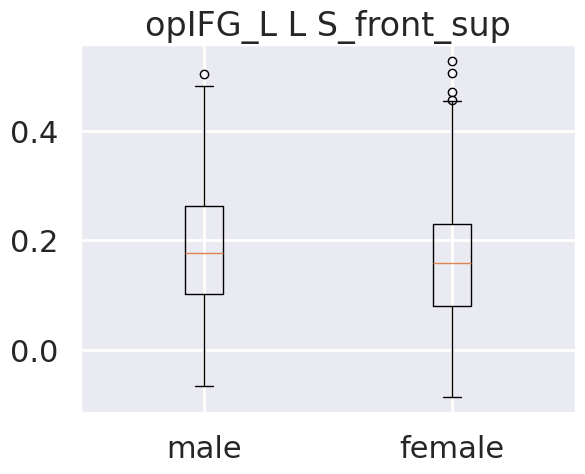

TtestResult(statistic=1.8386086382774387, pvalue=0.06664048715484525, df=444.0)
male mean : 0.18354724924686366
male std : 0.11555029853526483
female mean : 0.16325901403009732
female std : 0.11691880559681884


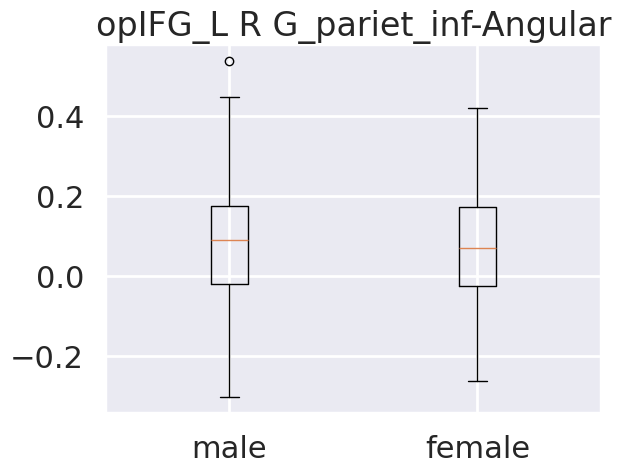

TtestResult(statistic=0.08591139105993699, pvalue=0.9315755833874969, df=444.0)
male mean : 0.07935426715545456
male std : 0.14282449297401265
female mean : 0.0782298258039823
female std : 0.13289471423540014


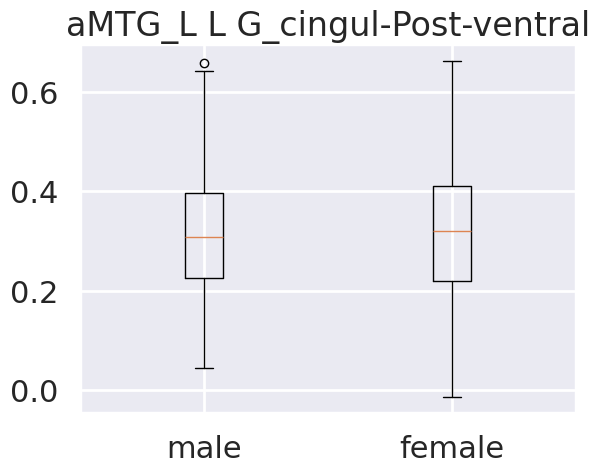

TtestResult(statistic=-0.2833432354183081, pvalue=0.7770458014163131, df=444.0)
male mean : 0.3156455165590909
male std : 0.12565269663262732
female mean : 0.3191625178451328
female std : 0.13555097899256496


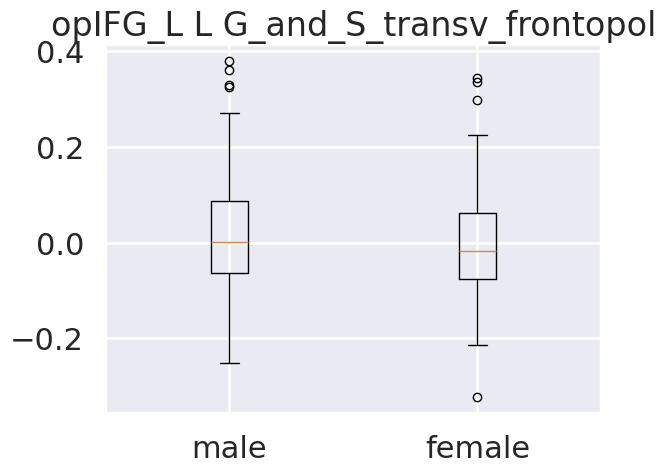

TtestResult(statistic=1.704073217878285, pvalue=0.08906705865566711, df=444.0)
male mean : 0.009279954413181817
male std : 0.11102207207238941
female mean : -0.00782524785345133
female std : 0.10034297686828818


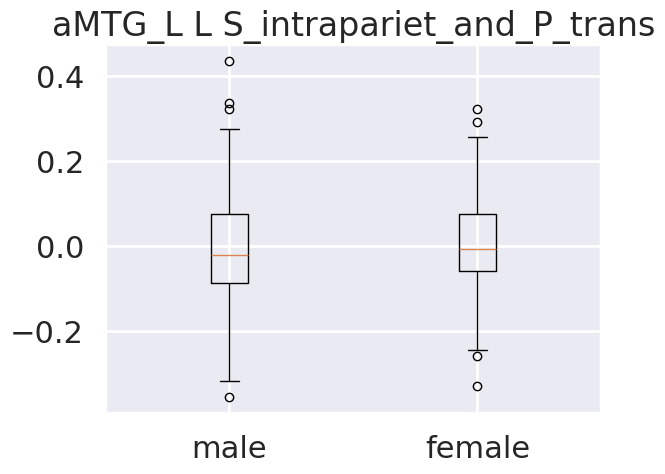

TtestResult(statistic=-0.5629449522849478, pvalue=0.5737565149961763, df=444.0)
male mean : -0.004352947120000001
male std : 0.11992515374089012
female mean : 0.0017103985353982307
female std : 0.10680532923333193


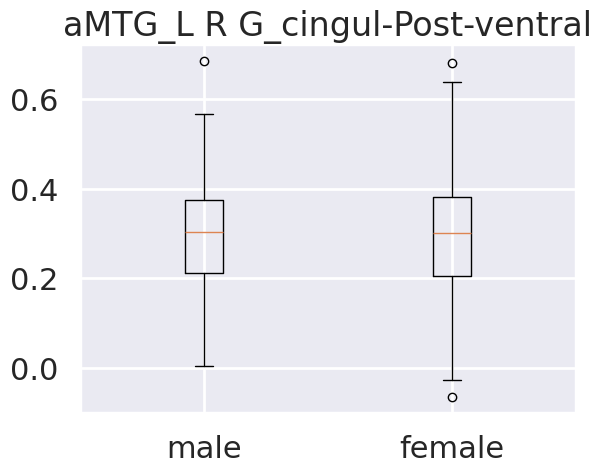

TtestResult(statistic=0.09577378814515201, pvalue=0.9237434466412748, df=444.0)
male mean : 0.2950557834072727
male std : 0.12408889141199957
female mean : 0.2938605092433628
female std : 0.13828653063453986


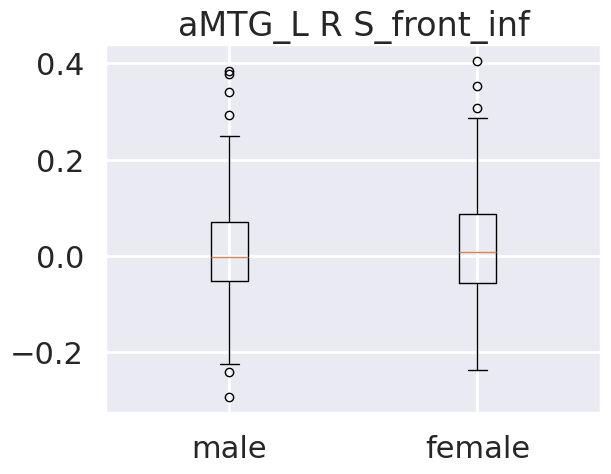

TtestResult(statistic=-1.0344019213226483, pvalue=0.3015113726056777, df=444.0)
male mean : 0.009040113515500001
male std : 0.11214850033551142
female mean : 0.020188220434349556
female std : 0.11487077247082961


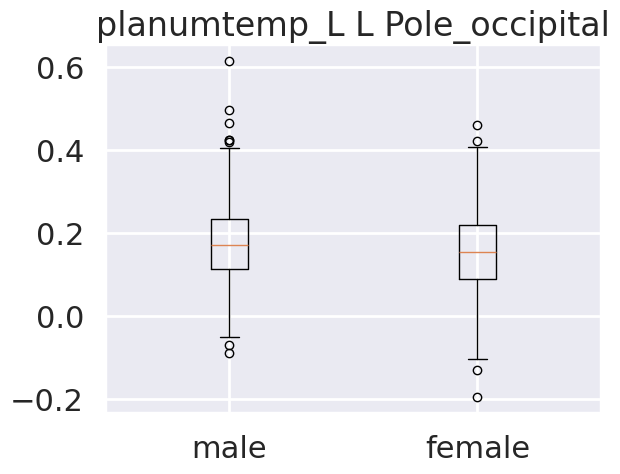

TtestResult(statistic=2.2141217874107335, pvalue=0.027327713783023296, df=444.0)
male mean : 0.18054933812954546
male std : 0.10858214699234862
female mean : 0.1579440344477876
female std : 0.10654581970600939


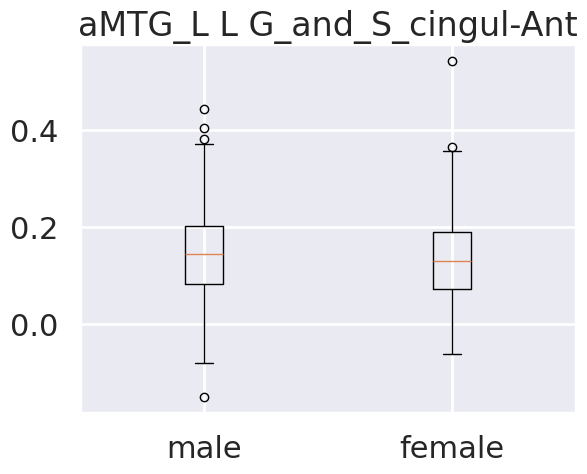

TtestResult(statistic=1.0085696367467436, pvalue=0.31373039303959355, df=444.0)
male mean : 0.14680708949227272
male std : 0.09418184209050703
female mean : 0.1380289428168142
female std : 0.08919625555912179


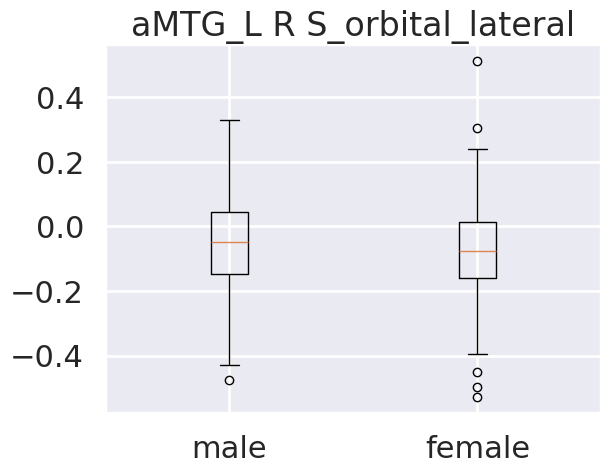

TtestResult(statistic=1.5922683491756897, pvalue=0.11203607391449234, df=444.0)
male mean : -0.05012122668031818
male std : 0.14338070010303233
female mean : -0.07177564318827433
female std : 0.14316029912268322
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [85]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)


## Best regions for aMTG_L

     coefficient    seed                       labels
53      0.281044  aMTG_L                L S_front_sup
98      0.250923  aMTG_L       R G_pariet_inf-Angular
131     0.183568  aMTG_L   R S_oc_sup_and_transversal
22      0.180551  aMTG_L      L G_oc-temp_med-Parahip
4       0.175986  aMTG_L   L G_and_S_transv_frontopol
104     0.173773  aMTG_L                   R G_rectus
103     0.168947  aMTG_L                R G_precuneus
55      0.166147  aMTG_L  L S_intrapariet_and_P_trans
66      0.158217  aMTG_L              L S_postcentral
87      0.149105  aMTG_L       R G_front_inf-Triangul
The mean accuracy : 0.8202100000000002
The standard deviation of the accuracy : 0.042053908363456245
The lower boundry of the confidance interval of the accuracy : 0.737784339607626
The upper boundry of the confidance interval of the accuracy : 0.9026356603923744
Mean sensitivity : 0.8154806899097619 Std sensitivity : 0.05005300041329873
Mean specificity : 0.8303861582136113 Std specificity : 0.05303873

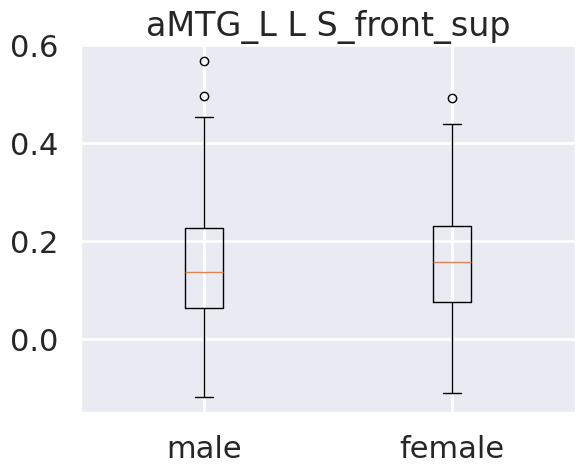

TtestResult(statistic=-1.2115802569709089, pvalue=0.2263175054541827, df=444.0)
male mean : 0.14762299317454547
male std : 0.11688015239448009
female mean : 0.16118036864971239
female std : 0.11884814329470475


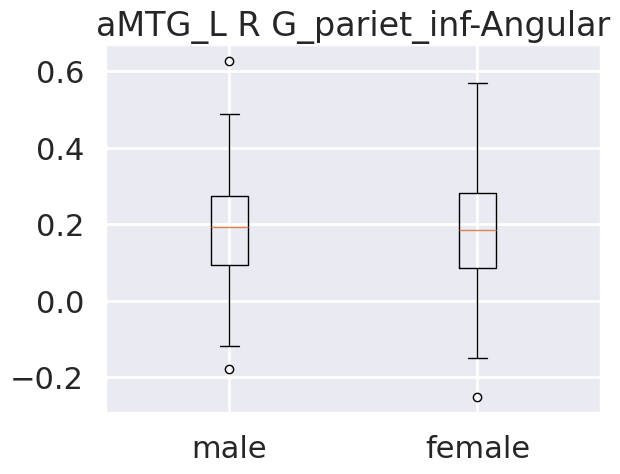

TtestResult(statistic=0.4179103500513543, pvalue=0.6762146978839937, df=444.0)
male mean : 0.18756429426727272
male std : 0.131036991296705
female mean : 0.18222123307212384
female std : 0.13814961112003438


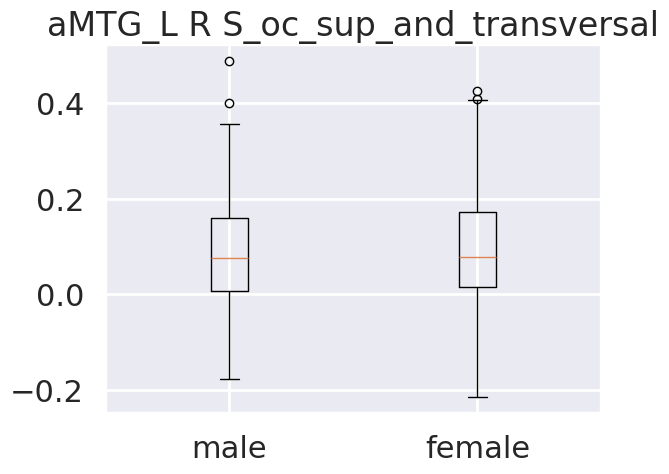

TtestResult(statistic=0.30474889772120906, pvalue=0.7607001988530268, df=444.0)
male mean : 0.08839870560527273
male std : 0.1147720441007127
female mean : 0.0850507582920354
female std : 0.1166615957346304


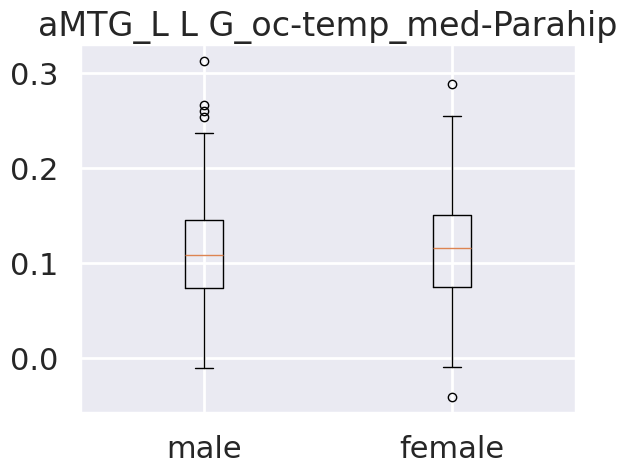

TtestResult(statistic=-0.5325288823497664, pvalue=0.5946261402922963, df=444.0)
male mean : 0.1132523153590909
male std : 0.05409661533112469
female mean : 0.11598545436725663
female std : 0.05404023663358572


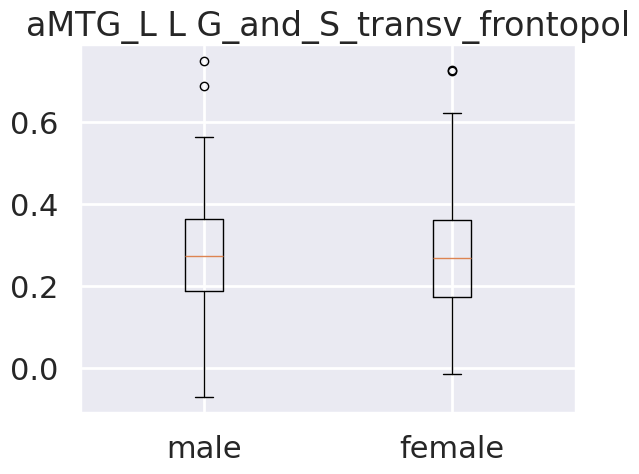

TtestResult(statistic=0.7144775913885814, pvalue=0.475307367024024, df=444.0)
male mean : 0.27915044829545455
male std : 0.13328978310271264
female mean : 0.270030732761062
female std : 0.135602632350119


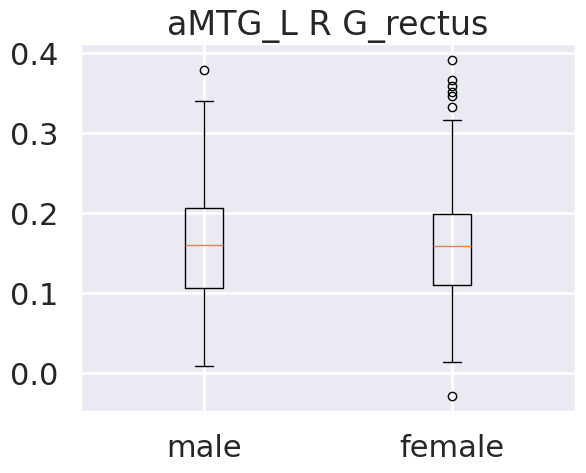

TtestResult(statistic=-0.10159549213792646, pvalue=0.9191236211037616, df=444.0)
male mean : 0.1603763383909091
male std : 0.0667838166130642
female mean : 0.16104586768141593
female std : 0.07190337437275575


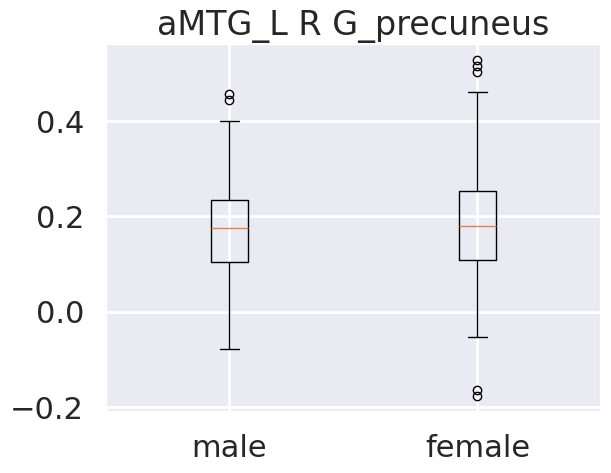

TtestResult(statistic=-0.40499262015766535, pvalue=0.6856779864063001, df=444.0)
male mean : 0.17628389293409089
male std : 0.10298397993898772
female mean : 0.18040916822566372
female std : 0.11135414180003657


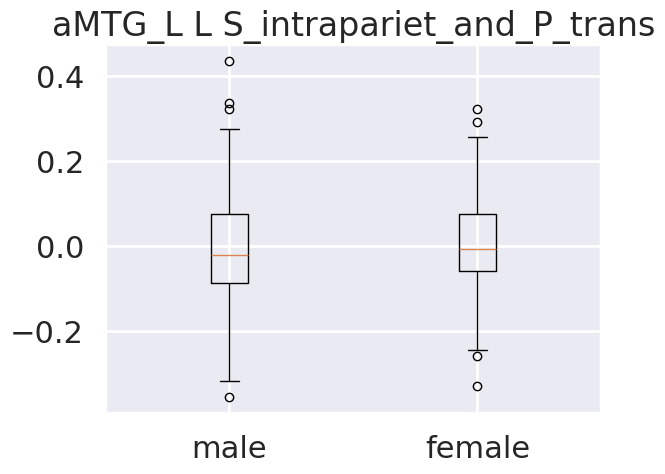

TtestResult(statistic=-0.5629449522849478, pvalue=0.5737565149961763, df=444.0)
male mean : -0.004352947120000001
male std : 0.11992515374089012
female mean : 0.0017103985353982307
female std : 0.10680532923333193


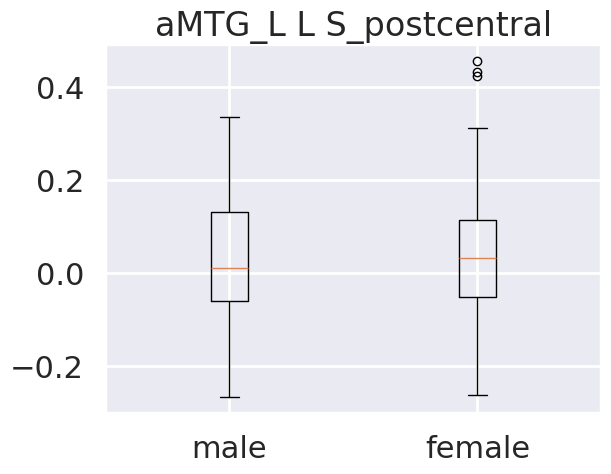

TtestResult(statistic=-0.8254630391644802, pvalue=0.40955205026428354, df=444.0)
male mean : 0.02505200850136364
male std : 0.13212586802743143
female mean : 0.0352003758540708
female std : 0.12692226875426213


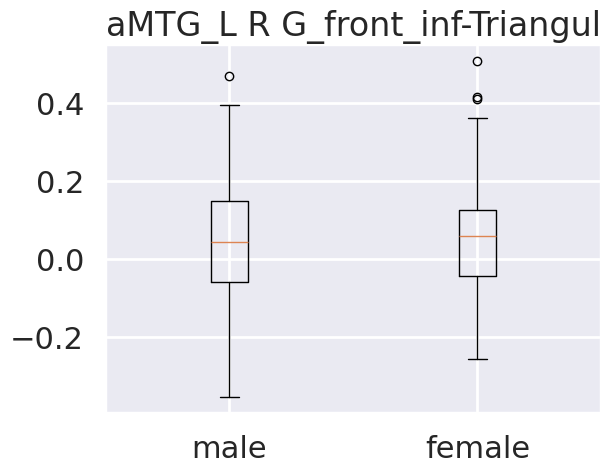

TtestResult(statistic=0.06586375044030267, pvalue=0.9475159463280065, df=444.0)
male mean : 0.049219128189999996
male std : 0.14446793573936256
female mean : 0.04835148825929204
female std : 0.13300199426574477
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [87]:
rois = ["aMTG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions aMTG_R

     coefficient    seed                       labels
66      0.235741  aMTG_R              L S_postcentral
53      0.235184  aMTG_R                L S_front_sup
22      0.215506  aMTG_R      L G_oc-temp_med-Parahip
98      0.214273  aMTG_R       R G_pariet_inf-Angular
55      0.196734  aMTG_R  L S_intrapariet_and_P_trans
96      0.173958  aMTG_R      R G_oc-temp_med-Parahip
4       0.162914  aMTG_R   L G_and_S_transv_frontopol
77      0.149204  aMTG_R         R G_and_S_subcentral
131     0.146683  aMTG_R   R S_oc_sup_and_transversal
90      0.130523  aMTG_R    R G_Ins_lg_and_S_cent_ins
The mean accuracy : 0.8109111111111114
The standard deviation of the accuracy : 0.043558497633061015
The lower boundry of the confidance interval of the accuracy : 0.7255364557503118
The upper boundry of the confidance interval of the accuracy : 0.8962857664719109
Mean sensitivity : 0.8088480095877181 Std sensitivity : 0.051696829941751885
Mean specificity : 0.818307480321062 Std specificity : 0.0536930

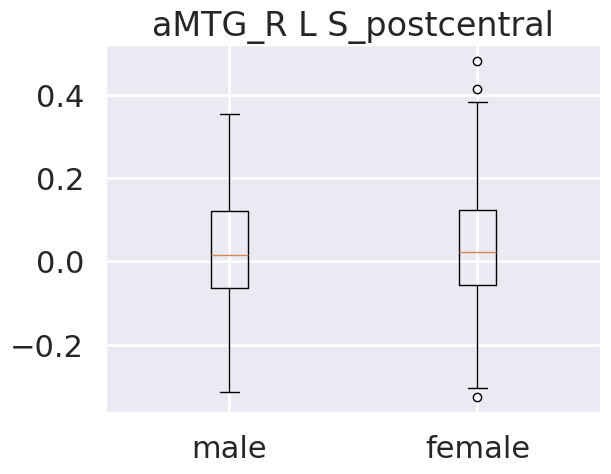

TtestResult(statistic=-1.1640513741205991, pvalue=0.24502831161092486, df=444.0)
male mean : 0.024869018984999998
male std : 0.13083791553890814
female mean : 0.03956135003526549
female std : 0.1350054527718372


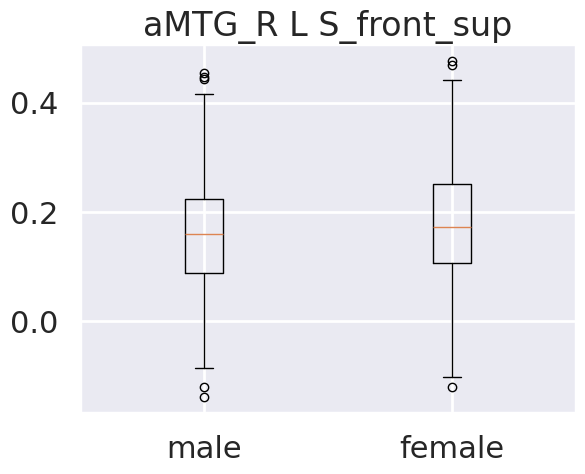

TtestResult(statistic=-1.5664583130918401, pvalue=0.11795375882200275, df=444.0)
male mean : 0.1639319401981364
male std : 0.1082806698802484
female mean : 0.18019807714026548
female std : 0.11046417292654283


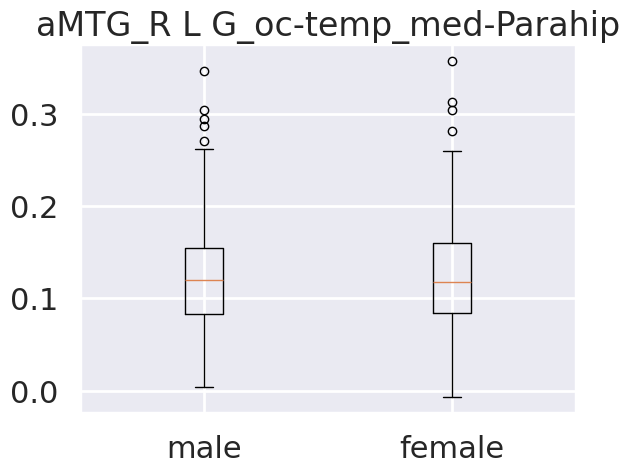

TtestResult(statistic=0.236157422237291, pvalue=0.8134194177992647, df=444.0)
male mean : 0.12669131177454543
male std : 0.05789178132233646
female mean : 0.12539075617035397
female std : 0.05813712078976924


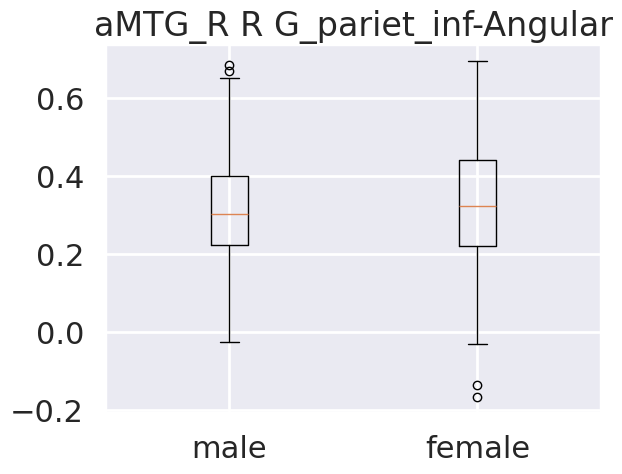

TtestResult(statistic=-0.4232827448696727, pvalue=0.6722939356579549, df=444.0)
male mean : 0.3142547134304546
male std : 0.13922671906337197
female mean : 0.32020972021548666
female std : 0.156457832134548


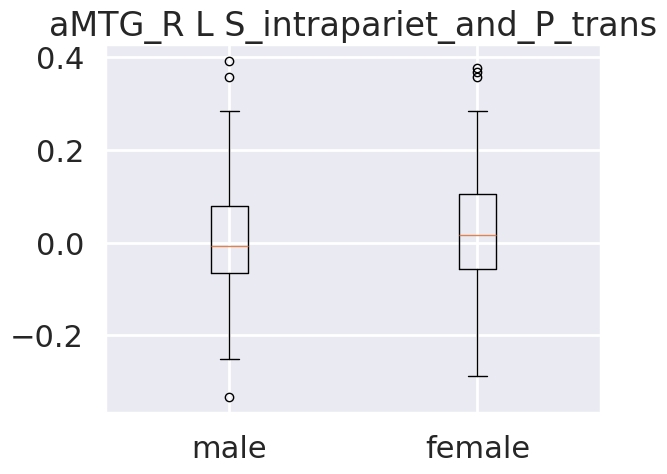

TtestResult(statistic=-1.409706247156657, pvalue=0.1593265024127508, df=444.0)
male mean : 0.0051525473381363604
male std : 0.11358963099658818
female mean : 0.020574686161504426
female std : 0.1168422000095749


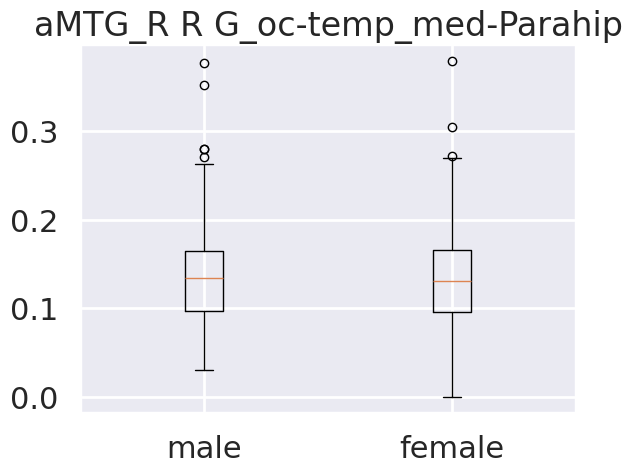

TtestResult(statistic=0.38349633258891414, pvalue=0.7015353473449857, df=444.0)
male mean : 0.13827192803636365
male std : 0.056839411334303425
female mean : 0.13617762669402655
female std : 0.05819587400842339


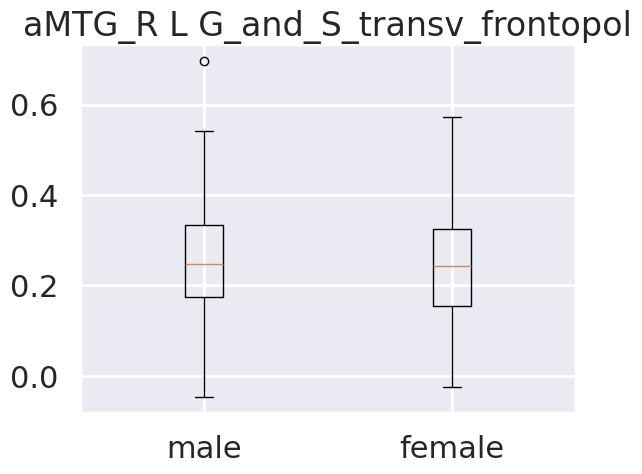

TtestResult(statistic=0.5337028010794159, pvalue=0.59381424809252, df=444.0)
male mean : 0.25033558718590904
male std : 0.1176572351734413
female mean : 0.24428394915265486
female std : 0.12117477403861707


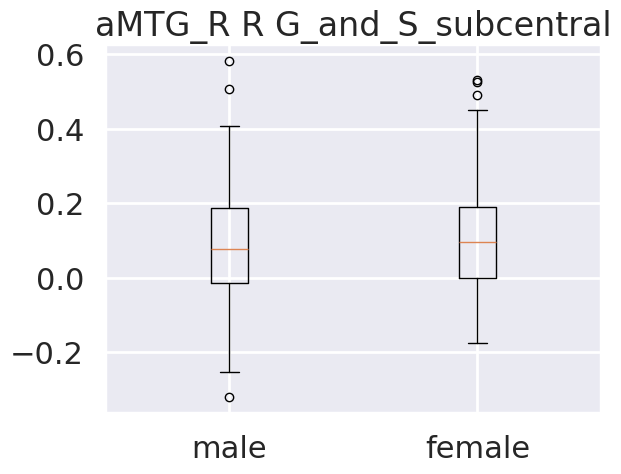

TtestResult(statistic=-1.2532252660322003, pvalue=0.21078328908154395, df=444.0)
male mean : 0.08824721561363635
male std : 0.14095604045910376
female mean : 0.10516873683029646
female std : 0.14348569460343674


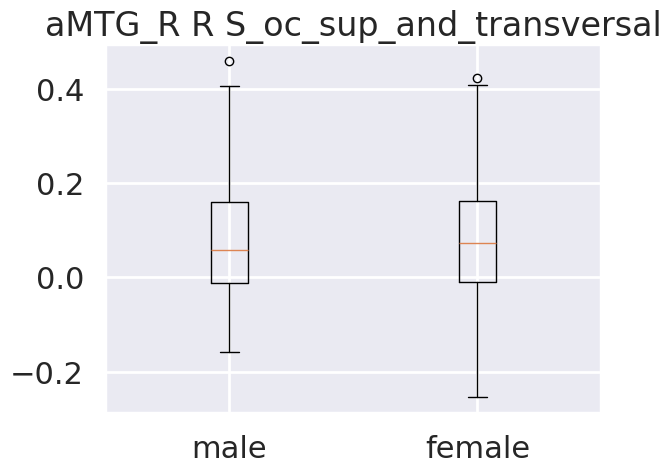

TtestResult(statistic=-0.6816141722659632, pvalue=0.49583832530371075, df=444.0)
male mean : 0.0746124765559091
male std : 0.11744129351142867
female mean : 0.08266218956327434
female std : 0.13084232907159066


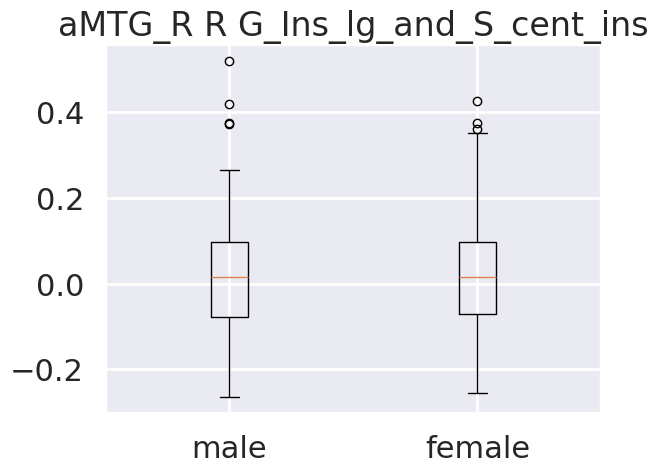

TtestResult(statistic=-0.22044697190158885, pvalue=0.825624394898167, df=444.0)
male mean : 0.01688882336909091
male std : 0.1271698366083748
female mean : 0.019493625555884957
female std : 0.12180061152102561
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [88]:
rois = ["aMTG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_L

     coefficient     seed                       labels
125     0.202689  opIFG_L                R S_front_inf
20      0.200376  opIFG_L      L G_oc-temp_lat-fusifor
35      0.190572  opIFG_L      L G_temp_sup-Plan_tempo
144     0.189744  opIFG_L              R S_subparietal
91      0.188180  opIFG_L            R G_insular_short
79      0.158492  opIFG_L         R G_and_S_cingul-Ant
60      0.157379  opIFG_L  L S_oc-temp_med_and_Lingual
89      0.151293  opIFG_L                R G_front_sup
72      0.150238  opIFG_L             L S_temporal_sup
9       0.147801  opIFG_L      L G_cingul-Post-ventral
The mean accuracy : 0.8472244444444444
The standard deviation of the accuracy : 0.03985312534795734
The lower boundry of the confidance interval of the accuracy : 0.769112318762448
The upper boundry of the confidance interval of the accuracy : 0.9253365701264409
Mean sensitivity : 0.8420658930947892 Std sensitivity : 0.04859285455967222
Mean specificity : 0.857698111507087 Std specificity : 0

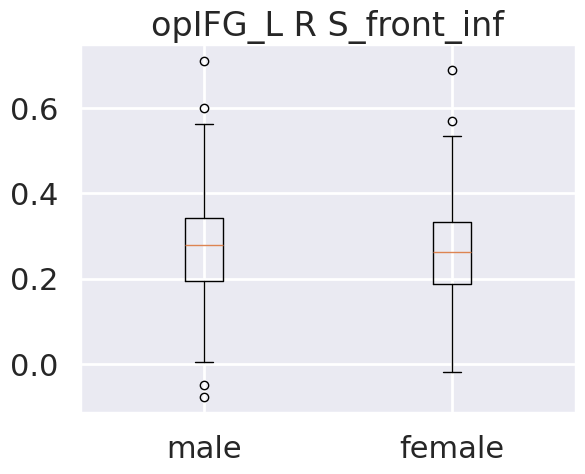

TtestResult(statistic=0.4915695057620733, pvalue=0.6232666210046246, df=444.0)
male mean : 0.26700118899545455
male std : 0.11830244448245875
female mean : 0.26163575809292033
female std : 0.11166135854260843


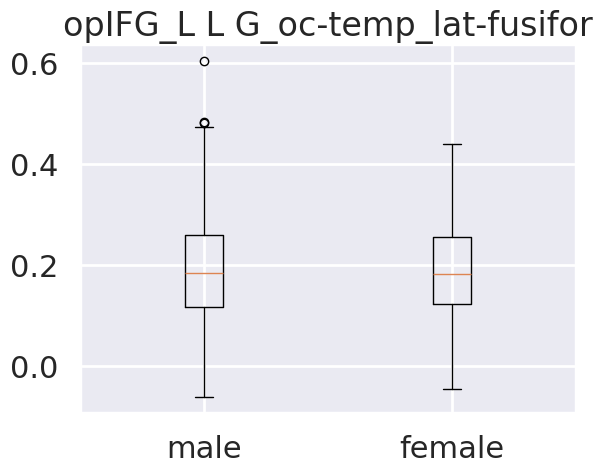

TtestResult(statistic=0.5192015204184673, pvalue=0.6038789204517058, df=444.0)
male mean : 0.1940983459488636
male std : 0.11200001469732601
female mean : 0.18902279729823013
female std : 0.09337458622335229


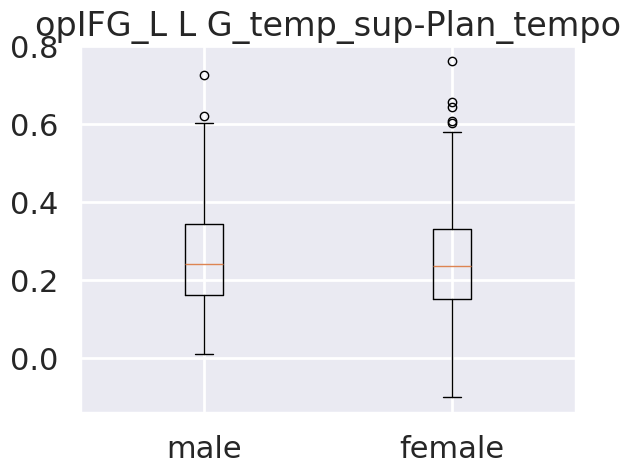

TtestResult(statistic=0.6213060288834897, pvalue=0.5347171316983141, df=444.0)
male mean : 0.2601838246818182
male std : 0.13041436272465887
female mean : 0.25200619504867255
female std : 0.14623656983715244


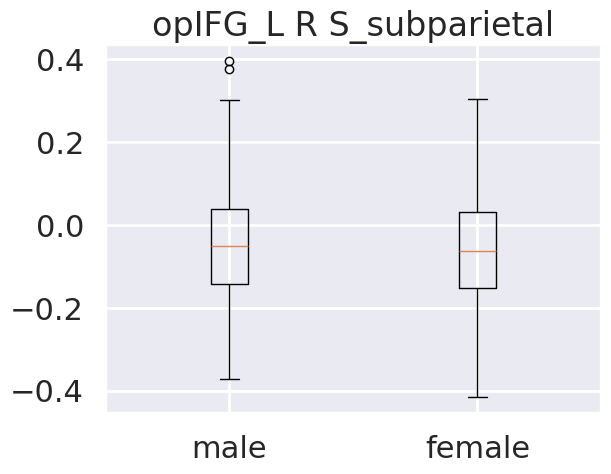

TtestResult(statistic=1.7391634132444183, pvalue=0.08269908820236846, df=444.0)
male mean : -0.04258604435452273
male std : 0.13898561840228374
female mean : -0.06453867240132743
female std : 0.1268496208152823


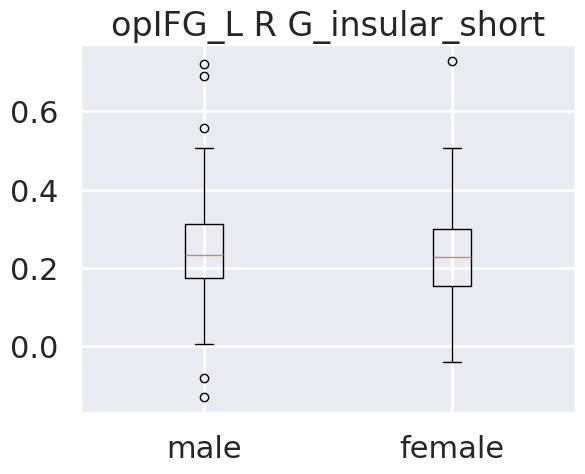

TtestResult(statistic=0.9067239038419802, pvalue=0.36504463339847837, df=444.0)
male mean : 0.24628885791363642
male std : 0.11709590021523666
female mean : 0.23638866999115044
female std : 0.11297172669965401


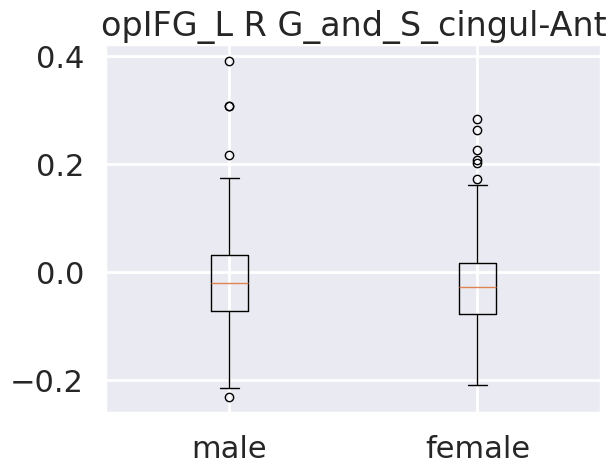

TtestResult(statistic=0.9352934369587438, pvalue=0.35014549704521825, df=444.0)
male mean : -0.01618588559709091
male std : 0.08989493115128637
female mean : -0.023699539482654866
female std : 0.07916971759856868


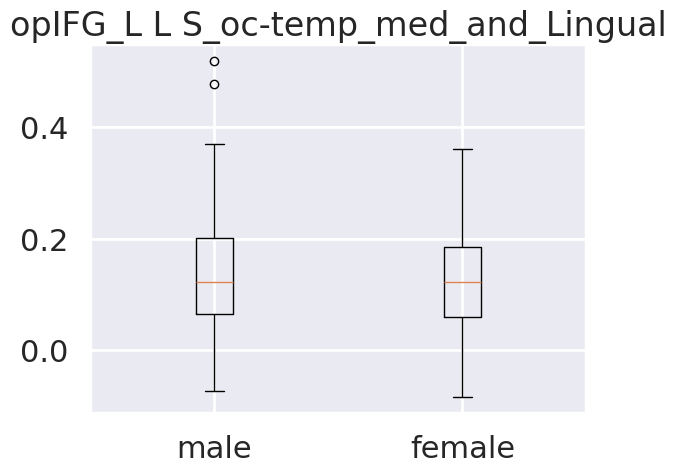

TtestResult(statistic=0.8482871359411982, pvalue=0.3967351597135216, df=444.0)
male mean : 0.13462001977722726
male std : 0.09808758650556429
female mean : 0.1272581053141593
female std : 0.0844381182747298


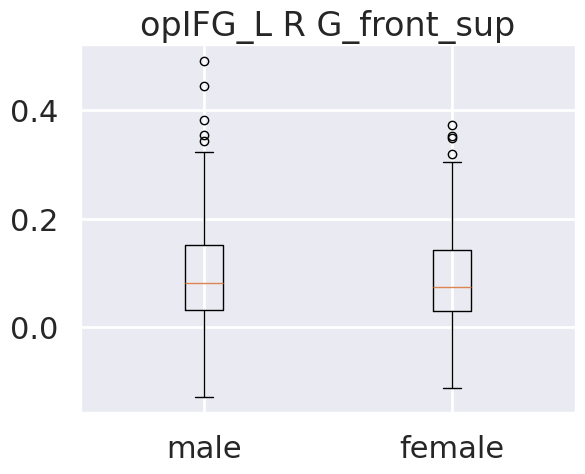

TtestResult(statistic=1.1915595985799283, pvalue=0.23407051044287677, df=444.0)
male mean : 0.09908702246555909
male std : 0.09748109702477784
female mean : 0.08866071840106193
female std : 0.08670894152437802


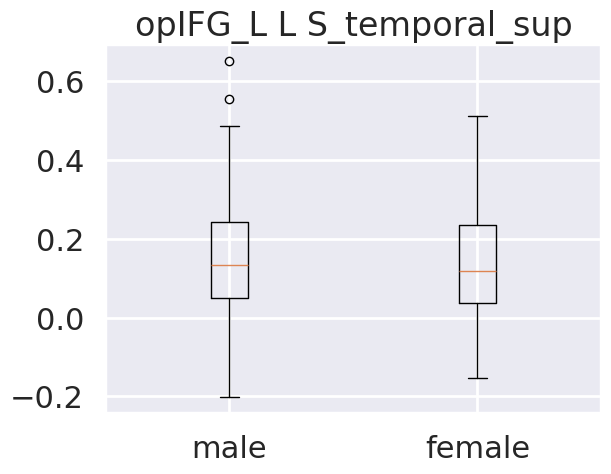

TtestResult(statistic=0.7755817266065361, pvalue=0.4384088867429513, df=444.0)
male mean : 0.15023836449931818
male std : 0.13752547518252983
female mean : 0.14016238799115044
female std : 0.13621233667136962


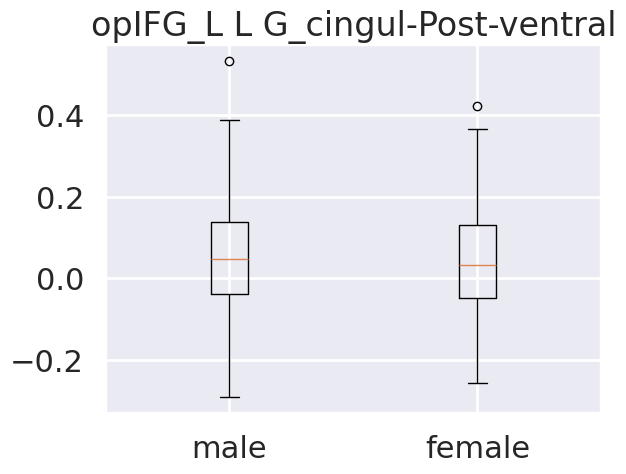

TtestResult(statistic=0.7310977037783218, pvalue=0.4651051172517302, df=444.0)
male mean : 0.05370966553863637
male std : 0.13821620868703405
female mean : 0.04442369016349557
female std : 0.129367732267586
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [89]:
rois = ["opIFG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions opIFG_R

     coefficient     seed                       labels
125     0.234703  opIFG_R                R S_front_inf
80      0.224280  opIFG_R     R G_and_S_cingul-Mid-Ant
91      0.181864  opIFG_R            R G_insular_short
144     0.168338  opIFG_R              R S_subparietal
20      0.165930  opIFG_R      L G_oc-temp_lat-fusifor
90      0.165617  opIFG_R    R G_Ins_lg_and_S_cent_ins
41      0.161333  opIFG_R             L Pole_occipital
117     0.152971  opIFG_R                R S_calcarine
63      0.152894  opIFG_R         L S_orbital-H_Shaped
60      0.151867  opIFG_R  L S_oc-temp_med_and_Lingual
The mean accuracy : 0.8309533333333334
The standard deviation of the accuracy : 0.04169986582564197
The lower boundry of the confidance interval of the accuracy : 0.7492215963150752
The upper boundry of the confidance interval of the accuracy : 0.9126850703515916
Mean sensitivity : 0.8322554230578544 Std sensitivity : 0.050887627795741186
Mean specificity : 0.8347027848251469 Std specificity 

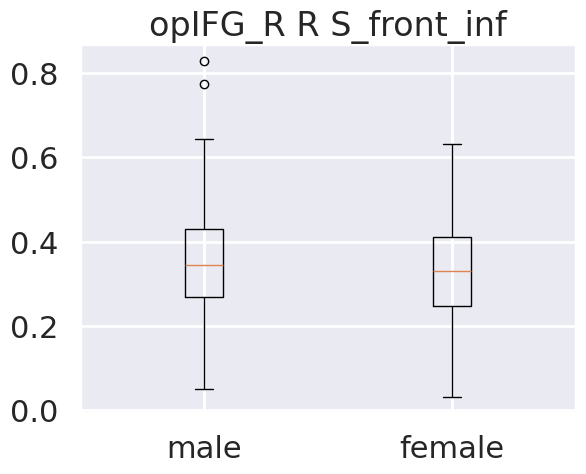

TtestResult(statistic=1.677478419338587, pvalue=0.0941527311664062, df=444.0)
male mean : 0.3493236941545455
male std : 0.12594814592383247
female mean : 0.33014065035840706
female std : 0.1148888720611889


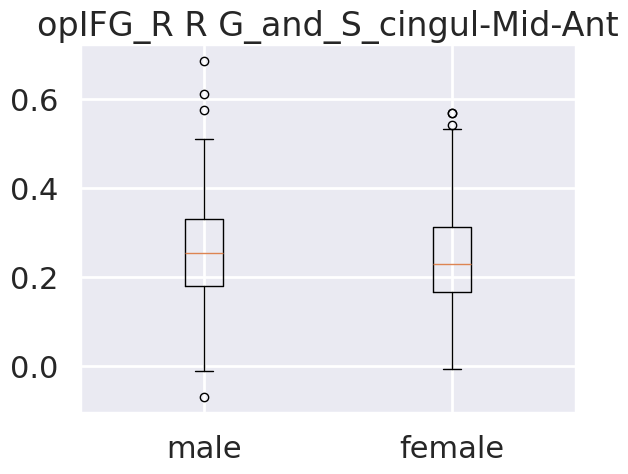

TtestResult(statistic=1.4220769007548189, pvalue=0.15570601664653622, df=444.0)
male mean : 0.26201838397727273
male std : 0.11680459863257632
female mean : 0.2463068751438053
female std : 0.11598569074736187


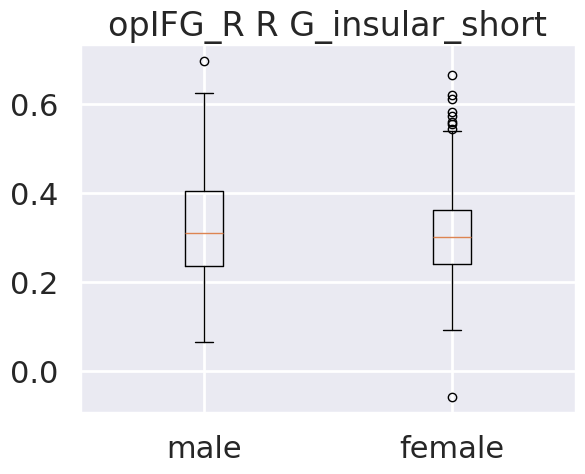

TtestResult(statistic=1.1876450875867164, pvalue=0.2356082192599735, df=444.0)
male mean : 0.3226060065636363
male std : 0.11264272452127146
female mean : 0.3099531391858407
female std : 0.11183470415014414


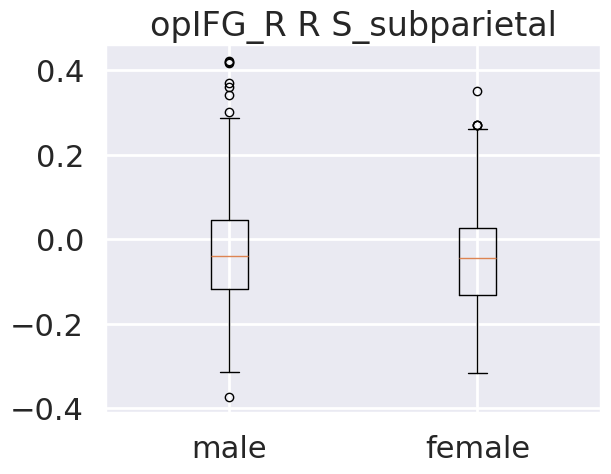

TtestResult(statistic=1.4280992707788773, pvalue=0.1539662979049357, df=444.0)
male mean : -0.02669799280472727
male std : 0.13997954487219721
female mean : -0.04441074100570796
female std : 0.12090433979084553


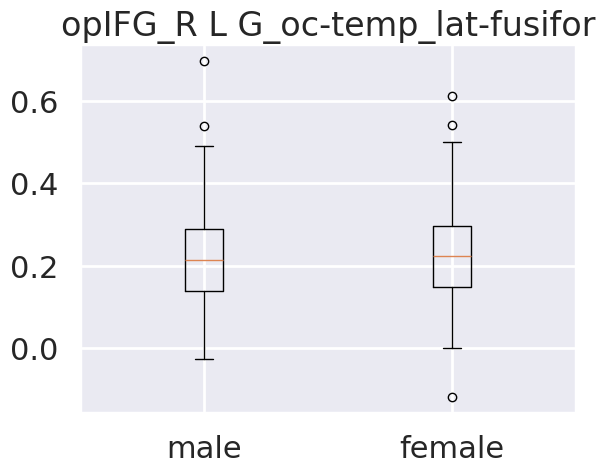

TtestResult(statistic=-0.9901442067517153, pvalue=0.3226429184512092, df=444.0)
male mean : 0.21643367910909092
male std : 0.1098183379873906
female mean : 0.2264770848318584
female std : 0.10389411762066779


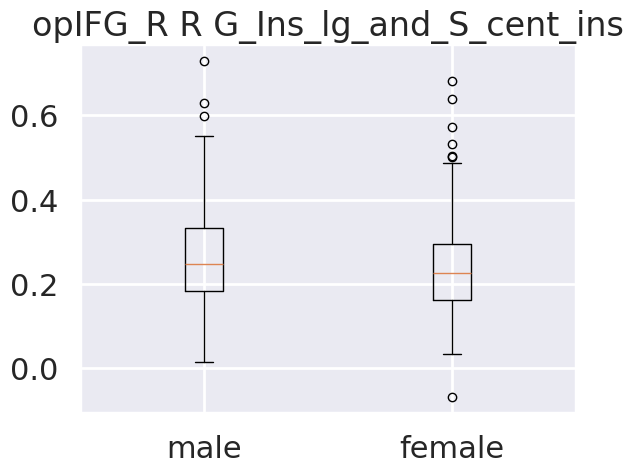

TtestResult(statistic=1.5032319765907831, pvalue=0.13349015197916975, df=444.0)
male mean : 0.2560846500727273
male std : 0.11677802001475575
female mean : 0.23962584481415927
female std : 0.11393043911461521


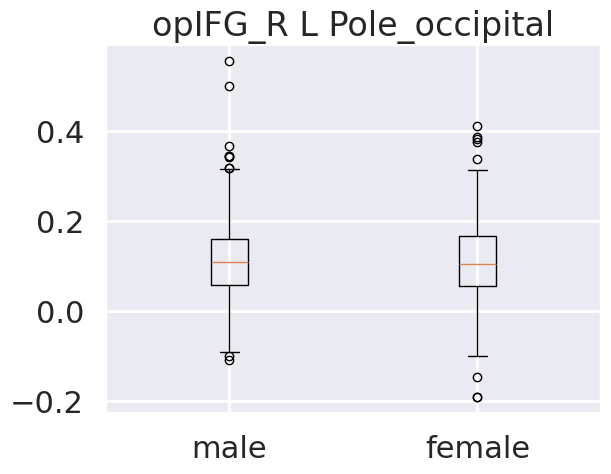

TtestResult(statistic=0.7247810761382535, pvalue=0.4689681169166011, df=444.0)
male mean : 0.1170176840959091
male std : 0.09457281950712053
female mean : 0.11049183997579647
female std : 0.09512536430262356


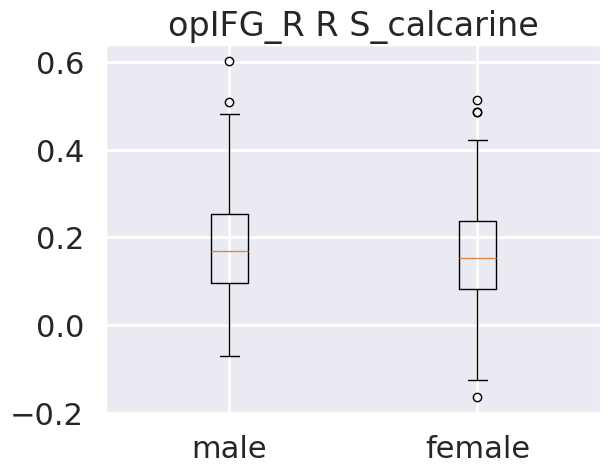

TtestResult(statistic=0.9747216383281959, pvalue=0.3302290972981793, df=444.0)
male mean : 0.1753950030236364
male std : 0.11110288916927817
female mean : 0.1652581727544248
female std : 0.10803273494292392


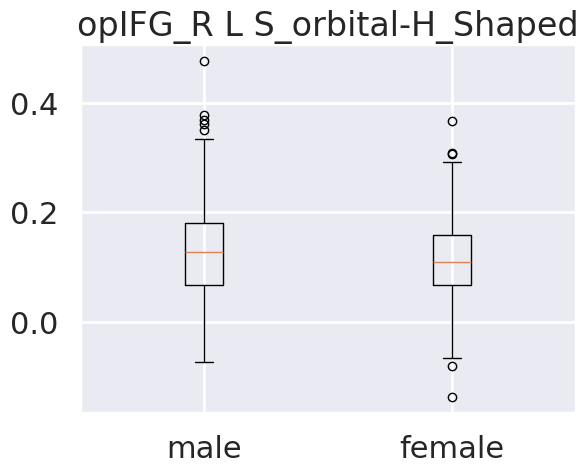

TtestResult(statistic=2.0532652593810847, pvalue=0.04063217634906046, df=444.0)
male mean : 0.12819354256818183
male std : 0.08764783205257284
female mean : 0.11203503897743362
female std : 0.07801062367094556


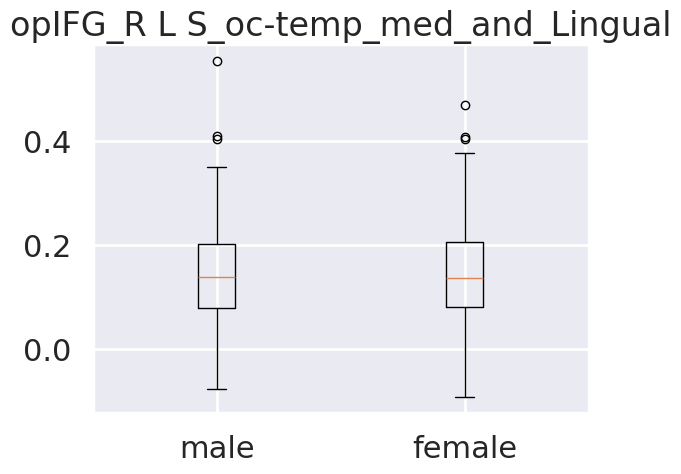

TtestResult(statistic=-0.360244458914998, pvalue=0.7188356351459093, df=444.0)
male mean : 0.1422618793368182
male std : 0.094818195761141
female mean : 0.14546593415398232
female std : 0.09259215543692742
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [90]:
rois = ["opIFG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions pITG_L

     coefficient    seed                       labels
26      0.258569  pITG_L             L G_parietal_sup
125     0.251404  pITG_L                R S_front_inf
9       0.229381  pITG_L      L G_cingul-Post-ventral
73      0.196164  pITG_L      L S_temporal_transverse
20      0.178793  pITG_L      L G_oc-temp_lat-fusifor
75      0.174681  pITG_L      R G_and_S_occipital_inf
83      0.170141  pITG_L      R G_cingul-Post-ventral
55      0.161171  pITG_L  L S_intrapariet_and_P_trans
135     0.149312  pITG_L          R S_orbital_lateral
4       0.145410  pITG_L   L G_and_S_transv_frontopol
The mean accuracy : 0.8340655555555557
The standard deviation of the accuracy : 0.04090814339830513
The lower boundry of the confidance interval of the accuracy : 0.7538855944948777
The upper boundry of the confidance interval of the accuracy : 0.9142455166162338
Mean sensitivity : 0.8368868824147409 Std sensitivity : 0.04986718307660728
Mean specificity : 0.8359144147978517 Std specificity : 0.05096994

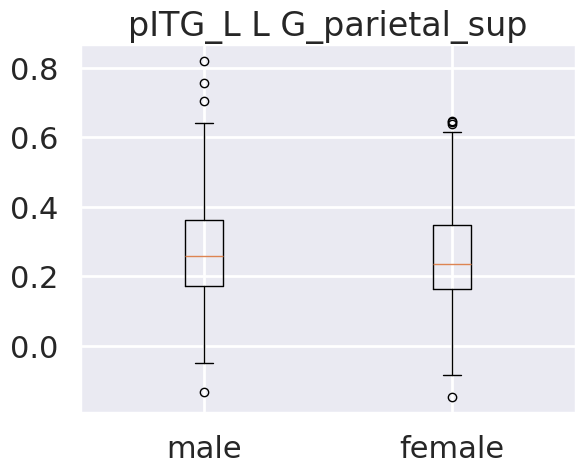

TtestResult(statistic=1.2775594744972645, pvalue=0.20207239044999334, df=444.0)
male mean : 0.26957147712954543
male std : 0.15651594183037884
female mean : 0.2514996581647345
female std : 0.14134056453004967


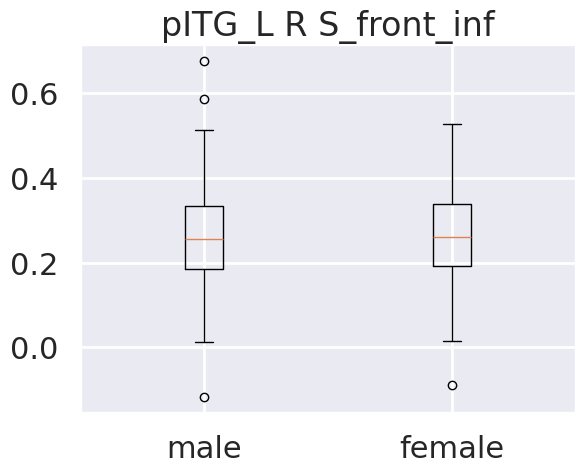

TtestResult(statistic=-0.3898606326263292, pvalue=0.6968265500966664, df=444.0)
male mean : 0.26279526316363633
male std : 0.11384920271212329
female mean : 0.26681815073893805
female std : 0.10345257020535056


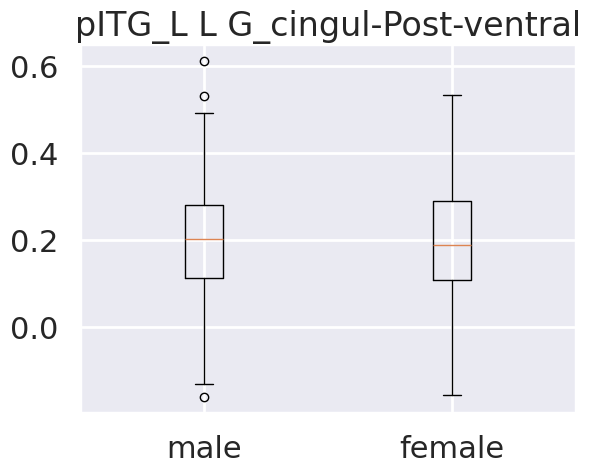

TtestResult(statistic=0.2660541577516194, pvalue=0.7903210003797976, df=444.0)
male mean : 0.20205080604545456
male std : 0.12422614125501692
female mean : 0.19888707633584068
female std : 0.1262803600581341


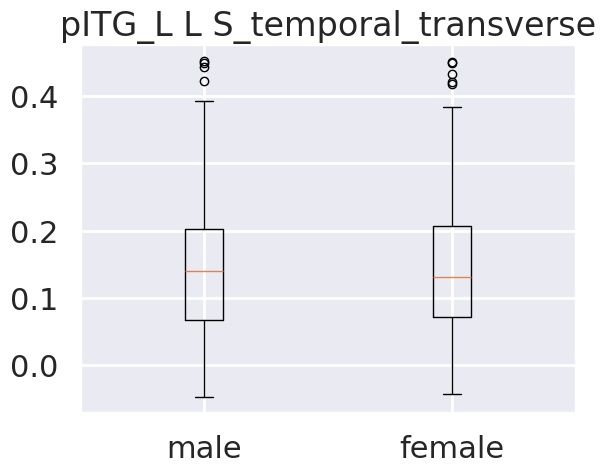

TtestResult(statistic=-0.005337239038893681, pvalue=0.9957439167530718, df=444.0)
male mean : 0.14612400199772727
male std : 0.10120385211558387
female mean : 0.14617460060132745
female std : 0.09855836662586634


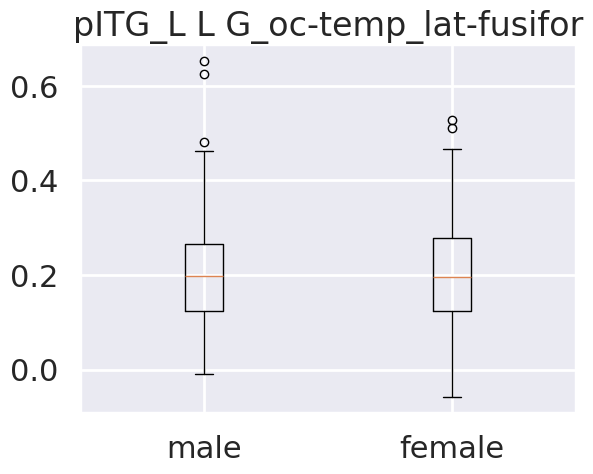

TtestResult(statistic=-0.3523231328642132, pvalue=0.724763114132243, df=444.0)
male mean : 0.19990744190772727
male std : 0.10649609252080425
female mean : 0.20348736029646017
female std : 0.10757072354747603


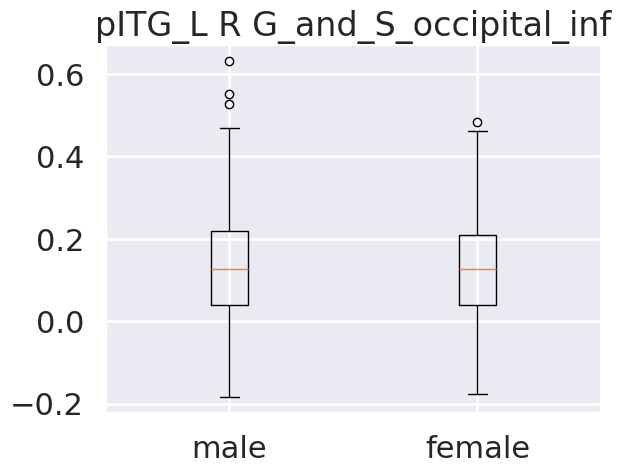

TtestResult(statistic=0.001970963289310874, pvalue=0.9984282850650938, df=444.0)
male mean : 0.13228784757036363
male std : 0.134596850044891
female mean : 0.13226327636283183
female std : 0.1280736610401677


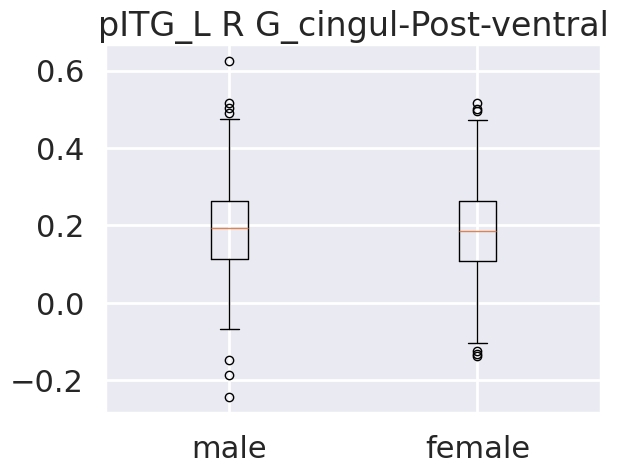

TtestResult(statistic=0.1294323294585559, pvalue=0.8970741805394739, df=444.0)
male mean : 0.18757393837099998
male std : 0.12519042209193637
female mean : 0.18603045791150444
female std : 0.12604914997701686


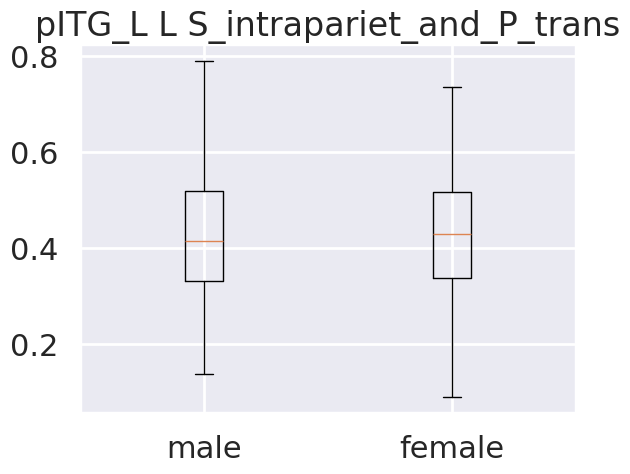

TtestResult(statistic=0.15169777175234894, pvalue=0.8794942172965604, df=444.0)
male mean : 0.42759644404545455
male std : 0.1302837656549137
female mean : 0.42571565088938057
female std : 0.130931286829129


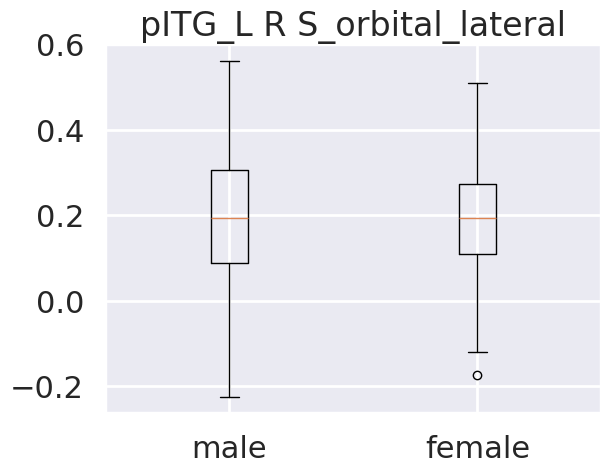

TtestResult(statistic=0.8149138002743364, pvalue=0.41555854201489295, df=444.0)
male mean : 0.19726935004318183
male std : 0.15445023561216564
female mean : 0.18631764366384954
female std : 0.1278057829390902


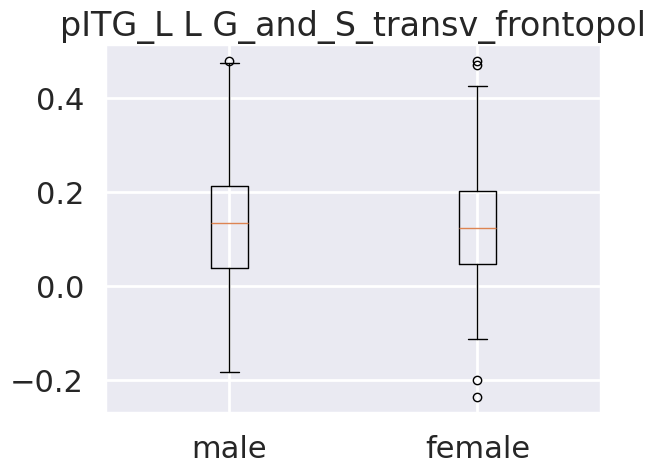

TtestResult(statistic=0.46036528274534155, pvalue=0.6454794277195661, df=444.0)
male mean : 0.13329592038227273
male std : 0.11925893213609366
female mean : 0.12810292579955754
female std : 0.11841713705097008
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [91]:
rois = ["pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions pITG_R

     coefficient    seed                    labels
20      0.317350  pITG_R   L G_oc-temp_lat-fusifor
83      0.207225  pITG_R   R G_cingul-Post-ventral
91      0.203452  pITG_R         R G_insular_short
84      0.195611  pITG_R                R G_cuneus
125     0.194242  pITG_R             R S_front_inf
72      0.162033  pITG_R          L S_temporal_sup
80      0.158161  pITG_R  R G_and_S_cingul-Mid-Ant
32      0.146301  pITG_R   L G_temp_sup-G_T_transv
144     0.142211  pITG_R           R S_subparietal
19      0.136236  pITG_R         L G_occipital_sup
The mean accuracy : 0.8087766666666668
The standard deviation of the accuracy : 0.04366703136686832
The lower boundry of the confidance interval of the accuracy : 0.723189285187605
The upper boundry of the confidance interval of the accuracy : 0.8943640481457287
Mean sensitivity : 0.8030865538507487 Std sensitivity : 0.05111756646867676
Mean specificity : 0.8199458184890595 Std specificity : 0.05372855203856655


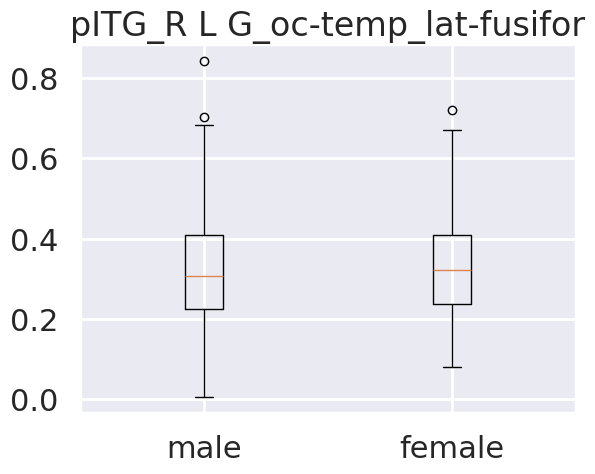

TtestResult(statistic=0.05559392250265574, pvalue=0.9556903136777086, df=444.0)
male mean : 0.3245795496704546
male std : 0.1395229674314357
female mean : 0.3238852111902655
female std : 0.12334245836892097


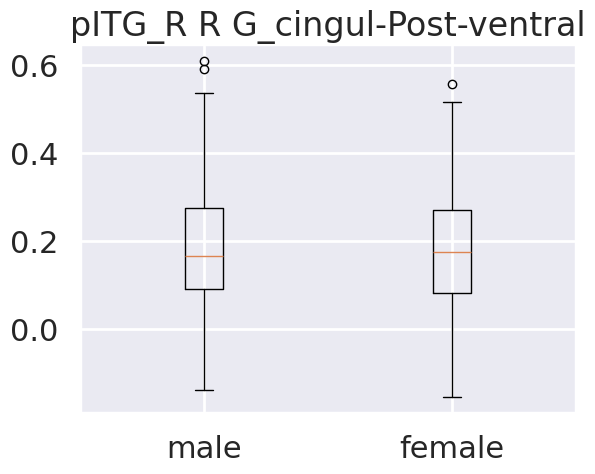

TtestResult(statistic=0.785990140622887, pvalue=0.43229252128733386, df=444.0)
male mean : 0.18269896478363637
male std : 0.14035311890865013
female mean : 0.17262970177920356
female std : 0.1294930282265483


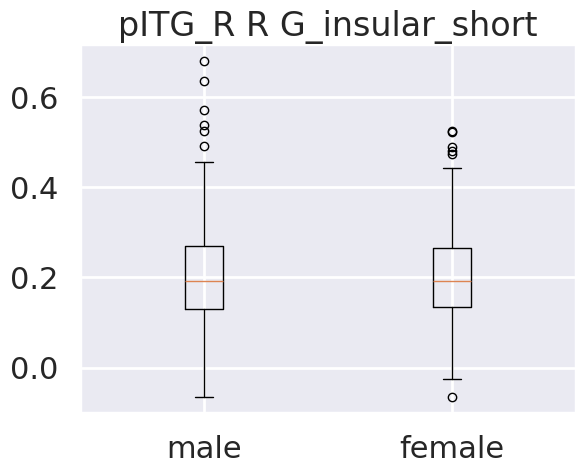

TtestResult(statistic=0.8163020504977502, pvalue=0.4147651343472084, df=444.0)
male mean : 0.2093050060027273
male std : 0.11681287896829293
female mean : 0.20074869443893806
female std : 0.1038248281853224


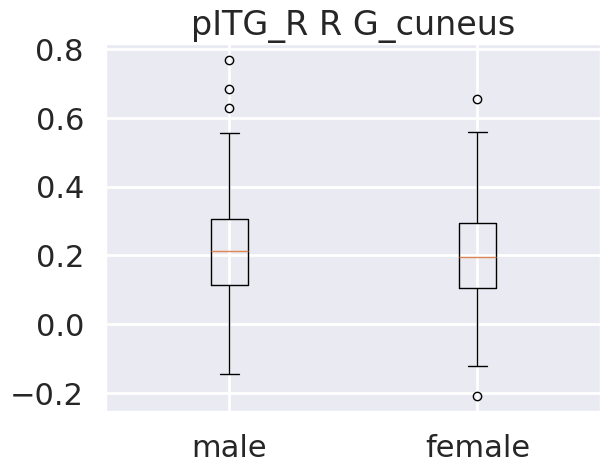

TtestResult(statistic=1.3083005997969617, pvalue=0.19144823693347288, df=444.0)
male mean : 0.21826787766727268
male std : 0.15102719800260528
female mean : 0.20021428982522121
female std : 0.1396453522401376


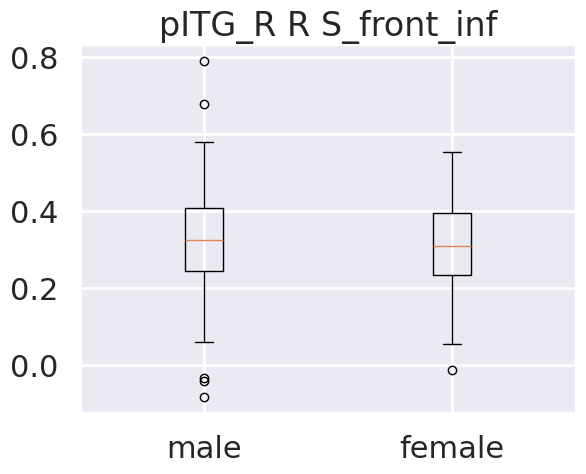

TtestResult(statistic=0.9656486526414011, pvalue=0.33474568366703705, df=444.0)
male mean : 0.32347226276818175
male std : 0.12120613574129573
female mean : 0.31306270038053097
female std : 0.10559196989800743


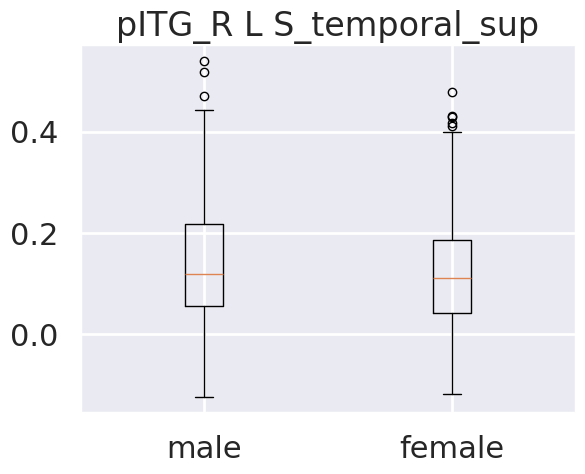

TtestResult(statistic=1.5050070186703721, pvalue=0.13303329591953397, df=444.0)
male mean : 0.13899118274863637
male std : 0.12237326089783937
female mean : 0.12194715708252213
female std : 0.11623887033473576


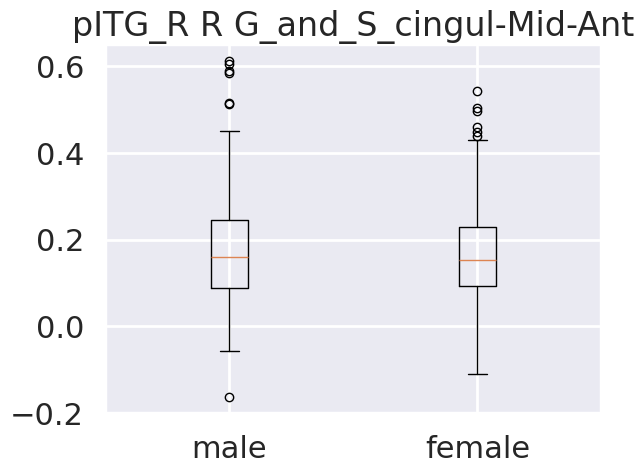

TtestResult(statistic=1.0558101625802878, pvalue=0.2916291029448552, df=444.0)
male mean : 0.17737232453545454
male std : 0.12719566858702955
female mean : 0.16530410570309734
female std : 0.11342504272797906


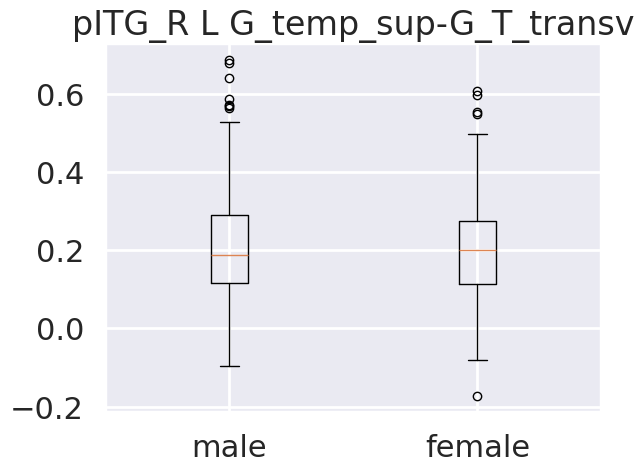

TtestResult(statistic=1.1334980599891324, pvalue=0.25761682087791904, df=444.0)
male mean : 0.21854762269136363
male std : 0.1406931484250914
female mean : 0.20409741841460177
female std : 0.12776928694525597


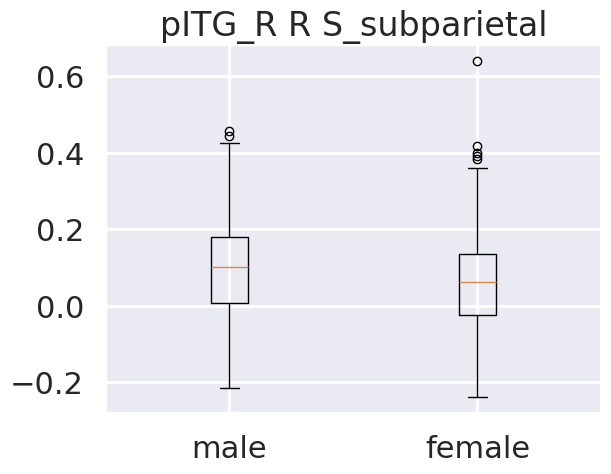

TtestResult(statistic=2.738549534420275, pvalue=0.006419310696767007, df=444.0)
male mean : 0.09850868294845455
male std : 0.13066100232363725
female mean : 0.06406320555544248
female std : 0.13427662772014276


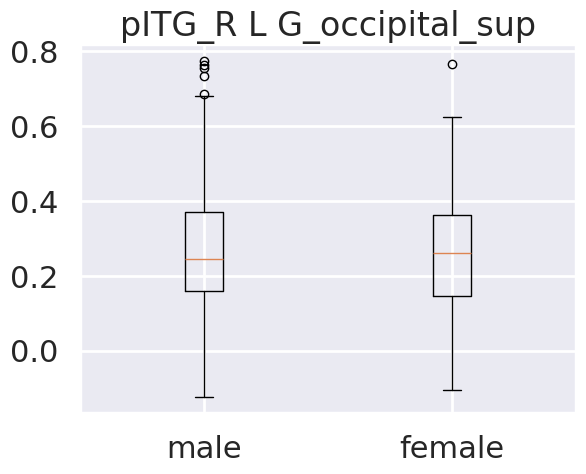

TtestResult(statistic=0.9629541940992754, pvalue=0.3360946577181738, df=444.0)
male mean : 0.27473477594409096
male std : 0.1715658534845672
female mean : 0.2598406360759292
female std : 0.15408335303503207
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [92]:
rois = ["pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_L

     coefficient          seed                       labels
60      0.285785  planumtemp_L  L S_oc-temp_med_and_Lingual
66      0.214379  planumtemp_L              L S_postcentral
108     0.189177  planumtemp_L      R G_temp_sup-Plan_polar
20      0.177437  planumtemp_L      L G_oc-temp_lat-fusifor
99      0.169222  planumtemp_L      R G_pariet_inf-Supramar
32      0.146572  planumtemp_L      L G_temp_sup-G_T_transv
84      0.144802  planumtemp_L                   R G_cuneus
124     0.140053  planumtemp_L       R S_collat_transv_post
97      0.137739  planumtemp_L                  R G_orbital
12      0.137529  planumtemp_L        L G_front_inf-Orbital
The mean accuracy : 0.7954433333333334
The standard deviation of the accuracy : 0.04432193948546348
The lower boundry of the confidance interval of the accuracy : 0.708572331941825
The upper boundry of the confidance interval of the accuracy : 0.8823143347248418
Mean sensitivity : 0.7915346005222705 Std sensitivity : 0.051554777928525294


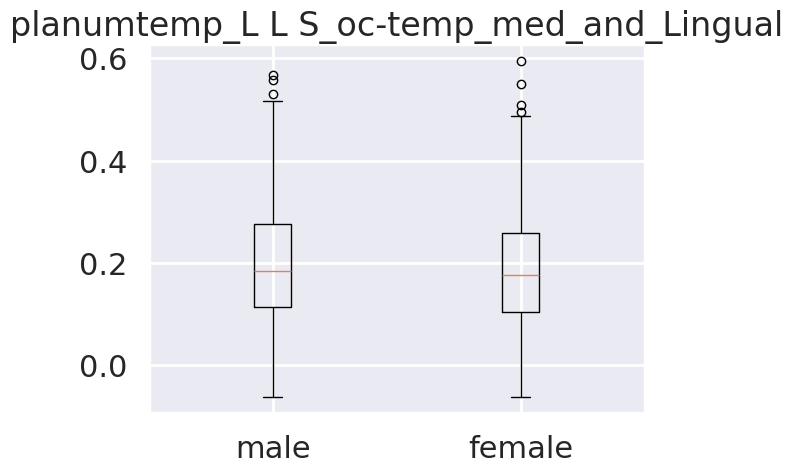

TtestResult(statistic=-0.018955201538938444, pvalue=0.9848853579000842, df=444.0)
male mean : 0.19560349765772725
male std : 0.11553457722911402
female mean : 0.1958168242159292
female std : 0.12143299330378049


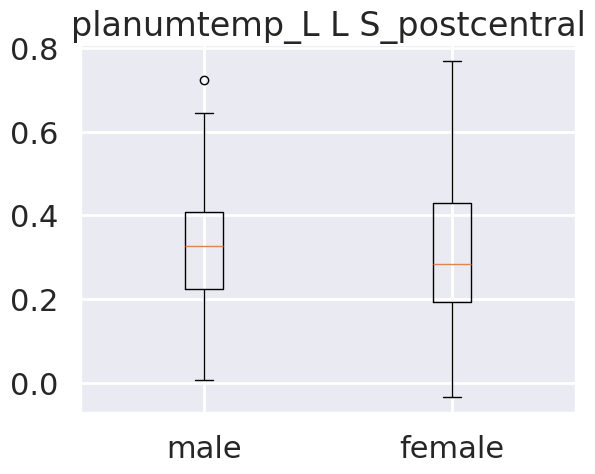

TtestResult(statistic=0.99881382874437, pvalue=0.31842891167423903, df=444.0)
male mean : 0.3188243096168182
male std : 0.13826779812472206
female mean : 0.30463629516946905
female std : 0.15994281470775304


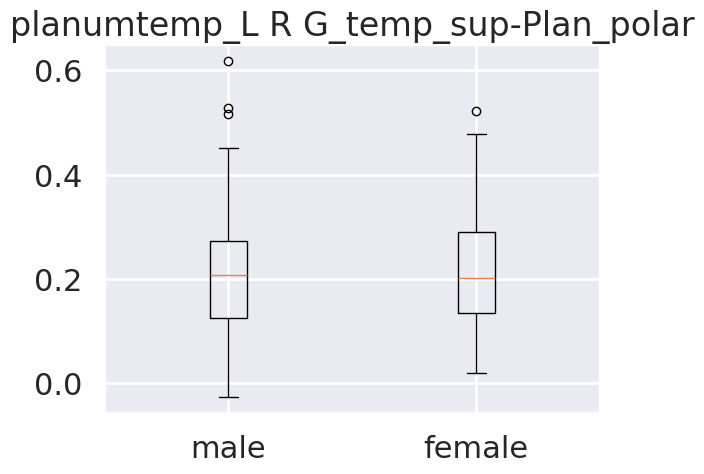

TtestResult(statistic=-0.49658022551965847, pvalue=0.6197308616234143, df=444.0)
male mean : 0.20703798182954544
male std : 0.10449484252167818
female mean : 0.21192919504867258
female std : 0.10304884232248941


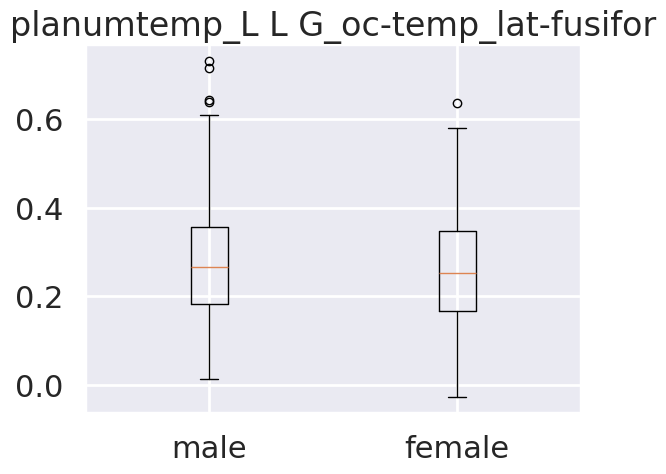

TtestResult(statistic=0.8312145629057236, pvalue=0.40629920488268956, df=444.0)
male mean : 0.27652223178636365
male std : 0.1299933971537437
female mean : 0.26641974534955754
female std : 0.12610447250617232


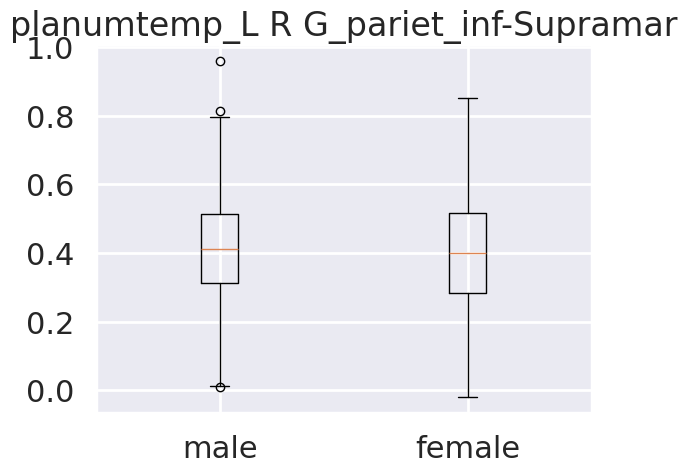

TtestResult(statistic=0.8112014664379938, pvalue=0.41768461521470845, df=444.0)
male mean : 0.4108449056727273
male std : 0.15872014519247643
female mean : 0.3983951438761062
female std : 0.1645088319088511


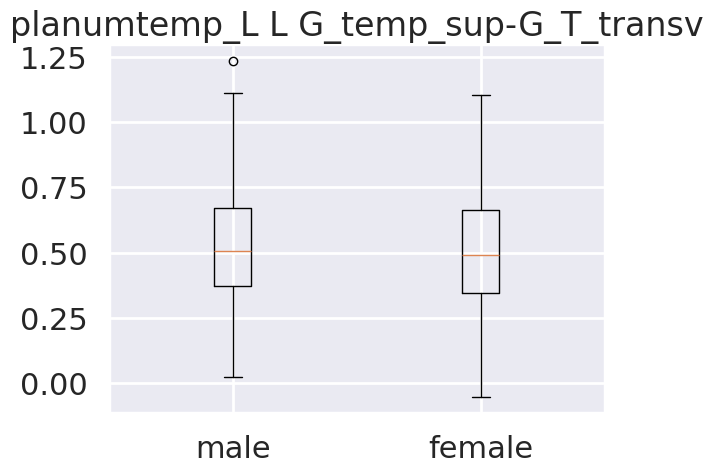

TtestResult(statistic=1.112502821549467, pvalue=0.26652399289422374, df=444.0)
male mean : 0.52790794775
male std : 0.2078075699697275
female mean : 0.5056785098318585
female std : 0.213085862485


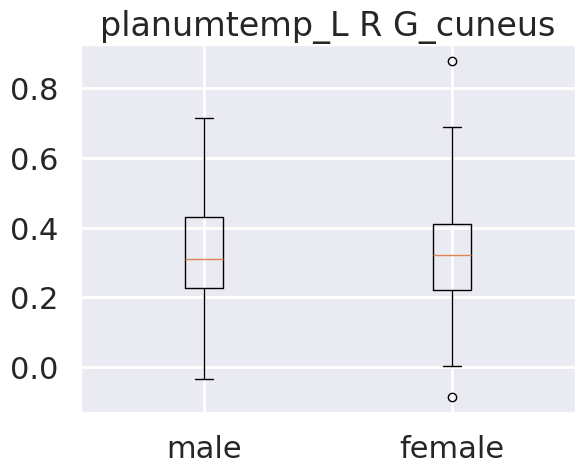

TtestResult(statistic=0.7406679099915333, pvalue=0.45928632702230665, df=444.0)
male mean : 0.3297348220481818
male std : 0.14929272325484488
female mean : 0.3191850437307964
female std : 0.1507875843231448


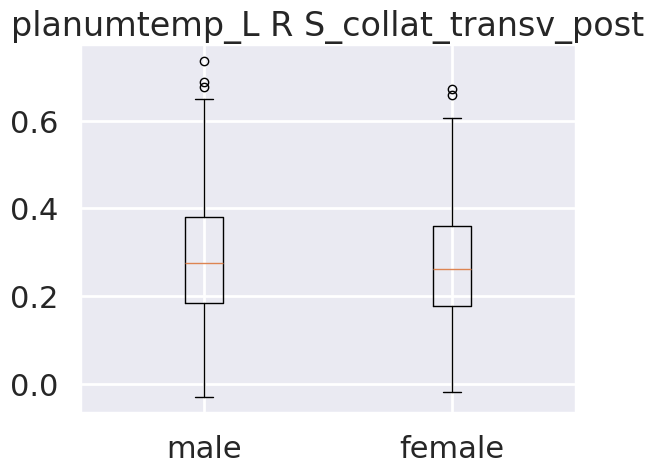

TtestResult(statistic=0.8630585561703593, pvalue=0.3885712180953744, df=444.0)
male mean : 0.28564585282045457
male std : 0.14625196444401473
female mean : 0.2739917209026549
female std : 0.13824941894914097


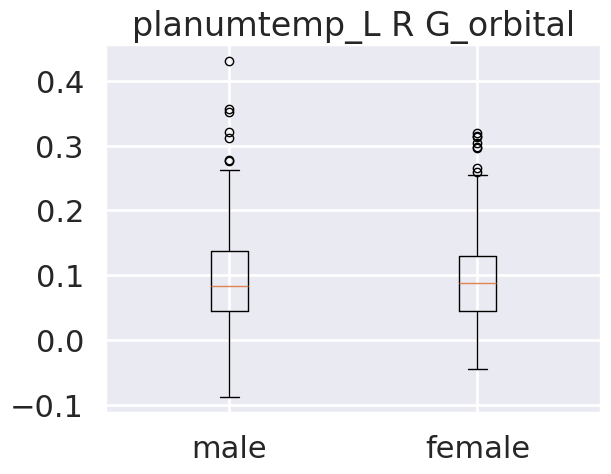

TtestResult(statistic=0.4833481967534641, pvalue=0.6290867887373555, df=444.0)
male mean : 0.09916828843359089
male std : 0.08204278142404257
female mean : 0.09560403915752211
female std : 0.07319149600450889


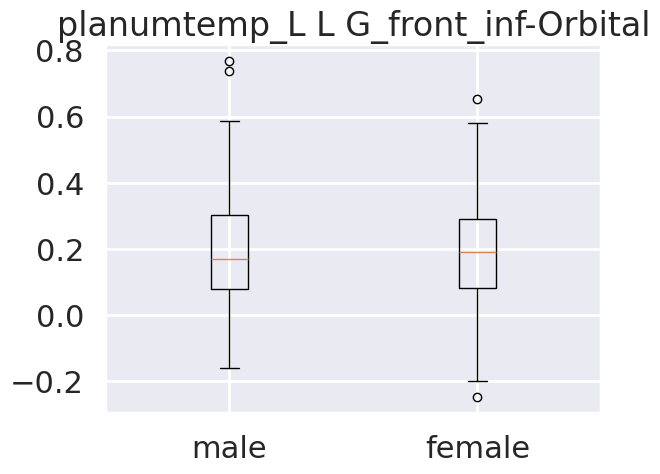

TtestResult(statistic=0.09720648324447106, pvalue=0.922606282865601, df=444.0)
male mean : 0.1958100565231818
male std : 0.16414401332641348
female mean : 0.19434243005460178
female std : 0.15393597212331298
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [93]:
rois = ["planumtemp_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_L)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions planumtemp_R

     coefficient          seed                       labels
72      0.223593  planumtemp_R             L S_temporal_sup
60      0.222028  planumtemp_R  L S_oc-temp_med_and_Lingual
47      0.216804  planumtemp_R      L S_circular_insula_inf
108     0.211511  planumtemp_R      R G_temp_sup-Plan_polar
121     0.186898  planumtemp_R      R S_circular_insula_inf
145     0.171646  planumtemp_R             R S_temporal_inf
139     0.167862  planumtemp_R             R S_pericallosal
78      0.152822  planumtemp_R   R G_and_S_transv_frontopol
80      0.145916  planumtemp_R     R G_and_S_cingul-Mid-Ant
32      0.144998  planumtemp_R      L G_temp_sup-G_T_transv
The mean accuracy : 0.7970066666666668
The standard deviation of the accuracy : 0.04447058070396819
The lower boundry of the confidance interval of the accuracy : 0.709844328486889
The upper boundry of the confidance interval of the accuracy : 0.8841690048464445
Mean sensitivity : 0.7893166242418801 Std sensitivity : 0.0515266336808596
Me

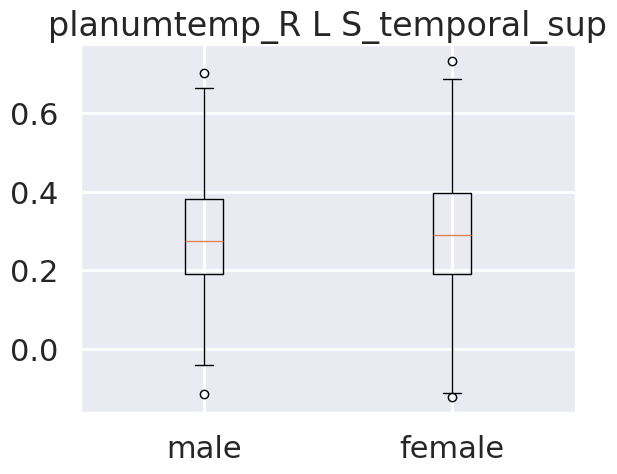

TtestResult(statistic=-0.5623665391173003, pvalue=0.5741501181938363, df=444.0)
male mean : 0.28790433803
male std : 0.14422700261098734
female mean : 0.295930255649115
female std : 0.1560759244227015


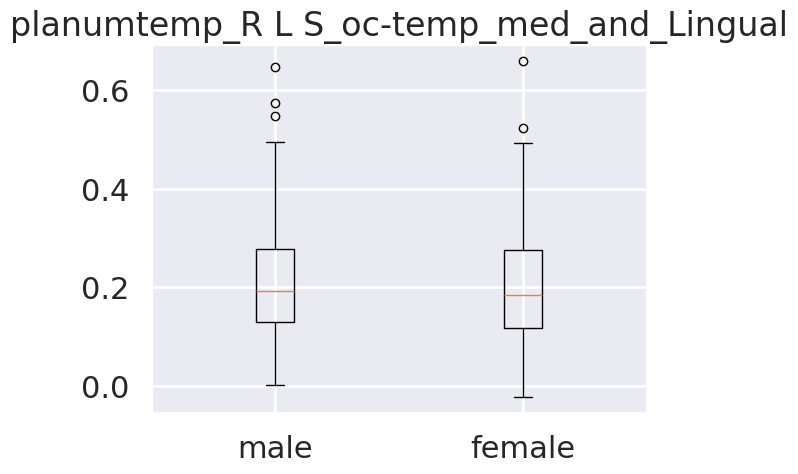

TtestResult(statistic=0.6303705603460131, pvalue=0.5287764652343739, df=444.0)
male mean : 0.21181543478699996
male std : 0.11171300472933252
female mean : 0.20492180302964605
female std : 0.11850702663759047


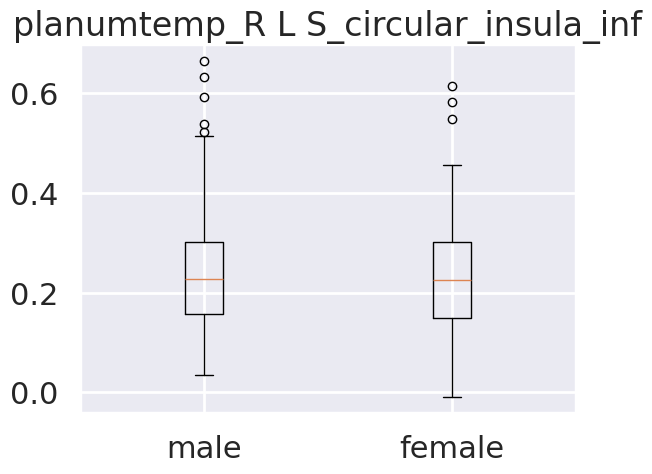

TtestResult(statistic=0.5700788027363477, pvalue=0.5689125960106347, df=444.0)
male mean : 0.23815464425000002
male std : 0.10999603167888458
female mean : 0.23228223751150442
female std : 0.10706043011814263


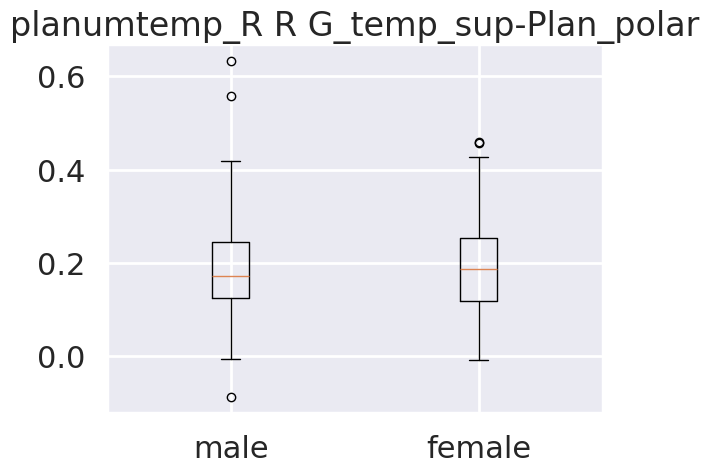

TtestResult(statistic=-0.7584824776565335, pvalue=0.44856462250649287, df=444.0)
male mean : 0.18800677794090911
male std : 0.0934470563869033
female mean : 0.19487283607964603
female std : 0.09719359451502213


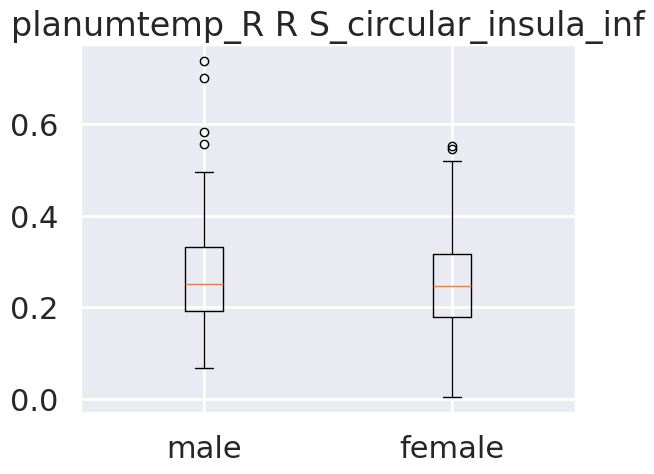

TtestResult(statistic=1.4058797870707365, pvalue=0.16045922476847255, df=444.0)
male mean : 0.26404327851363635
male std : 0.10784071039977033
female mean : 0.2500453904141593
female std : 0.10193681016282065


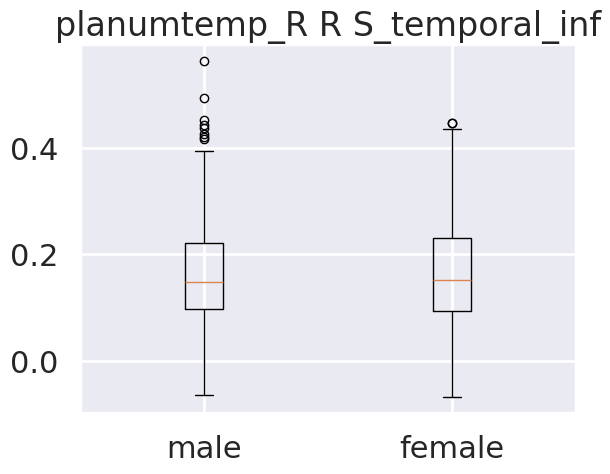

TtestResult(statistic=0.15190272589316534, pvalue=0.8793326560145229, df=444.0)
male mean : 0.16739266304727274
male std : 0.10256577624573711
female mean : 0.16591189901902653
female std : 0.10281745624533253


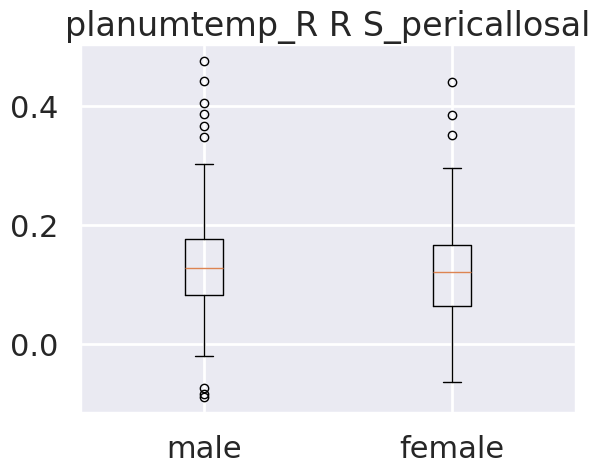

TtestResult(statistic=1.6707122700237407, pvalue=0.09548321340293443, df=444.0)
male mean : 0.13451138929909093
male std : 0.08431946209685855
female mean : 0.12144959410796462
female std : 0.08040941078395282


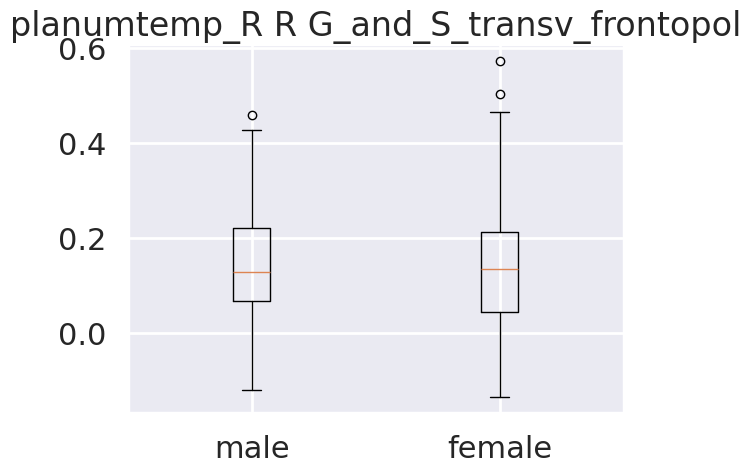

TtestResult(statistic=0.4243595305785367, pvalue=0.671509170134305, df=444.0)
male mean : 0.14278584594363636
male std : 0.11486733577190758
female mean : 0.13785455500876106
female std : 0.12934739592185884


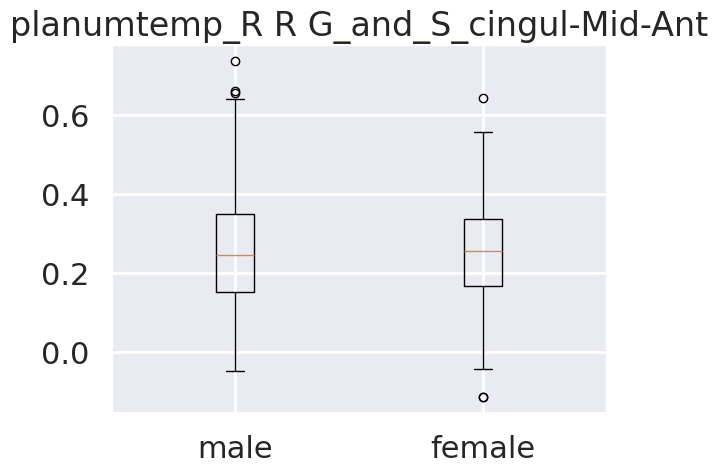

TtestResult(statistic=0.46253844238415165, pvalue=0.6439218303791144, df=444.0)
male mean : 0.2609372266636364
male std : 0.13749027519081208
female mean : 0.2550966605778761
female std : 0.12852686659757082


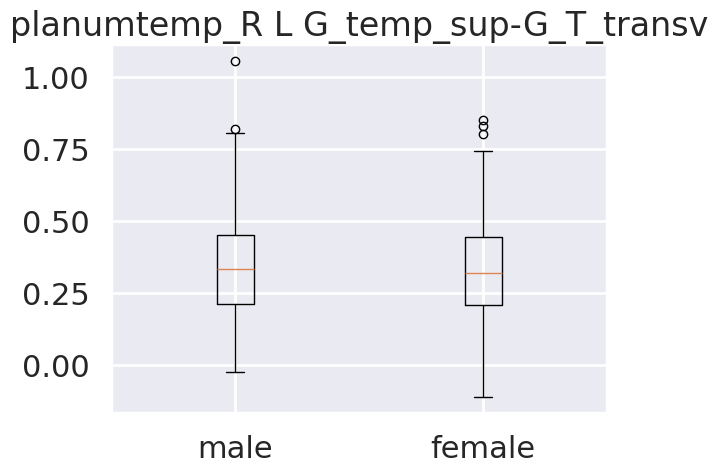

TtestResult(statistic=0.6378748366723407, pvalue=0.5238839830081853, df=444.0)
male mean : 0.34082361481499995
male std : 0.17402245266179422
female mean : 0.330362195261062
female std : 0.1715491335036446
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [94]:
rois = ["planumtemp_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_R)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions for all left seeds

     coefficient          seed                       labels
53      0.123777       opIFG_L                L S_front_sup
98      0.113710       opIFG_L       R G_pariet_inf-Angular
351     0.105832        aMTG_L  L S_intrapariet_and_P_trans
421     0.105135        aMTG_L                R S_front_inf
322     0.103736        aMTG_L             L G_parietal_sup
305     0.100285        aMTG_L      L G_cingul-Post-ventral
4       0.100128       opIFG_L   L G_and_S_transv_frontopol
431     0.095805        aMTG_L          R S_orbital_lateral
273     0.093985  planumtemp_L                R S_front_inf
55      0.088499       opIFG_L  L S_intrapariet_and_P_trans
The mean accuracy : 0.9125455555555558
The standard deviation of the accuracy : 0.03167706104259511
The lower boundry of the confidance interval of the accuracy : 0.8504585159120694
The upper boundry of the confidance interval of the accuracy : 0.9746325951990422
Mean sensitivity : 0.9134898379989987 Std sensitivity : 0.04150831932387169


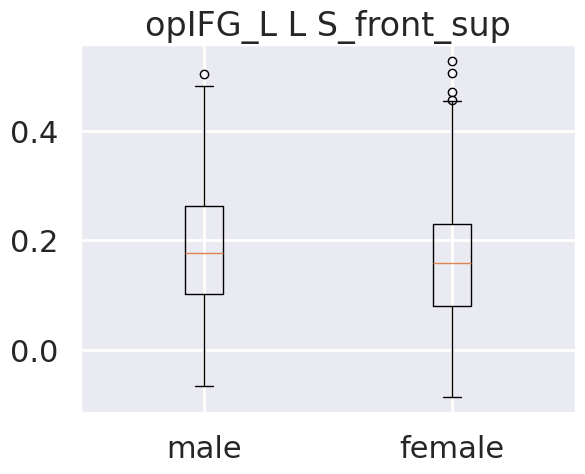

TtestResult(statistic=1.8386086382774387, pvalue=0.06664048715484525, df=444.0)
male mean : 0.18354724924686366
male std : 0.11555029853526483
female mean : 0.16325901403009732
female std : 0.11691880559681884


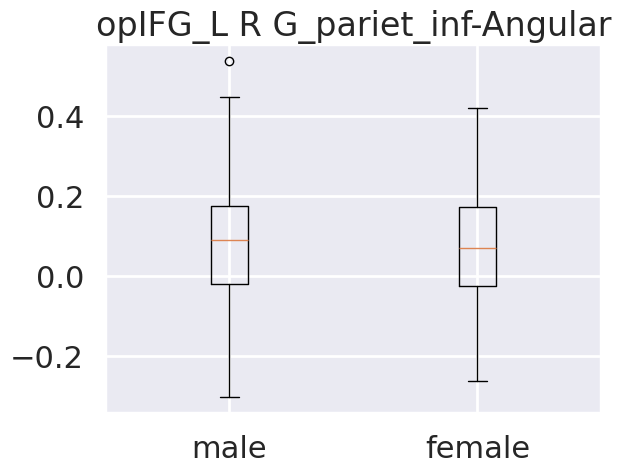

TtestResult(statistic=0.08591139105993699, pvalue=0.9315755833874969, df=444.0)
male mean : 0.07935426715545456
male std : 0.14282449297401265
female mean : 0.0782298258039823
female std : 0.13289471423540014


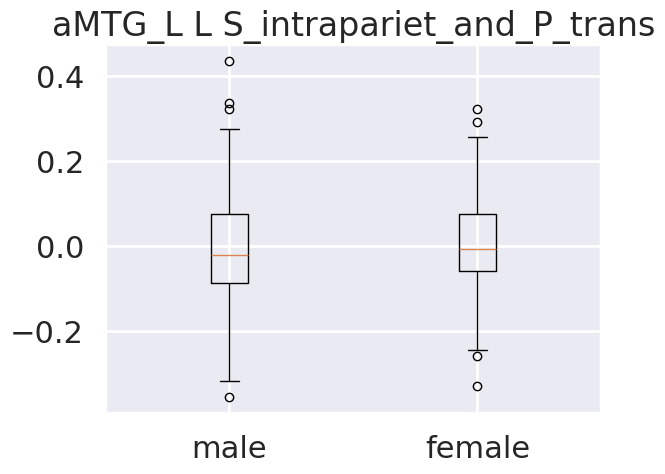

TtestResult(statistic=-0.5629449522849478, pvalue=0.5737565149961763, df=444.0)
male mean : -0.004352947120000001
male std : 0.11992515374089012
female mean : 0.0017103985353982307
female std : 0.10680532923333193


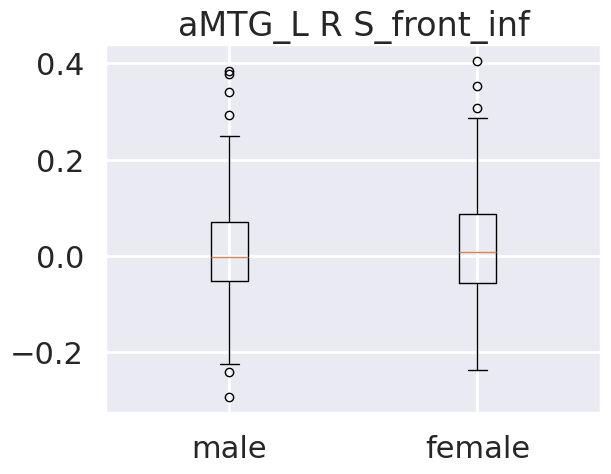

TtestResult(statistic=-1.0344019213226483, pvalue=0.3015113726056777, df=444.0)
male mean : 0.009040113515500001
male std : 0.11214850033551142
female mean : 0.020188220434349556
female std : 0.11487077247082961


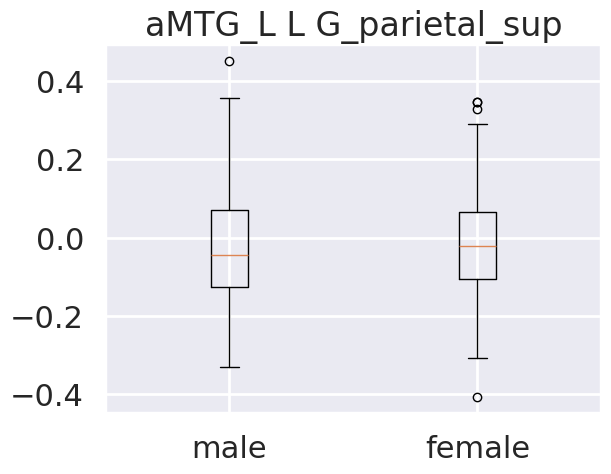

TtestResult(statistic=0.015908877647574173, pvalue=0.9873142336583003, df=444.0)
male mean : -0.019037156040909088
male std : 0.13980221990572175
female mean : -0.019240711578539817
female std : 0.12972998940269495


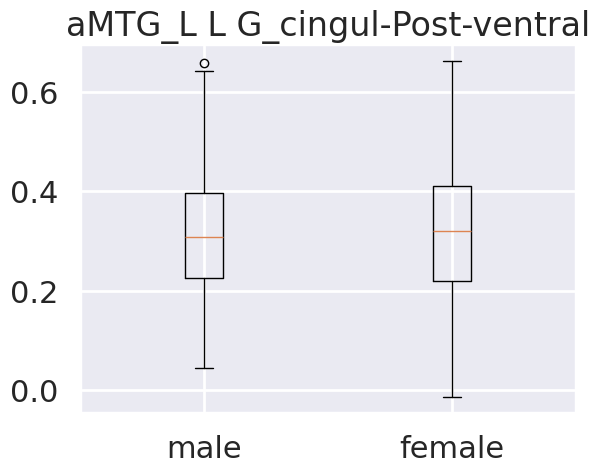

TtestResult(statistic=-0.2833432354183081, pvalue=0.7770458014163131, df=444.0)
male mean : 0.3156455165590909
male std : 0.12565269663262732
female mean : 0.3191625178451328
female std : 0.13555097899256496


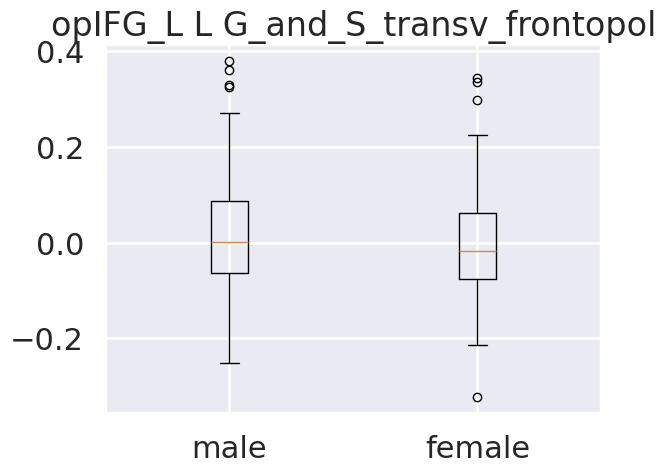

TtestResult(statistic=1.704073217878285, pvalue=0.08906705865566711, df=444.0)
male mean : 0.009279954413181817
male std : 0.11102207207238941
female mean : -0.00782524785345133
female std : 0.10034297686828818


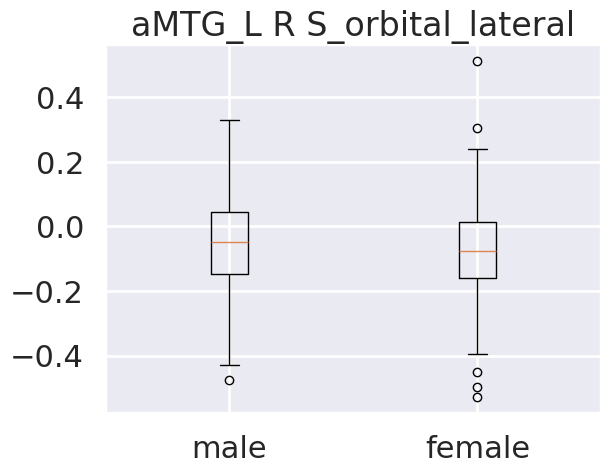

TtestResult(statistic=1.5922683491756897, pvalue=0.11203607391449234, df=444.0)
male mean : -0.05012122668031818
male std : 0.14338070010303233
female mean : -0.07177564318827433
female std : 0.14316029912268322


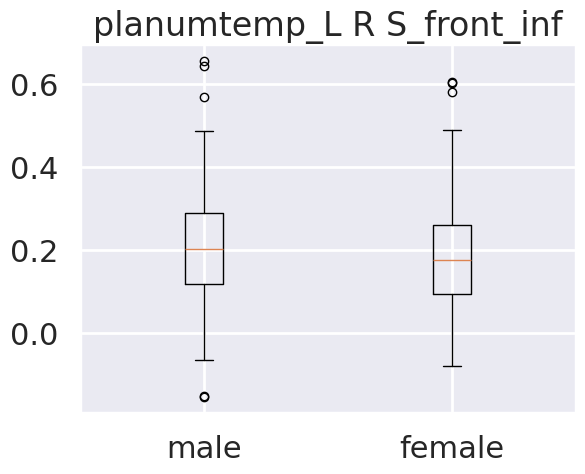

TtestResult(statistic=1.2098748966476487, pvalue=0.22697065486450205, df=444.0)
male mean : 0.20190828111636364
male std : 0.12683487723492423
female mean : 0.18740702922123895
female std : 0.1257102108596933


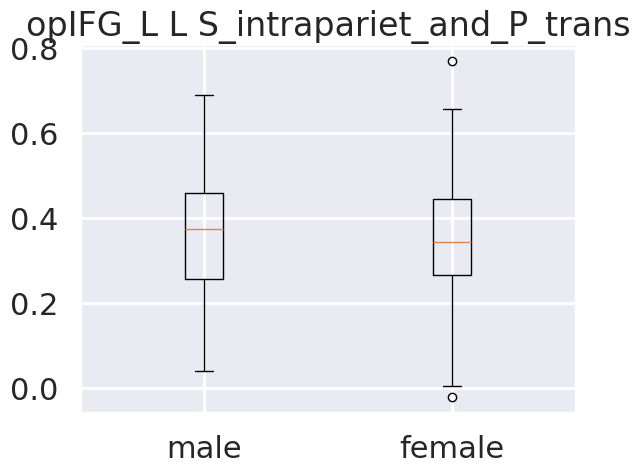

TtestResult(statistic=1.0378770541206963, pvalue=0.29989218232181175, df=444.0)
male mean : 0.36295411087727275
male std : 0.1438394817603057
female mean : 0.34900000852964597
female std : 0.13946053903379269
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [95]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_left)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

## Best regions of all right seeds

     coefficient          seed                       labels
53      0.134322       opIFG_R                L S_front_sup
66      0.114011       opIFG_R              L S_postcentral
316     0.104480        aMTG_R      L G_oc-temp_lat-fusifor
55      0.103655       opIFG_R  L S_intrapariet_and_P_trans
421     0.103610        aMTG_R                R S_front_inf
379     0.094846        aMTG_R      R G_cingul-Post-ventral
239     0.092743  planumtemp_R            R G_insular_short
522     0.086193        pITG_R   R G_and_S_transv_frontopol
273     0.085974  planumtemp_R                R S_front_inf
228     0.084403  planumtemp_R     R G_and_S_cingul-Mid-Ant
The mean accuracy : 0.8903488888888891
The standard deviation of the accuracy : 0.03524470722894888
The lower boundry of the confidance interval of the accuracy : 0.8212692627201492
The upper boundry of the confidance interval of the accuracy : 0.9594285150576289
Mean sensitivity : 0.8889100879516413 Std sensitivity : 0.044828656788072456

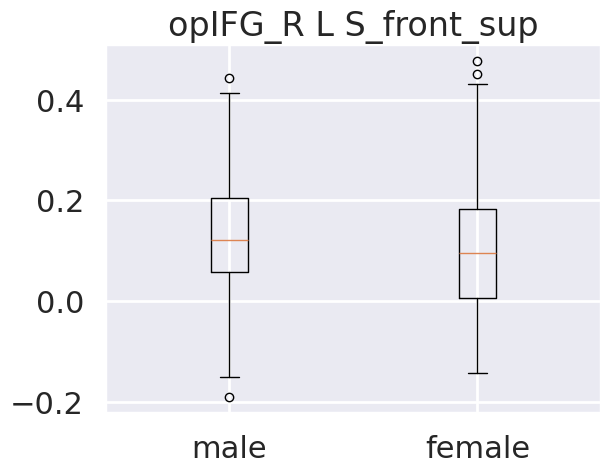

TtestResult(statistic=2.7712877132349694, pvalue=0.005818046217020924, df=444.0)
male mean : 0.13209549564272727
male std : 0.10837928174509652
female mean : 0.10247618119331857
female std : 0.11655067775022346


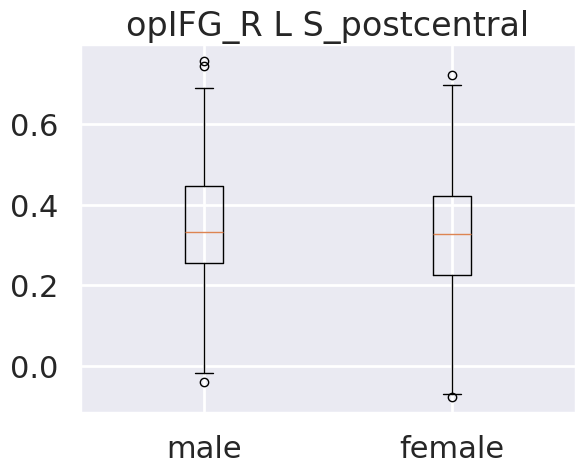

TtestResult(statistic=0.9151987861558548, pvalue=0.36058404718144454, df=444.0)
male mean : 0.3419503766181818
male std : 0.1373298867108125
female mean : 0.3299469699336283
female std : 0.13898137989012707


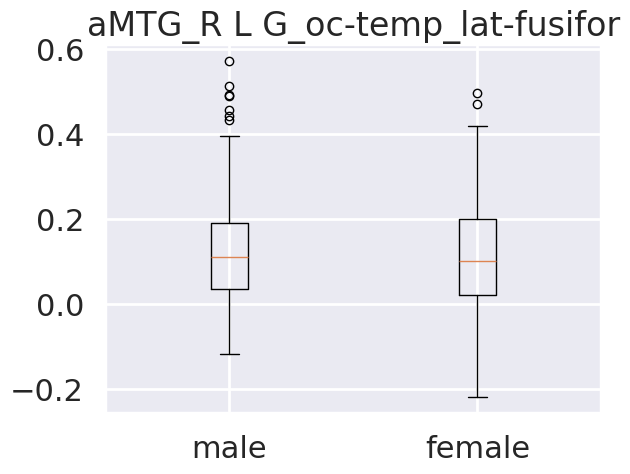

TtestResult(statistic=0.6618261297896938, pvalue=0.5084259884398799, df=444.0)
male mean : 0.1251803556624091
male std : 0.12416500737231072
female mean : 0.11723795153130832
female std : 0.12858531808264867


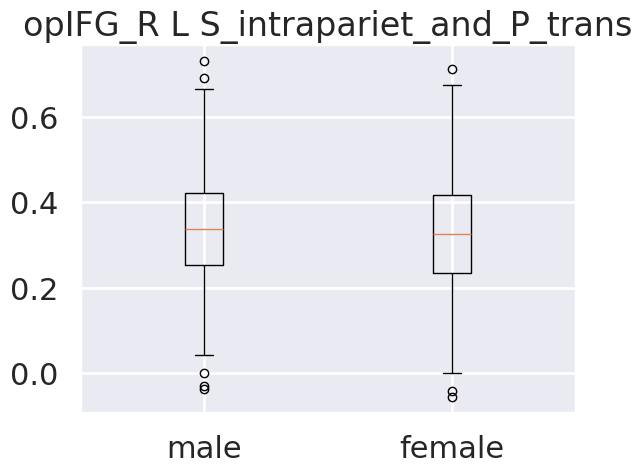

TtestResult(statistic=0.886164060317955, pvalue=0.3760088304470828, df=444.0)
male mean : 0.33837701796454545
male std : 0.1335731016008213
female mean : 0.3271137672234513
female std : 0.1342121309439049


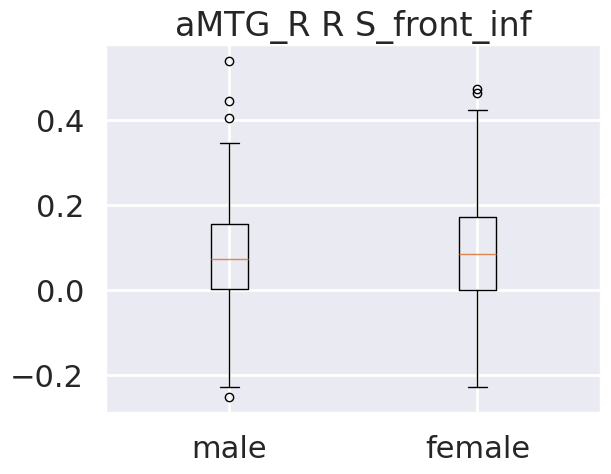

TtestResult(statistic=-0.8659935726660029, pvalue=0.38696138721745843, df=444.0)
male mean : 0.07918866444727271
male std : 0.12369684504008881
female mean : 0.08950797622964603
female std : 0.12729516350055226


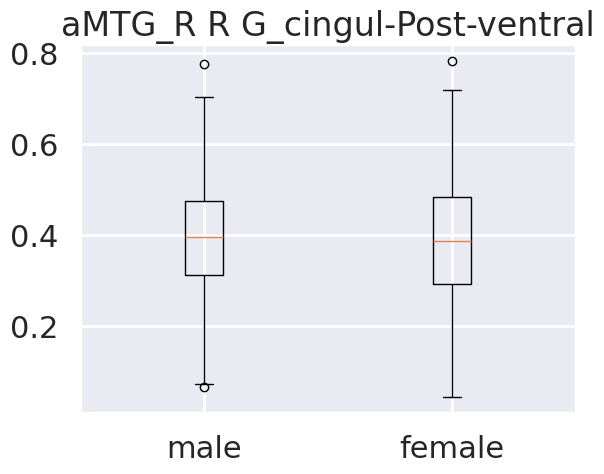

TtestResult(statistic=0.5399522640043164, pvalue=0.5895006586634257, df=444.0)
male mean : 0.38983515674545455
male std : 0.13128119707638264
female mean : 0.38286670389823
female std : 0.14036009370424207


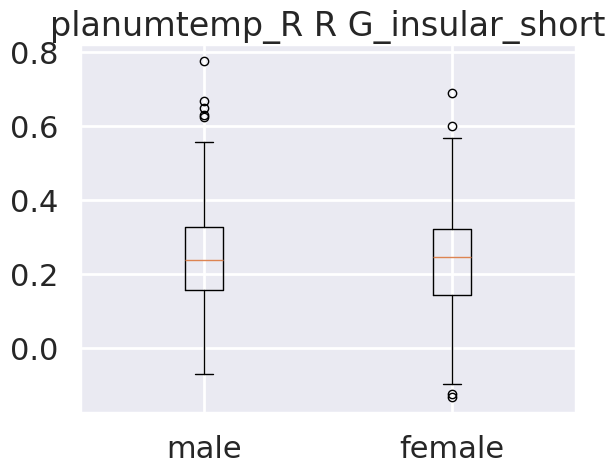

TtestResult(statistic=0.8609970021424133, pvalue=0.3897044052210804, df=444.0)
male mean : 0.2527016079177273
male std : 0.14417879050292717
female mean : 0.24125793585530975
female std : 0.13584668250426662


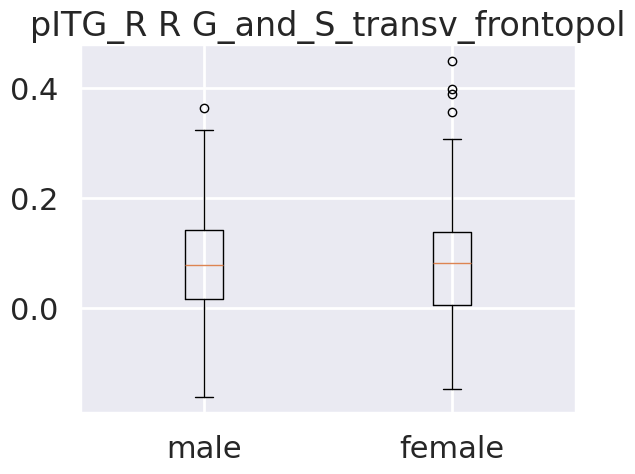

TtestResult(statistic=0.45150982516766125, pvalue=0.6518426041743509, df=444.0)
male mean : 0.08221655689954546
male std : 0.09251453858724128
female mean : 0.07808570323274336
female std : 0.10000274206737905


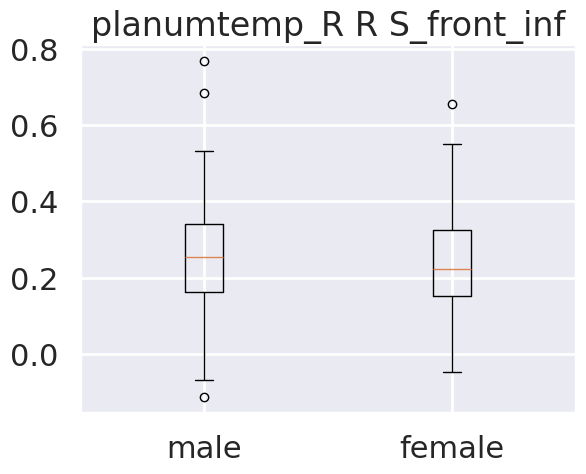

TtestResult(statistic=1.0229026635703389, pvalue=0.3069108647841219, df=444.0)
male mean : 0.2490507583409091
male std : 0.1253685705981462
female mean : 0.23684191620796463
female std : 0.12609419293424395


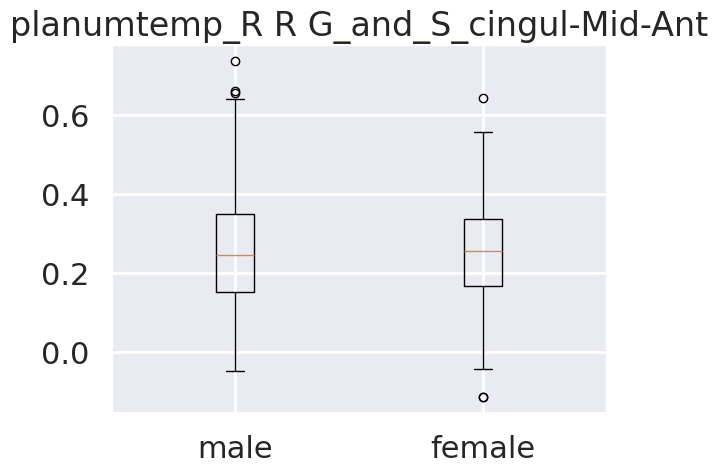

TtestResult(statistic=0.46253844238415165, pvalue=0.6439218303791144, df=444.0)
male mean : 0.2609372266636364
male std : 0.13749027519081208
female mean : 0.2550966605778761
female std : 0.12852686659757082
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [96]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_right)
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))
bestRegion(ROIs, data, df_boot)

# Noise testing

In [27]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

In [28]:
model_test = data_results["model"][random.randint(0, 10000)]
gender_test = np.asarray(df_boot["Gender"])
score, perm_score, p_val = permutation_test_score(model_test, x_correl, gender_test)

In [29]:
acc_iter = []
model_test = data_results["model"][random.randint(0, 10000)]
for i in range(0, 10000):
    gender_test = np.asarray(df_boot["Gender"])
    np.random.shuffle(gender_test)
    acc_rand = model_test.score(x_correl, gender_test)
    acc_iter.append(acc_rand)
    
acc_iter = np.asarray(acc_iter)

In [30]:
gender_test = np.asarray(df_boot["Gender"])
x_correl.size

528064

(0.4, 1.0)

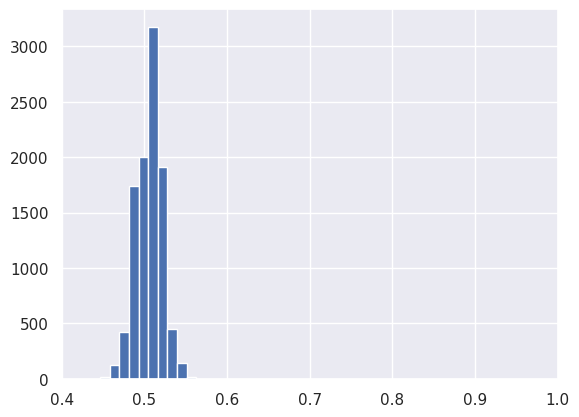

In [31]:
plt.hist(acc_iter)
plt.xlim([0.4, 1])

In [32]:
# accuracy should be around 0.50 (50%) if not it's a problem
acc_iter.mean()

0.5051103139013454

# Permutation testing

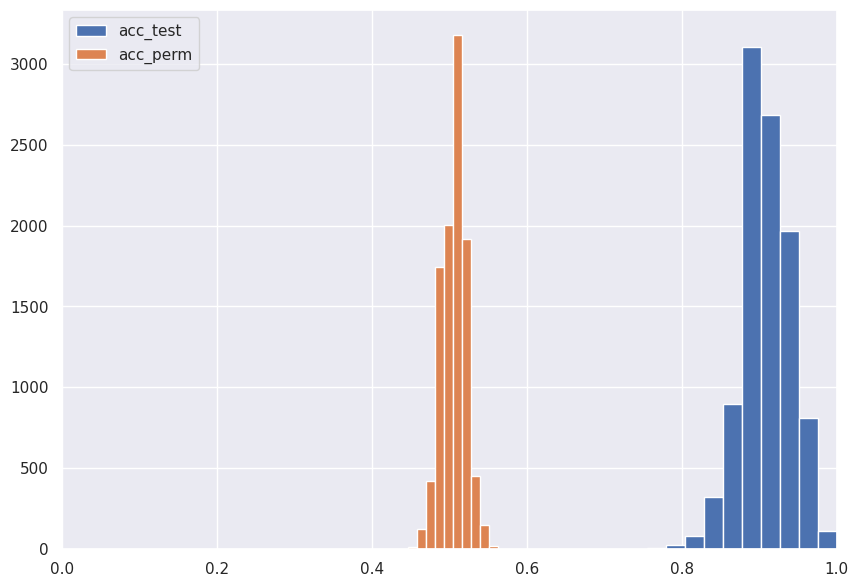

In [33]:
f = plt.figure()
plt.hist(data_results["acc_test"], label="acc_test")
plt.hist(acc_iter, label="acc_perm")
plt.legend(loc="upper left")
plt.xlim([0, 1])
f.set_figwidth(10)
f.set_figheight(7)

In [34]:
t_test = stats.ttest_ind(data_results["acc_test"], acc_iter)
print(t_test.pvalue)

0.0


# Violin plot

0.149155713895


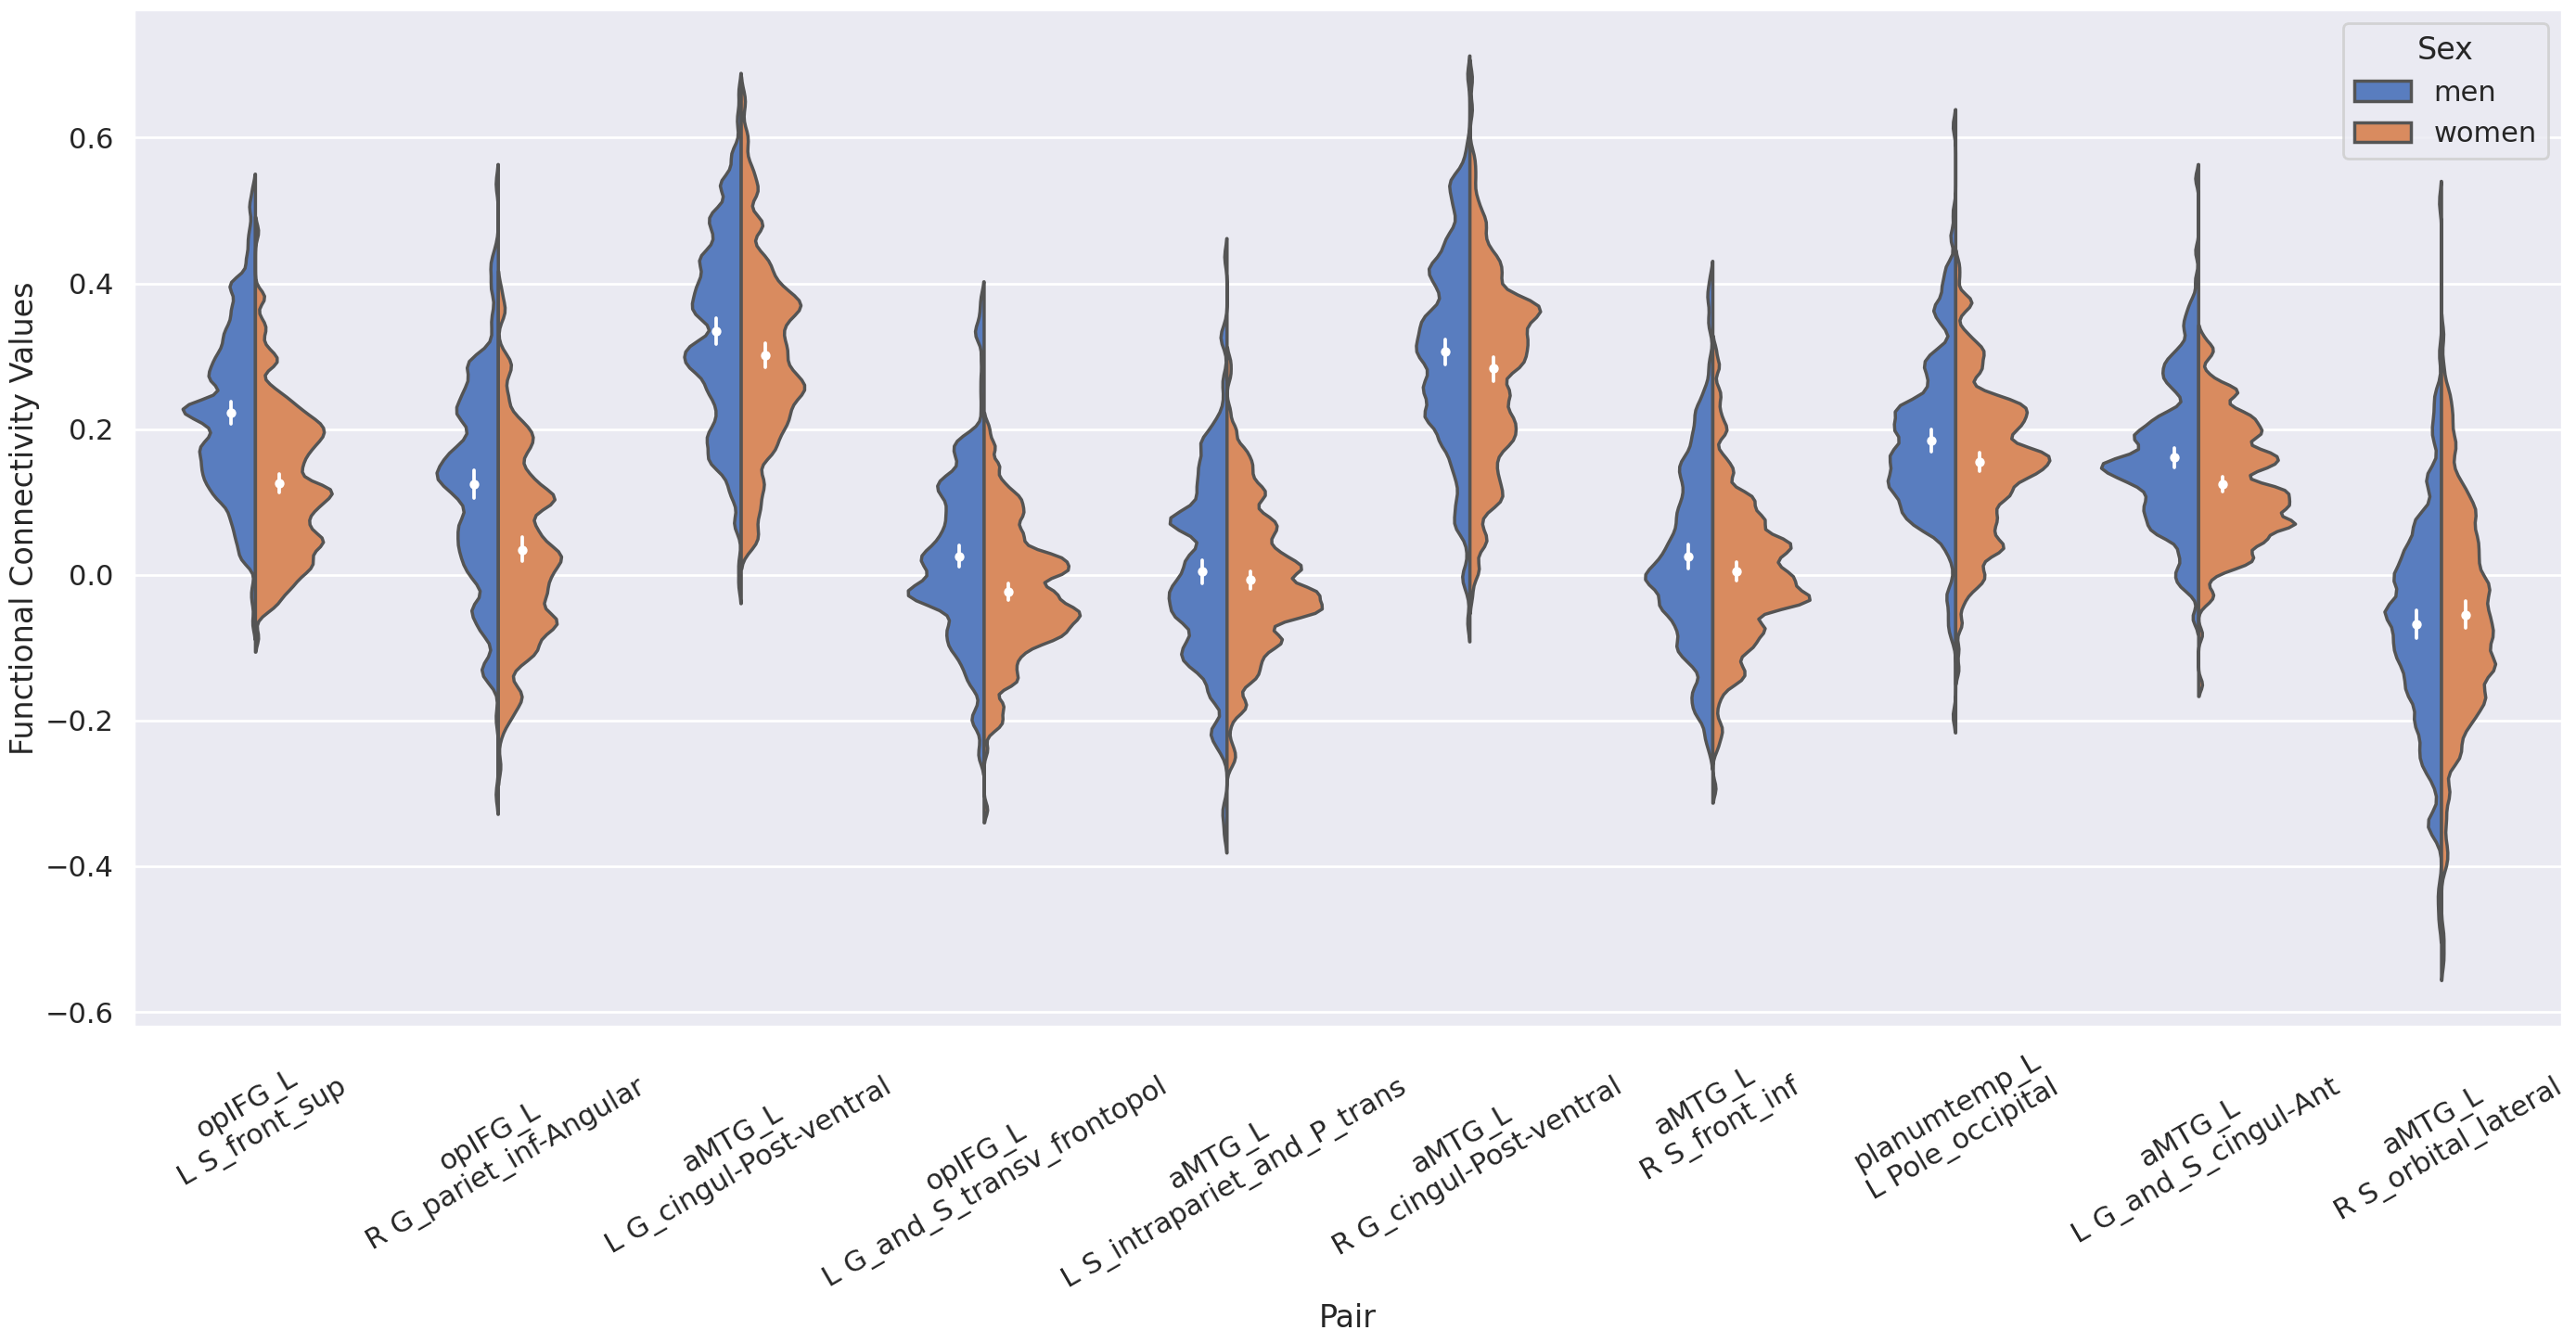

In [35]:
#1. make dataframe for the violin plot 
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")
df = pd.DataFrame.from_dict(data, orient="index", columns=label["name"]).reset_index()
df["participant_id"] = df["index"].apply(lambda x: x[0])
df["seed"] = df["index"].apply(lambda x: x[1])
df["Gender"] = list(Final_df["Gender"]) * 8
df["Gender"] = df["Gender"].replace({0:"men", 1:"women"})

df_connectivity = df.melt(id_vars=["participant_id", "seed", "Gender"], value_vars=label["name"])
df_connectivity["pair"] = df_connectivity["seed"] + " with " + df_connectivity["name"]

df_temp_men = df_connectivity.loc[
    (df_connectivity["Gender"] == "men") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]  
df_temp_women = df_connectivity.loc[
    (df_connectivity["Gender"] == "women") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]
stats.ttest_ind(df_temp_men["value"], df_temp_women["value"])
print(df_temp_men["value"].mean())

# 53      0.071998       opIFG_L                L S_front_sup
# 98      0.068703       opIFG_L       R G_pariet_inf-Angular
# 305     0.067761        aMTG_L      L G_cingul-Post-ventral
# 4       0.062096       opIFG_L   L G_and_S_transv_frontopol
# 351     0.060681        aMTG_L  L S_intrapariet_and_P_trans
# 379     0.055342        aMTG_L      R G_cingul-Post-ventral
# 421     0.054767        aMTG_L                R S_front_inf
# 189     0.053099  planumtemp_L             L Pole_occipital
# 301     0.052427        aMTG_L         L G_and_S_cingul-Ant
# 431     0.051413        aMTG_L          R S_orbital_lateral


# A changer selon les dix meilleures seeds
# list to make sure top 10 regions are in order 
top10 = ["opIFG_L with L S_front_sup",
         "opIFG_L with R G_pariet_inf-Angular",
         "aMTG_L with L G_cingul-Post-ventral",
         "opIFG_L with L G_and_S_transv_frontopol",
         "aMTG_L with L S_intrapariet_and_P_trans", 
         "aMTG_L with R G_cingul-Post-ventral",
         "aMTG_L with R S_front_inf",
         "planumtemp_L with L Pole_occipital",
         "aMTG_L with L G_and_S_cingul-Ant", 
         "aMTG_L with R S_orbital_lateral"]
         

df_temp = df_connectivity.loc[
    # (df_connectivity["seed"] == "opIFG_L") &
    (df_connectivity["pair"].isin(top10))
]  
df_temp["Sex"] = df_temp["Gender"]
df_temp["Functional Connectivity Values"] = df_temp["value"]
df_temp["Pair"] = df_temp["pair"]

# plt.figure(figsize=(20, 11.25))

sns.set_theme(context="poster")

v_plot = sns.violinplot(x="Pair", y="Functional Connectivity Values", hue="Sex", data=df_temp, split= True, bw=0.10,inner = None, palette="muted", order=top10)
# v_plot.set_xticks([0,1])
# v_plot.set_xticklabels(["aMTG_L\nL S_front_sup", "2"])
# v_plot

v_plot = sns.pointplot(x="Pair", y="Functional Connectivity Values", hue="Sex",
                    data=df_temp, dodge=0.2, join=False, palette=['white'], ax=v_plot, scale=0.5, order=top10, legend=False)

# changer les xticklabels selon les labels obtenues
v_plot.set_xticks([0,1,2,3,4,5,6,7,8,9])
v_plot.set_xticklabels(["opIFG_L\nL S_front_sup",
         "opIFG_L\nR G_pariet_inf-Angular",
         "aMTG_L\nL G_cingul-Post-ventral",
         "opIFG_L\n L G_and_S_transv_frontopol",
         "aMTG_L\nL S_intrapariet_and_P_trans", 
         "aMTG_L\nR G_cingul-Post-ventral",
         "aMTG_L\nR S_front_inf",
         "planumtemp_L\nL Pole_occipital",
         "aMTG_L\nL G_and_S_cingul-Ant",
         "aMTG_L\nR S_orbital_lateral"], rotation=30)


fig = v_plot.get_figure()
fig.set_size_inches(28.5, 15)
plt.tight_layout()
fig.savefig("./Images/violin_plot.png", dpi=300)

# Classification based on best feature

In [36]:
def machine_learning(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score.append(cross_val_score(model, X_train, y_train, cv=20, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

## Testing the machine learning classification feature by feature

In [37]:
# the best feature (seed and their region)
seeds = ["opIFG_L", "opIFG_L", "aMTG_L", "opIFG_L", "aMTG_L", "aMTG_L", "aMTG_L", "planumtemp_L", "aMTG_L", "aMTG_L"]
regions = ["L_S_front_sup", 
          "R_G_pariet_inf-Angular", 
          "L_G_cingul-Post-ventral", 
          "L_G_and_S_transv_frontopol", 
          "L_S_intrapariet_and_P_trans", 
          "R_G_cingul-Post-ventral",
           "R_S_front_inf",
           "L_Pole_occipital",
           "L_G_and_S_cingul-Ant",
           "R_S_orbital_lateral"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_fisherz/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__fisherz.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")

x = []
y = []
for i in range(0, len(seeds)):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    signal = loaded[seeds[i]+"__"+regions[i]]
    for subject in Final_df["Subject"]:
        sub_sex = Final_df.loc[Final_df["Subject"] == subject]["Gender"].values[0]
        value = loaded.loc[loaded["Unnamed: 0"] == "sub-"+str(subject)][seeds[i]+"__"+regions[i]].values[0]
        x.append(value)
        y.append(sub_sex)
    x = np.asarray(x)
    x = x.reshape(-1,1)
    print("Testing : "+seeds[i]+" "+regions[i])
    results = machine_learning(x,y)
    sensitivity = results["confusion_matrix"]["Femme"][0] / (results["confusion_matrix"]["Femme"][0] + results["confusion_matrix"]["Femme"][1])
    specificity = results["confusion_matrix"]['Homme'][1] / (results["confusion_matrix"]["Homme"][1] + results["confusion_matrix"]["Homme"][0])
    print("Sensitivity : " + str(sensitivity))
    print("Specificity : " + str(specificity))
    print("\n")
    x = []
    y = []
        

Testing : opIFG_L L_S_front_sup
train: 356 test: 90


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

[array([0.61111111, 0.66666667, 0.44444444, 0.77777778, 0.72222222,
       0.5       , 0.72222222, 0.72222222, 0.61111111, 0.55555556,
       0.55555556, 0.66666667, 0.77777778, 0.66666667, 0.55555556,
       0.66666667, 0.58823529, 0.88235294, 0.70588235, 0.64705882])]
predicted class  Femme  Homme
actual class                 
Femme               27     19
Homme               11     33
accuracy test (r2) = 0.6666666666666666
accuracy train (r2) = 0.651685393258427
Sensitivity : 0.7105263157894737
Specificity : 0.6346153846153846


Testing : opIFG_L R_G_pariet_inf-Angular
train: 356 test: 90
[array([0.66666667, 0.66666667, 0.5       , 0.77777778, 0.88888889,
       0.72222222, 0.72222222, 0.5       , 0.72222222, 0.38888889,
       0.55555556, 0.55555556, 0.66666667, 0.66666667, 0.66666667,
       0.44444444, 0.52941176, 0.58823529, 0.82352941, 0.52941176])]
predicted class  Femme  Homme
actual class                 
Femme               27     19
Homme               13     31
accuracy 

/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L L_G_cingul-Post-ventral
train: 356 test: 90
[array([0.5       , 0.5       , 0.38888889, 0.5       , 0.61111111,
       0.44444444, 0.44444444, 0.55555556, 0.55555556, 0.61111111,
       0.66666667, 0.72222222, 0.38888889, 0.61111111, 0.5       ,
       0.72222222, 0.52941176, 0.58823529, 0.58823529, 0.35294118])]
predicted class  Femme  Homme
actual class                 
Femme               28     18
Homme               21     23
accuracy test (r2) = 0.5666666666666667
accuracy train (r2) = 0.5421348314606742
Sensitivity : 0.5714285714285714
Specificity : 0.5609756097560976




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : opIFG_L L_G_and_S_transv_frontopol
train: 356 test: 90
[array([0.55555556, 0.55555556, 0.5       , 0.83333333, 0.72222222,
       0.44444444, 0.44444444, 0.55555556, 0.5       , 0.5       ,
       0.55555556, 0.72222222, 0.72222222, 0.61111111, 0.55555556,
       0.5       , 0.41176471, 0.70588235, 0.64705882, 0.47058824])]
predicted class  Femme  Homme
actual class                 
Femme               26     20
Homme               15     29
accuracy test (r2) = 0.6111111111111112
accuracy train (r2) = 0.5786516853932584
Sensitivity : 0.6341463414634146
Specificity : 0.5918367346938775




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L L_S_intrapariet_and_P_trans
train: 356 test: 90
[array([0.5       , 0.61111111, 0.5       , 0.55555556, 0.5       ,
       0.55555556, 0.44444444, 0.55555556, 0.66666667, 0.61111111,
       0.16666667, 0.5       , 0.61111111, 0.5       , 0.61111111,
       0.61111111, 0.58823529, 0.58823529, 0.47058824, 0.58823529])]
predicted class  Femme  Homme
actual class                 
Femme               35     11
Homme               28     16
accuracy test (r2) = 0.5666666666666667
accuracy train (r2) = 0.547752808988764
Sensitivity : 0.5555555555555556
Specificity : 0.5925925925925926


Testing : aMTG_L R_G_cingul-Post-ventral


/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

train: 356 test: 90
[array([0.38888889, 0.38888889, 0.38888889, 0.44444444, 0.61111111,
       0.5       , 0.5       , 0.61111111, 0.5       , 0.5       ,
       0.66666667, 0.66666667, 0.44444444, 0.72222222, 0.55555556,
       0.55555556, 0.52941176, 0.58823529, 0.58823529, 0.29411765])]
predicted class  Femme  Homme
actual class                 
Femme               26     20
Homme               23     21
accuracy test (r2) = 0.5222222222222223
accuracy train (r2) = 0.5224719101123596
Sensitivity : 0.5306122448979592
Specificity : 0.5121951219512195




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L R_S_front_inf
train: 356 test: 90
[array([0.5       , 0.5       , 0.44444444, 0.61111111, 0.55555556,
       0.5       , 0.33333333, 0.61111111, 0.5       , 0.44444444,
       0.44444444, 0.61111111, 0.77777778, 0.61111111, 0.55555556,
       0.61111111, 0.58823529, 0.58823529, 0.58823529, 0.47058824])]
predicted class  Femme  Homme
actual class                 
Femme               23     23
Homme               26     18
accuracy test (r2) = 0.45555555555555555
accuracy train (r2) = 0.5393258426966292
Sensitivity : 0.46938775510204084
Specificity : 0.43902439024390244




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : planumtemp_L L_Pole_occipital
train: 356 test: 90
[array([0.38888889, 0.66666667, 0.44444444, 0.61111111, 0.66666667,
       0.44444444, 0.66666667, 0.55555556, 0.5       , 0.38888889,
       0.38888889, 0.55555556, 0.5       , 0.61111111, 0.5       ,
       0.61111111, 0.52941176, 0.64705882, 0.58823529, 0.52941176])]
predicted class  Femme  Homme
actual class                 
Femme               27     19
Homme               19     25
accuracy test (r2) = 0.5777777777777777
accuracy train (r2) = 0.5393258426966292
Sensitivity : 0.5869565217391305
Specificity : 0.5681818181818182




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L L_G_and_S_cingul-Ant
train: 356 test: 90
[array([0.66666667, 0.5       , 0.55555556, 0.55555556, 0.55555556,
       0.55555556, 0.33333333, 0.72222222, 0.44444444, 0.66666667,
       0.55555556, 0.44444444, 0.44444444, 0.61111111, 0.66666667,
       0.66666667, 0.70588235, 0.41176471, 0.58823529, 0.41176471])]
predicted class  Femme  Homme
actual class                 
Femme               31     15
Homme               19     25
accuracy test (r2) = 0.6222222222222222
accuracy train (r2) = 0.5533707865168539
Sensitivity : 0.62
Specificity : 0.625




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

Testing : aMTG_L R_S_orbital_lateral
train: 356 test: 90
[array([0.44444444, 0.5       , 0.61111111, 0.66666667, 0.55555556,
       0.55555556, 0.61111111, 0.61111111, 0.33333333, 0.38888889,
       0.61111111, 0.55555556, 0.38888889, 0.5       , 0.44444444,
       0.55555556, 0.52941176, 0.35294118, 0.41176471, 0.41176471])]
predicted class  Femme  Homme
actual class                 
Femme               26     20
Homme               28     16
accuracy test (r2) = 0.4666666666666667
accuracy train (r2) = 0.5140449438202247
Sensitivity : 0.48148148148148145
Specificity : 0.4444444444444444




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

# Independent validation testing (60/20/20) with z-transformed applied on r-pearson score

In [97]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-aMTG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-opIFG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-pITG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-pITG_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-planumtemp_R_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_left = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-left_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_path_all_right = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-right_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

# FYI do not interpret the regions just look at the mean accuraccy which is the mean accuracy of the model on the validation sample

In [40]:
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)

In [98]:
# mean confusion matrix
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print(mean_confusion)
sensitivity = data_results["confusion_matrix"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

predicted class    Femme    Homme
actual class                     
Femme            40.9187   4.6536
Homme             5.2150  39.2127
Mean sensitivity : 0.8889100879516413 Std sensitivity : 0.044828656788072456
Mean specificity : 0.8960663627939812 Std specificity : 0.04644044521405558


In [99]:
# mean confusion matrix of the validation set
pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

predicted class    Femme    Homme
actual class                     
Femme            45.7133  16.2867
Homme            13.2552  36.7448
Mean sensitivity : 0.7762417849899873 Std sensitivity : 0.03338493652086484
Mean specificity : 0.6944463175452116 Std specificity : 0.038964230378200966


## Best regions all seed validation accuraccy

Validation accuracy
The mean accuracy : 0.7459848214285714
The standard deviation of the accuracy : 0.027793640289270078
The lower boundry of the confidance interval of the accuracy : 0.691509286461602
The upper boundry of the confidance interval of the accuracy : 0.8004603563955407

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            46.2543  15.7457
Homme            12.7040  37.2960
Mean sensitivity : 0.7858537418951091 Std sensitivity : 0.033347857493706494
Mean specificity : 0.7041367430473859 Std specificity : 0.03249751606179386

Testing accuracy
     coefficient          seed                       labels
53      0.071998       opIFG_L                L S_front_sup
98      0.068703       opIFG_L       R G_pariet_inf-Angular
305     0.067761        aMTG_L      L G_cingul-Post-ventral
4       0.062096       opIFG_L   L G_and_S_transv_frontopol
351     0.060681        aMTG_L  L S_intrapariet_and_P_trans
379     0.055342      

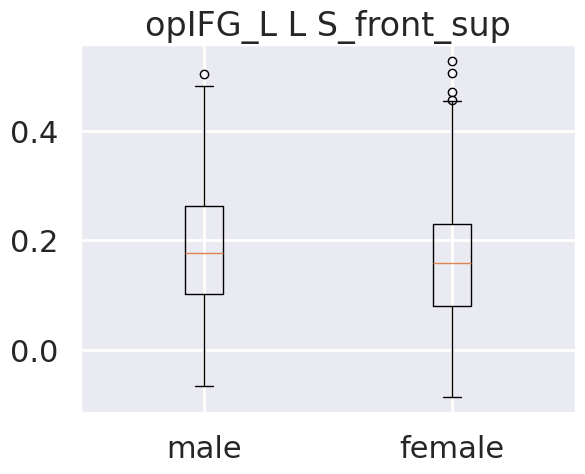

TtestResult(statistic=1.8386086382774387, pvalue=0.06664048715484525, df=444.0)
male mean : 0.18354724924686366
male std : 0.11555029853526483
female mean : 0.16325901403009732
female std : 0.11691880559681884


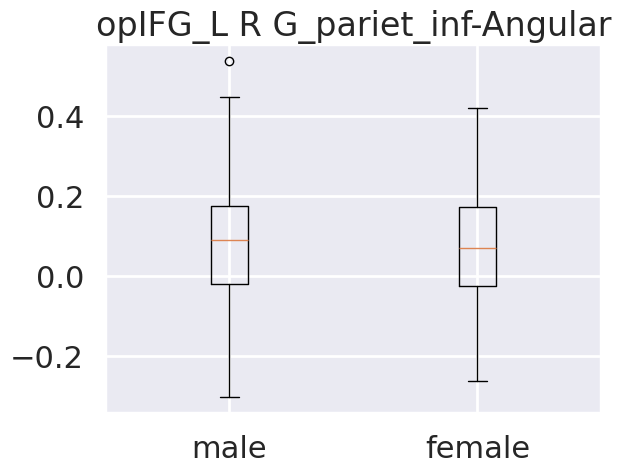

TtestResult(statistic=0.08591139105993699, pvalue=0.9315755833874969, df=444.0)
male mean : 0.07935426715545456
male std : 0.14282449297401265
female mean : 0.0782298258039823
female std : 0.13289471423540014


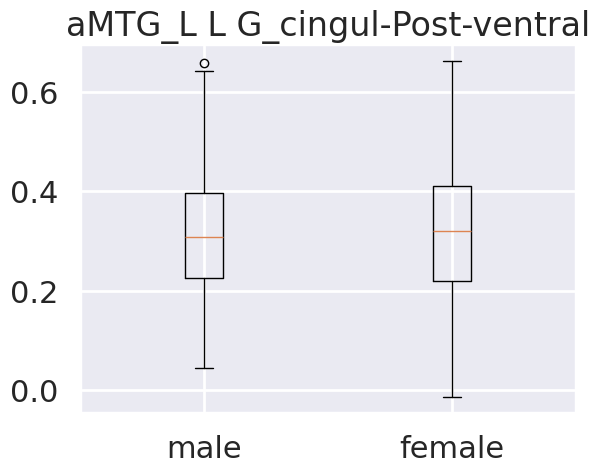

TtestResult(statistic=-0.2833432354183081, pvalue=0.7770458014163131, df=444.0)
male mean : 0.3156455165590909
male std : 0.12565269663262732
female mean : 0.3191625178451328
female std : 0.13555097899256496


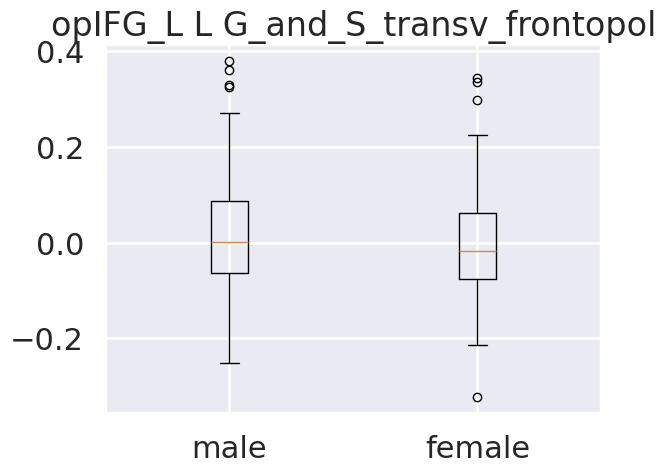

TtestResult(statistic=1.704073217878285, pvalue=0.08906705865566711, df=444.0)
male mean : 0.009279954413181817
male std : 0.11102207207238941
female mean : -0.00782524785345133
female std : 0.10034297686828818


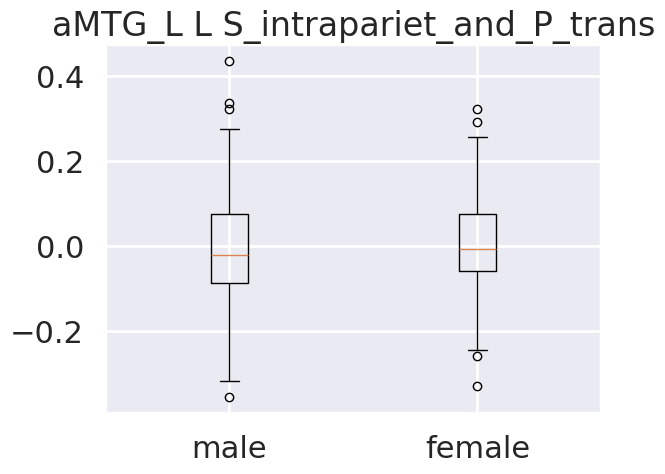

TtestResult(statistic=-0.5629449522849478, pvalue=0.5737565149961763, df=444.0)
male mean : -0.004352947120000001
male std : 0.11992515374089012
female mean : 0.0017103985353982307
female std : 0.10680532923333193


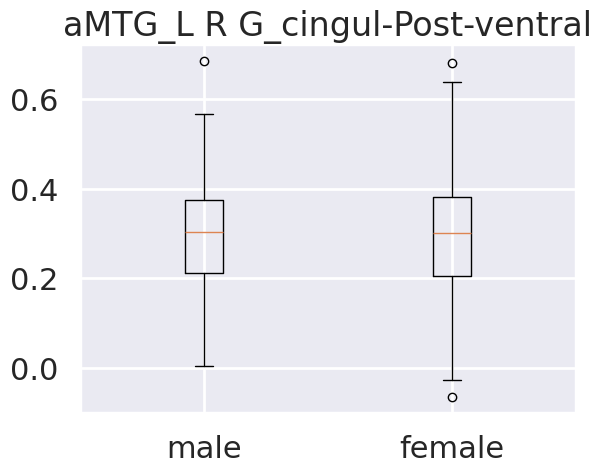

TtestResult(statistic=0.09577378814515201, pvalue=0.9237434466412748, df=444.0)
male mean : 0.2950557834072727
male std : 0.12408889141199957
female mean : 0.2938605092433628
female std : 0.13828653063453986


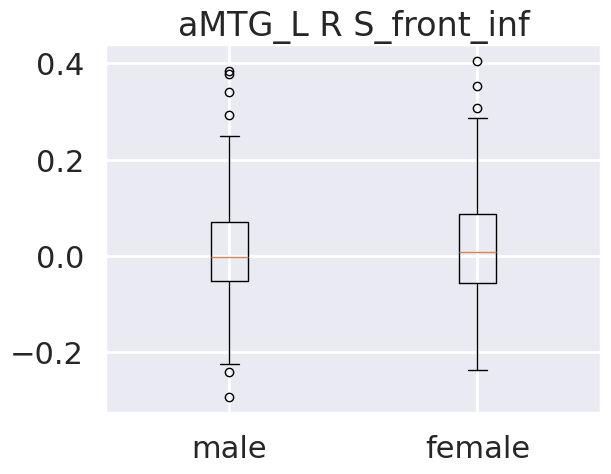

TtestResult(statistic=-1.0344019213226483, pvalue=0.3015113726056777, df=444.0)
male mean : 0.009040113515500001
male std : 0.11214850033551142
female mean : 0.020188220434349556
female std : 0.11487077247082961


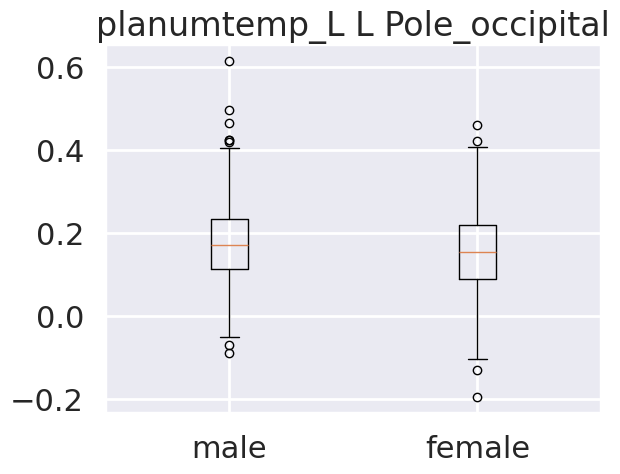

TtestResult(statistic=2.2141217874107335, pvalue=0.027327713783023296, df=444.0)
male mean : 0.18054933812954546
male std : 0.10858214699234862
female mean : 0.1579440344477876
female std : 0.10654581970600939


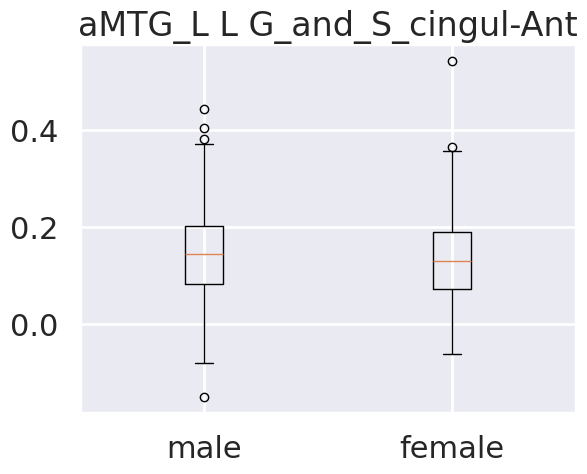

TtestResult(statistic=1.0085696367467436, pvalue=0.31373039303959355, df=444.0)
male mean : 0.14680708949227272
male std : 0.09418184209050703
female mean : 0.1380289428168142
female std : 0.08919625555912179


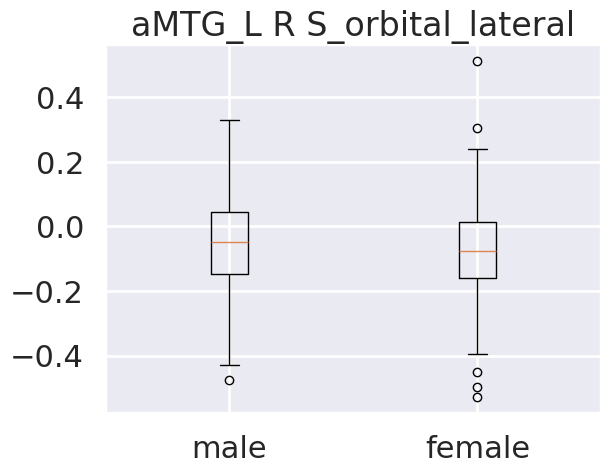

TtestResult(statistic=1.5922683491756897, pvalue=0.11203607391449234, df=444.0)
male mean : -0.05012122668031818
male std : 0.14338070010303233
female mean : -0.07177564318827433
female std : 0.14316029912268322
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [100]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_seed)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## aMTG_L validation accuracy

Validation accuracy
The mean accuracy : 0.6878017857142857
The standard deviation of the accuracy : 0.030430134883962023
The lower boundry of the confidance interval of the accuracy : 0.6281587213417201
The upper boundry of the confidance interval of the accuracy : 0.7474448500868514

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            43.9740  18.0260
Homme            16.9402  33.0598
Mean sensitivity : 0.7225298449467529 Std sensitivity : 0.029493904389839197
Mean specificity : 0.6483918357546864 Std specificity : 0.03694493537740851

Testing accuracy
     coefficient    seed                       labels
53      0.281044  aMTG_L                L S_front_sup
98      0.250923  aMTG_L       R G_pariet_inf-Angular
131     0.183568  aMTG_L   R S_oc_sup_and_transversal
22      0.180551  aMTG_L      L G_oc-temp_med-Parahip
4       0.175986  aMTG_L   L G_and_S_transv_frontopol
104     0.173773  aMTG_L                   R G_rectus
103

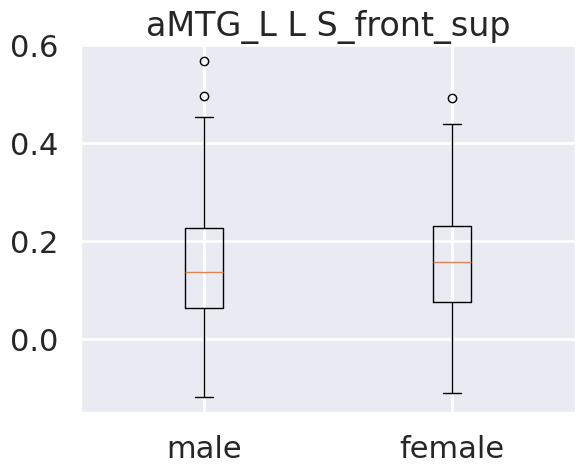

TtestResult(statistic=-1.2115802569709089, pvalue=0.2263175054541827, df=444.0)
male mean : 0.14762299317454547
male std : 0.11688015239448009
female mean : 0.16118036864971239
female std : 0.11884814329470475


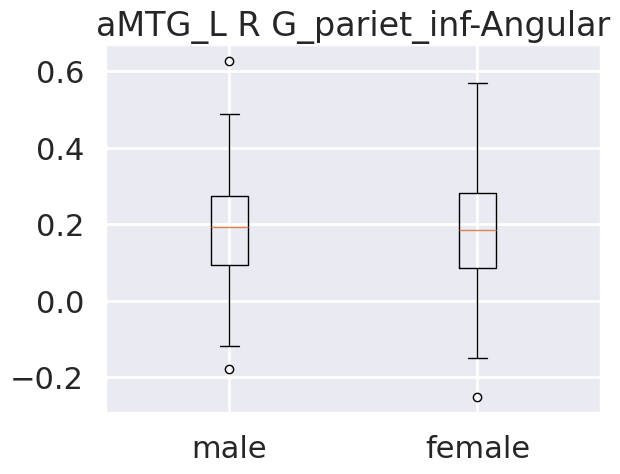

TtestResult(statistic=0.4179103500513543, pvalue=0.6762146978839937, df=444.0)
male mean : 0.18756429426727272
male std : 0.131036991296705
female mean : 0.18222123307212384
female std : 0.13814961112003438


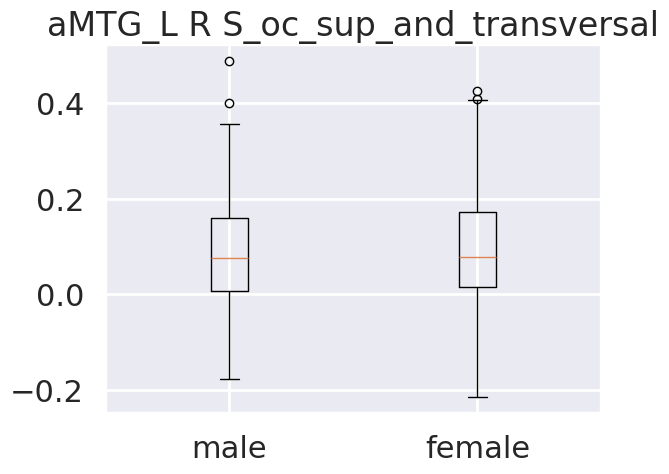

TtestResult(statistic=0.30474889772120906, pvalue=0.7607001988530268, df=444.0)
male mean : 0.08839870560527273
male std : 0.1147720441007127
female mean : 0.0850507582920354
female std : 0.1166615957346304


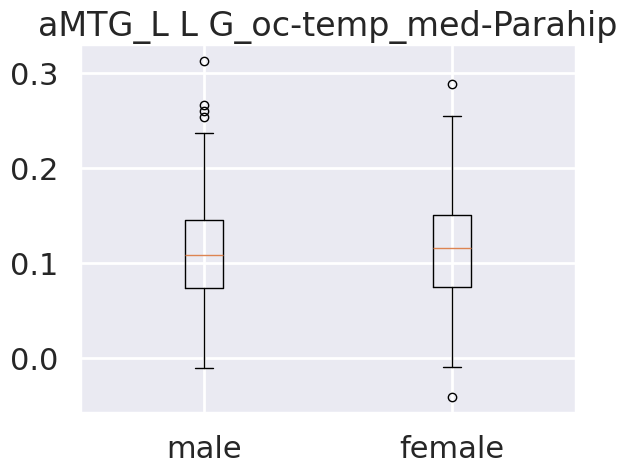

TtestResult(statistic=-0.5325288823497664, pvalue=0.5946261402922963, df=444.0)
male mean : 0.1132523153590909
male std : 0.05409661533112469
female mean : 0.11598545436725663
female std : 0.05404023663358572


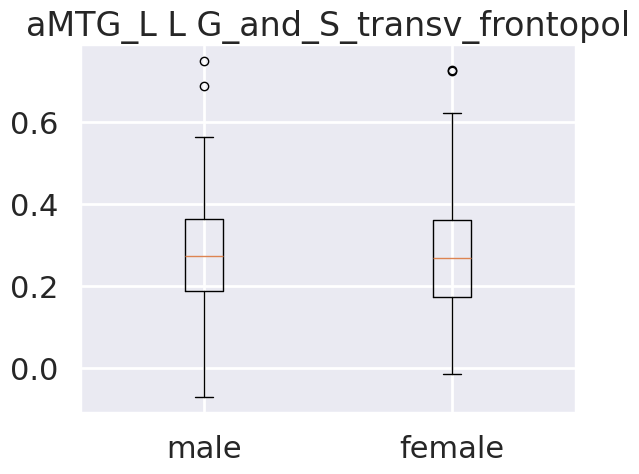

TtestResult(statistic=0.7144775913885814, pvalue=0.475307367024024, df=444.0)
male mean : 0.27915044829545455
male std : 0.13328978310271264
female mean : 0.270030732761062
female std : 0.135602632350119


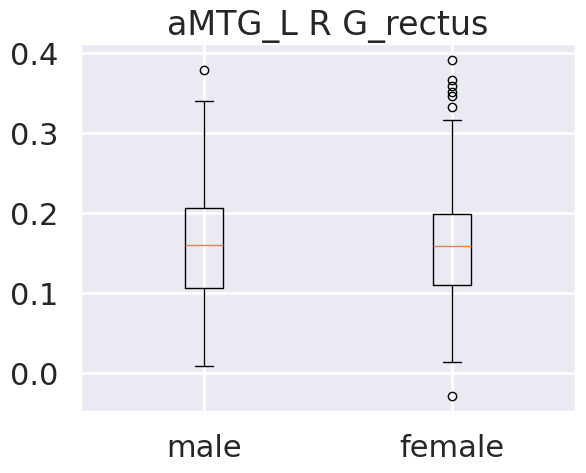

TtestResult(statistic=-0.10159549213792646, pvalue=0.9191236211037616, df=444.0)
male mean : 0.1603763383909091
male std : 0.0667838166130642
female mean : 0.16104586768141593
female std : 0.07190337437275575


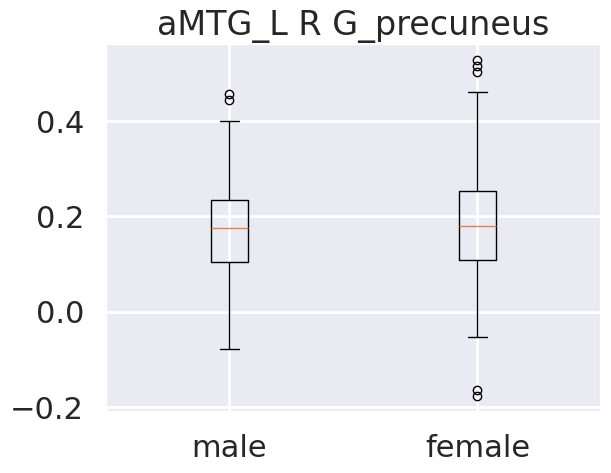

TtestResult(statistic=-0.40499262015766535, pvalue=0.6856779864063001, df=444.0)
male mean : 0.17628389293409089
male std : 0.10298397993898772
female mean : 0.18040916822566372
female std : 0.11135414180003657


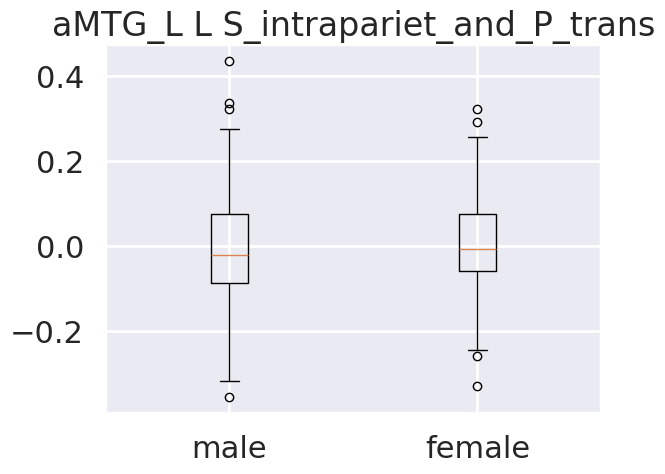

TtestResult(statistic=-0.5629449522849478, pvalue=0.5737565149961763, df=444.0)
male mean : -0.004352947120000001
male std : 0.11992515374089012
female mean : 0.0017103985353982307
female std : 0.10680532923333193


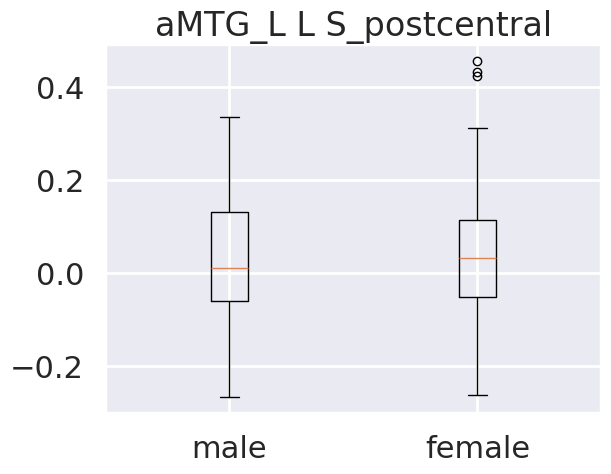

TtestResult(statistic=-0.8254630391644802, pvalue=0.40955205026428354, df=444.0)
male mean : 0.02505200850136364
male std : 0.13212586802743143
female mean : 0.0352003758540708
female std : 0.12692226875426213


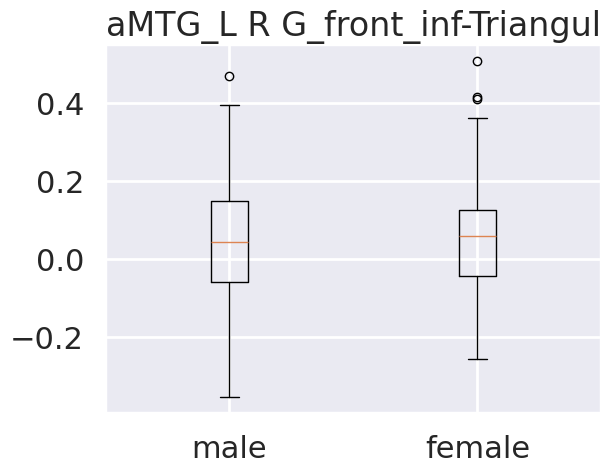

TtestResult(statistic=0.06586375044030267, pvalue=0.9475159463280065, df=444.0)
male mean : 0.049219128189999996
male std : 0.14446793573936256
female mean : 0.04835148825929204
female std : 0.13300199426574477
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [101]:
rois = ["aMTG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_L)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## aMRG_R validation accuracy

Validation accuracy
The mean accuracy : 0.6687901785714286
The standard deviation of the accuracy : 0.032582043899393266
The lower boundry of the confidance interval of the accuracy : 0.6049293725286178
The upper boundry of the confidance interval of the accuracy : 0.7326509846142395

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            41.5573  20.4427
Homme            16.6528  33.3472
Mean sensitivity : 0.7148366001103809 Std sensitivity : 0.033535009011358786
Mean specificity : 0.6211492546608288 Std specificity : 0.0368221178952218

Testing accuracy
     coefficient    seed                       labels
66      0.235741  aMTG_R              L S_postcentral
53      0.235184  aMTG_R                L S_front_sup
22      0.215506  aMTG_R      L G_oc-temp_med-Parahip
98      0.214273  aMTG_R       R G_pariet_inf-Angular
55      0.196734  aMTG_R  L S_intrapariet_and_P_trans
96      0.173958  aMTG_R      R G_oc-temp_med-Parahip
4   

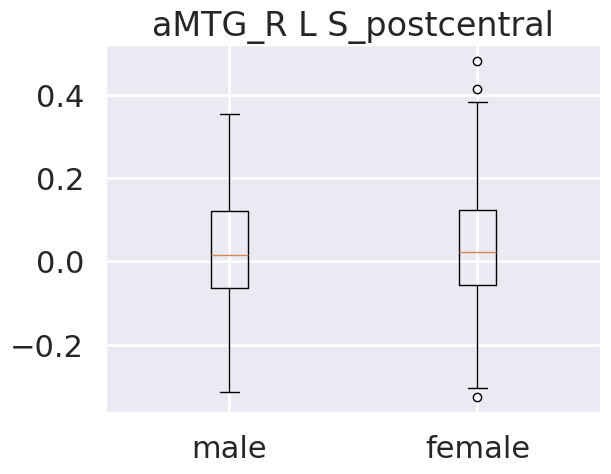

TtestResult(statistic=-1.1640513741205991, pvalue=0.24502831161092486, df=444.0)
male mean : 0.024869018984999998
male std : 0.13083791553890814
female mean : 0.03956135003526549
female std : 0.1350054527718372


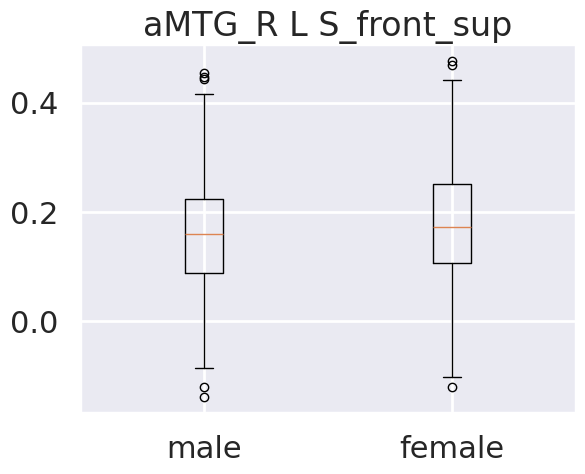

TtestResult(statistic=-1.5664583130918401, pvalue=0.11795375882200275, df=444.0)
male mean : 0.1639319401981364
male std : 0.1082806698802484
female mean : 0.18019807714026548
female std : 0.11046417292654283


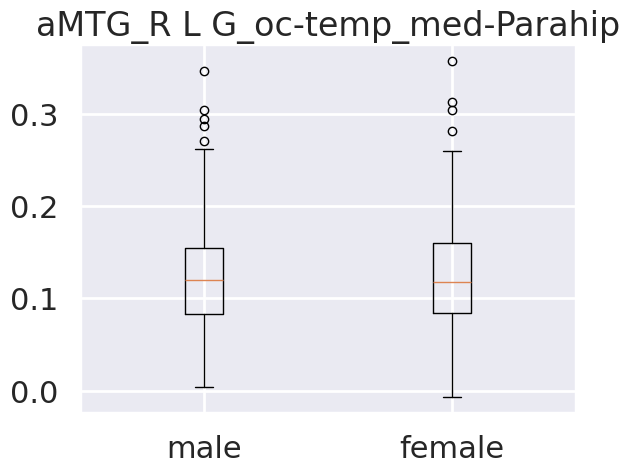

TtestResult(statistic=0.236157422237291, pvalue=0.8134194177992647, df=444.0)
male mean : 0.12669131177454543
male std : 0.05789178132233646
female mean : 0.12539075617035397
female std : 0.05813712078976924


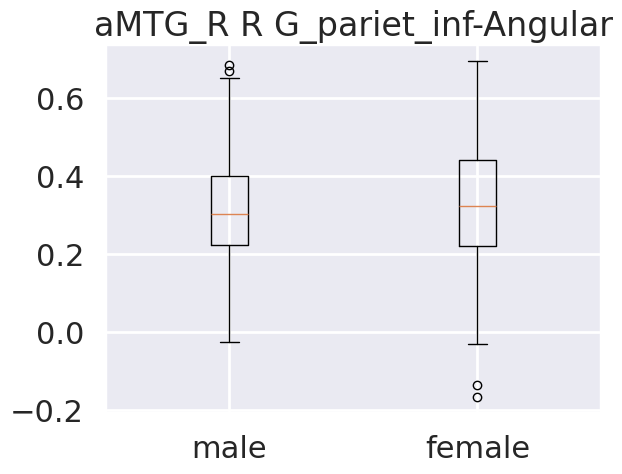

TtestResult(statistic=-0.4232827448696727, pvalue=0.6722939356579549, df=444.0)
male mean : 0.3142547134304546
male std : 0.13922671906337197
female mean : 0.32020972021548666
female std : 0.156457832134548


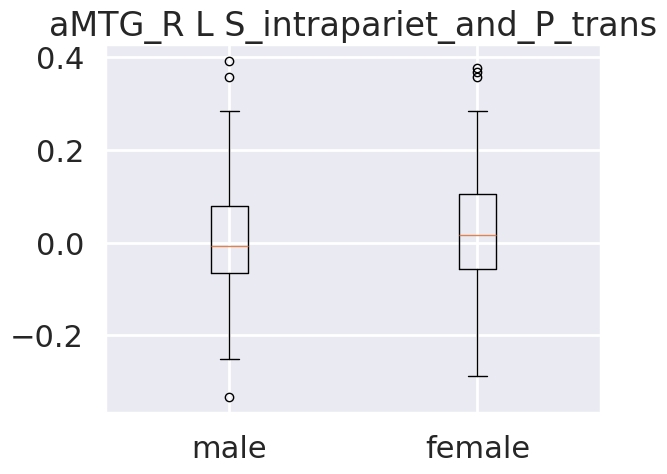

TtestResult(statistic=-1.409706247156657, pvalue=0.1593265024127508, df=444.0)
male mean : 0.0051525473381363604
male std : 0.11358963099658818
female mean : 0.020574686161504426
female std : 0.1168422000095749


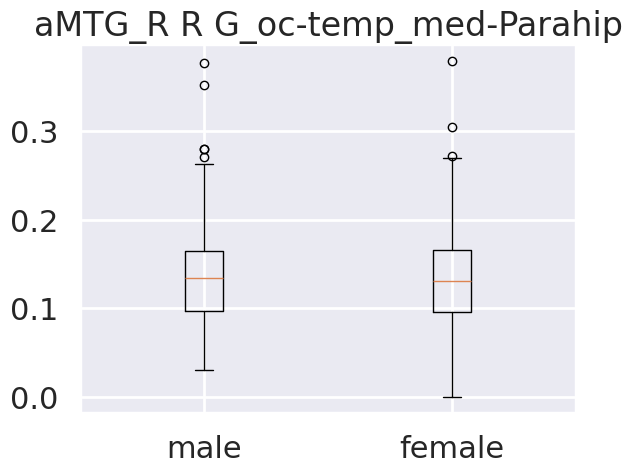

TtestResult(statistic=0.38349633258891414, pvalue=0.7015353473449857, df=444.0)
male mean : 0.13827192803636365
male std : 0.056839411334303425
female mean : 0.13617762669402655
female std : 0.05819587400842339


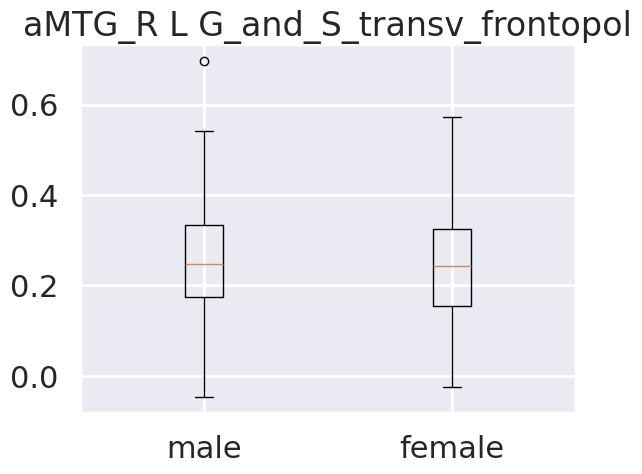

TtestResult(statistic=0.5337028010794159, pvalue=0.59381424809252, df=444.0)
male mean : 0.25033558718590904
male std : 0.1176572351734413
female mean : 0.24428394915265486
female std : 0.12117477403861707


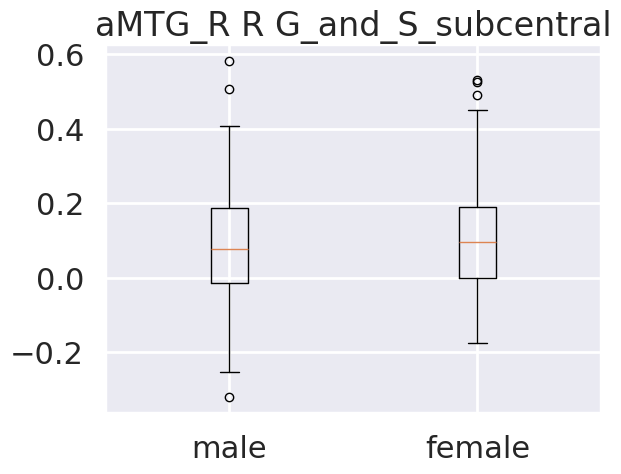

TtestResult(statistic=-1.2532252660322003, pvalue=0.21078328908154395, df=444.0)
male mean : 0.08824721561363635
male std : 0.14095604045910376
female mean : 0.10516873683029646
female std : 0.14348569460343674


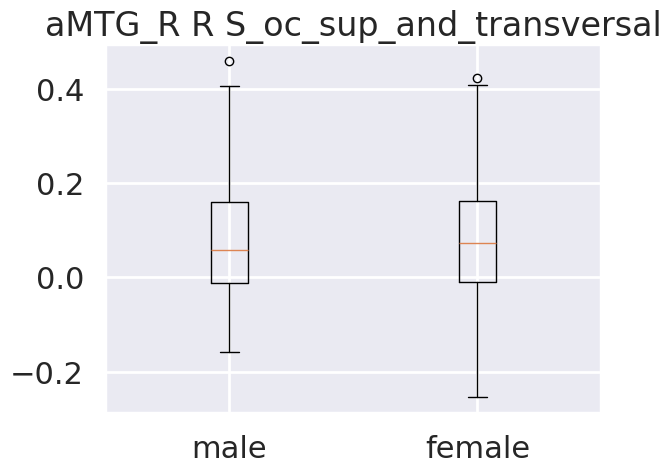

TtestResult(statistic=-0.6816141722659632, pvalue=0.49583832530371075, df=444.0)
male mean : 0.0746124765559091
male std : 0.11744129351142867
female mean : 0.08266218956327434
female std : 0.13084232907159066


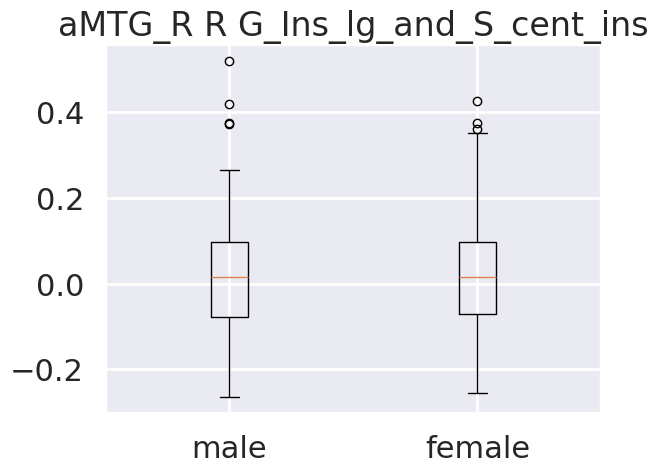

TtestResult(statistic=-0.22044697190158885, pvalue=0.825624394898167, df=444.0)
male mean : 0.01688882336909091
male std : 0.1271698366083748
female mean : 0.019493625555884957
female std : 0.12180061152102561
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [102]:
rois = ["aMTG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_aMTG_R)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## opIFG_L validation accuracy

Validation accuracy
The mean accuracy : 0.6940196428571428
The standard deviation of the accuracy : 0.030538335257191282
The lower boundry of the confidance interval of the accuracy : 0.6341645057530478
The upper boundry of the confidance interval of the accuracy : 0.7538747799612378

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            43.2005  18.7995
Homme            15.4703  34.5297
Mean sensitivity : 0.7367119038083971 Std sensitivity : 0.027888917028889758
Mean specificity : 0.6492900895528839 Std specificity : 0.03803593428104327

Testing accuracy
     coefficient     seed                       labels
125     0.202689  opIFG_L                R S_front_inf
20      0.200376  opIFG_L      L G_oc-temp_lat-fusifor
35      0.190572  opIFG_L      L G_temp_sup-Plan_tempo
144     0.189744  opIFG_L              R S_subparietal
91      0.188180  opIFG_L            R G_insular_short
79      0.158492  opIFG_L         R G_and_S_cingul-

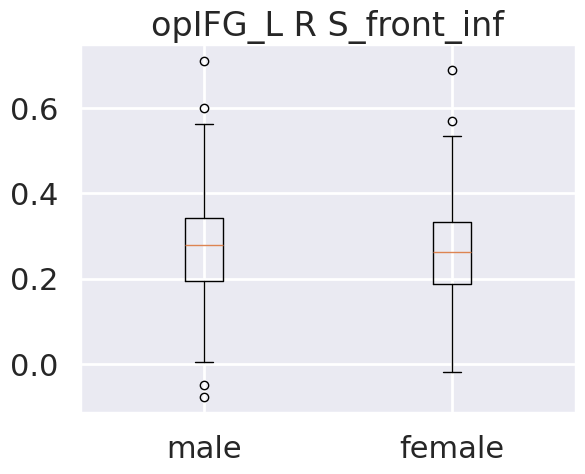

TtestResult(statistic=0.4915695057620733, pvalue=0.6232666210046246, df=444.0)
male mean : 0.26700118899545455
male std : 0.11830244448245875
female mean : 0.26163575809292033
female std : 0.11166135854260843


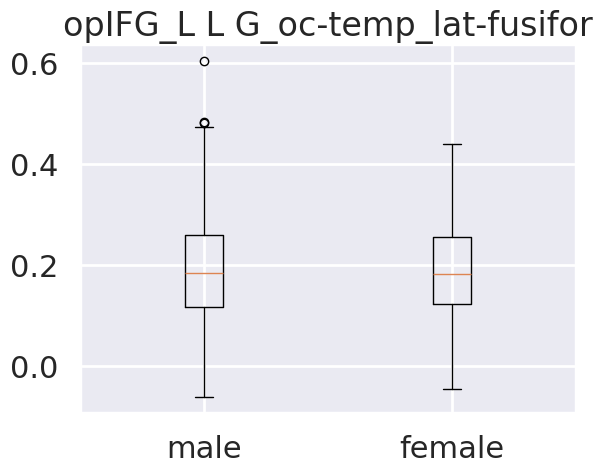

TtestResult(statistic=0.5192015204184673, pvalue=0.6038789204517058, df=444.0)
male mean : 0.1940983459488636
male std : 0.11200001469732601
female mean : 0.18902279729823013
female std : 0.09337458622335229


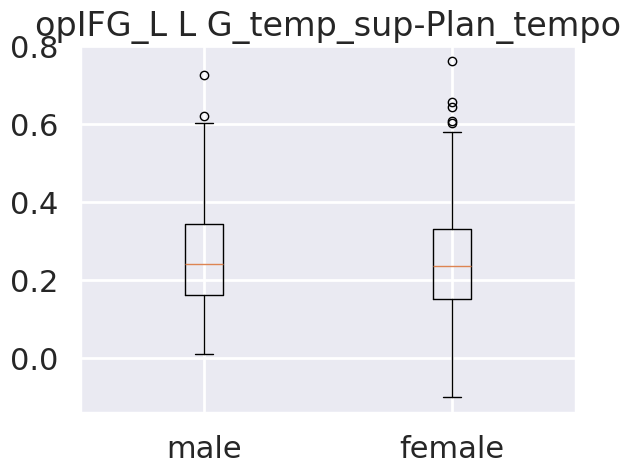

TtestResult(statistic=0.6213060288834897, pvalue=0.5347171316983141, df=444.0)
male mean : 0.2601838246818182
male std : 0.13041436272465887
female mean : 0.25200619504867255
female std : 0.14623656983715244


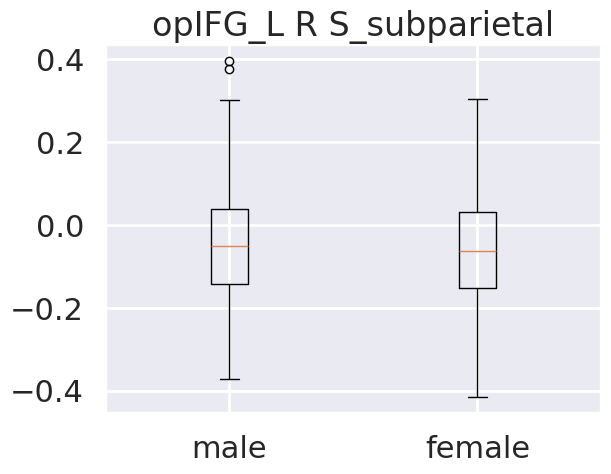

TtestResult(statistic=1.7391634132444183, pvalue=0.08269908820236846, df=444.0)
male mean : -0.04258604435452273
male std : 0.13898561840228374
female mean : -0.06453867240132743
female std : 0.1268496208152823


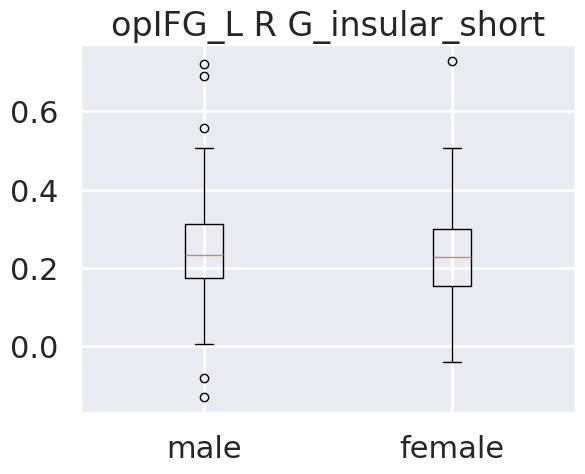

TtestResult(statistic=0.9067239038419802, pvalue=0.36504463339847837, df=444.0)
male mean : 0.24628885791363642
male std : 0.11709590021523666
female mean : 0.23638866999115044
female std : 0.11297172669965401


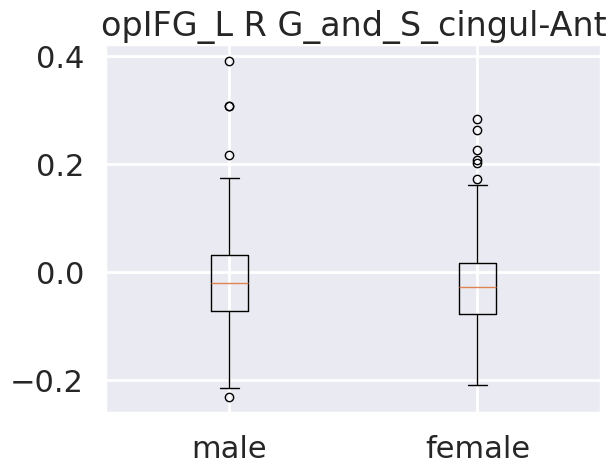

TtestResult(statistic=0.9352934369587438, pvalue=0.35014549704521825, df=444.0)
male mean : -0.01618588559709091
male std : 0.08989493115128637
female mean : -0.023699539482654866
female std : 0.07916971759856868


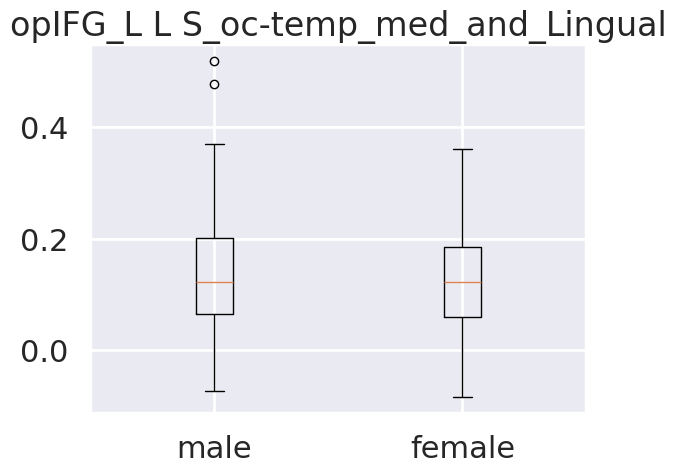

TtestResult(statistic=0.8482871359411982, pvalue=0.3967351597135216, df=444.0)
male mean : 0.13462001977722726
male std : 0.09808758650556429
female mean : 0.1272581053141593
female std : 0.0844381182747298


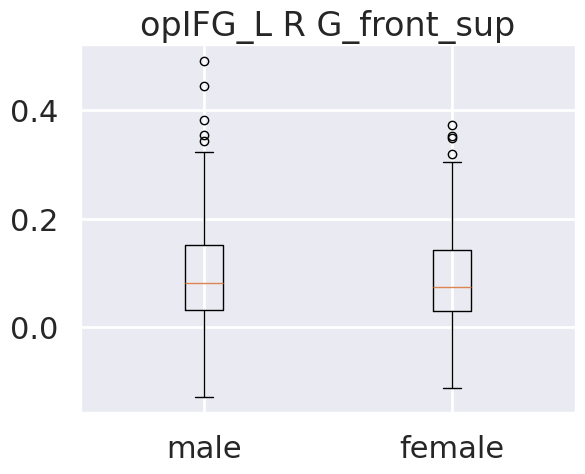

TtestResult(statistic=1.1915595985799283, pvalue=0.23407051044287677, df=444.0)
male mean : 0.09908702246555909
male std : 0.09748109702477784
female mean : 0.08866071840106193
female std : 0.08670894152437802


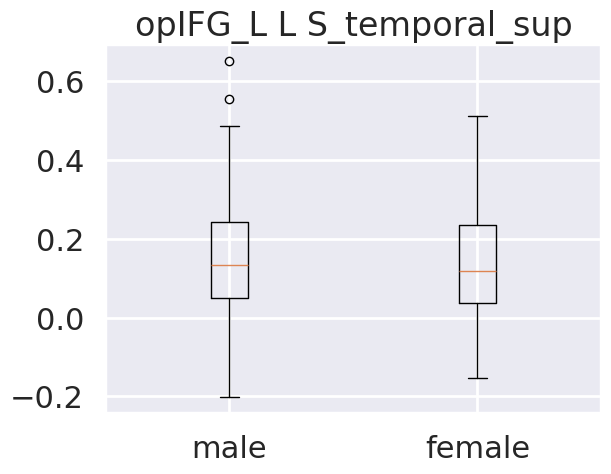

TtestResult(statistic=0.7755817266065361, pvalue=0.4384088867429513, df=444.0)
male mean : 0.15023836449931818
male std : 0.13752547518252983
female mean : 0.14016238799115044
female std : 0.13621233667136962


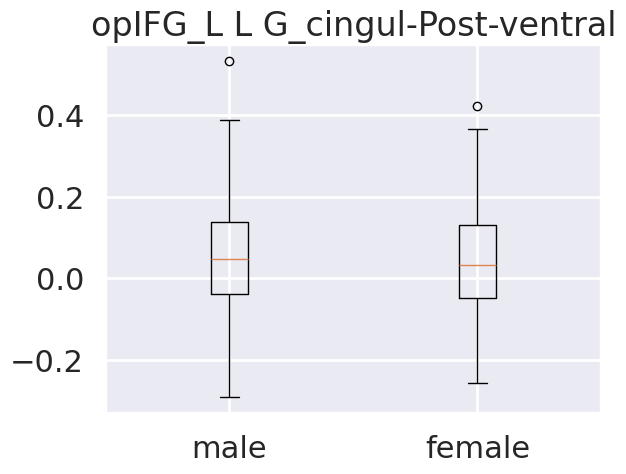

TtestResult(statistic=0.7310977037783218, pvalue=0.4651051172517302, df=444.0)
male mean : 0.05370966553863637
male std : 0.13821620868703405
female mean : 0.04442369016349557
female std : 0.129367732267586
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [103]:
rois = ["opIFG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_L)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## opIFG_R validation accuracy

Validation accuracy
The mean accuracy : 0.6548526785714286
The standard deviation of the accuracy : 0.032209885159822114
The lower boundry of the confidance interval of the accuracy : 0.5917213036581772
The upper boundry of the confidance interval of the accuracy : 0.71798405348468

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            41.9849  20.0151
Homme            18.6414  31.3586
Mean sensitivity : 0.6934755091709768 Std sensitivity : 0.031987495541884785
Mean specificity : 0.6119239601686499 Std specificity : 0.0385823736950234

Testing accuracy
     coefficient     seed                       labels
125     0.234703  opIFG_R                R S_front_inf
80      0.224280  opIFG_R     R G_and_S_cingul-Mid-Ant
91      0.181864  opIFG_R            R G_insular_short
144     0.168338  opIFG_R              R S_subparietal
20      0.165930  opIFG_R      L G_oc-temp_lat-fusifor
90      0.165617  opIFG_R    R G_Ins_lg_and_S_cent_ins

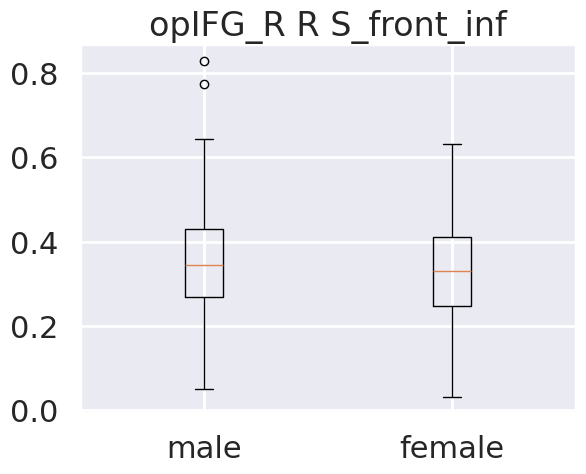

TtestResult(statistic=1.677478419338587, pvalue=0.0941527311664062, df=444.0)
male mean : 0.3493236941545455
male std : 0.12594814592383247
female mean : 0.33014065035840706
female std : 0.1148888720611889


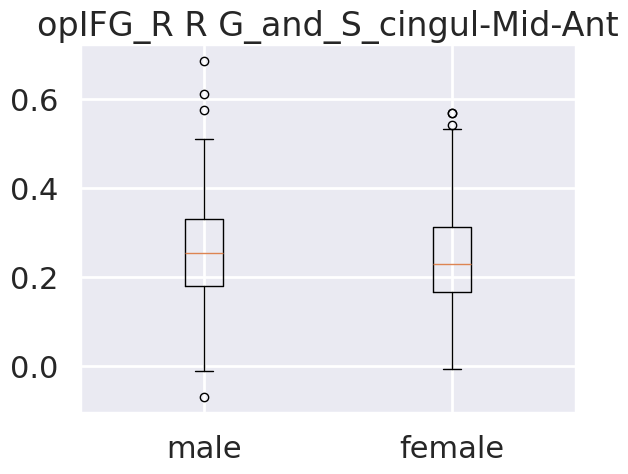

TtestResult(statistic=1.4220769007548189, pvalue=0.15570601664653622, df=444.0)
male mean : 0.26201838397727273
male std : 0.11680459863257632
female mean : 0.2463068751438053
female std : 0.11598569074736187


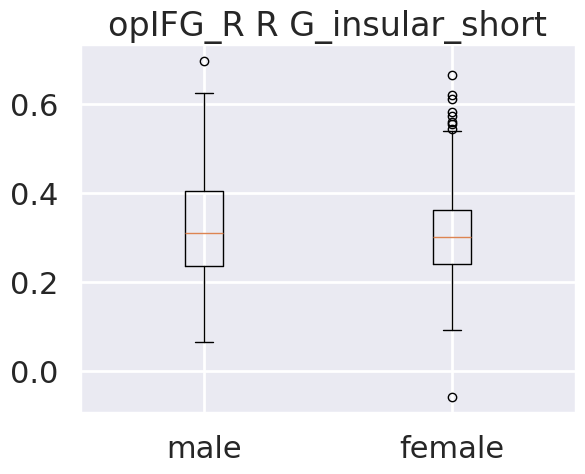

TtestResult(statistic=1.1876450875867164, pvalue=0.2356082192599735, df=444.0)
male mean : 0.3226060065636363
male std : 0.11264272452127146
female mean : 0.3099531391858407
female std : 0.11183470415014414


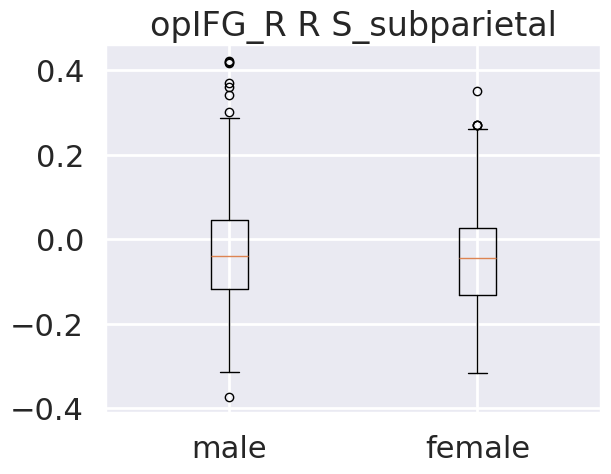

TtestResult(statistic=1.4280992707788773, pvalue=0.1539662979049357, df=444.0)
male mean : -0.02669799280472727
male std : 0.13997954487219721
female mean : -0.04441074100570796
female std : 0.12090433979084553


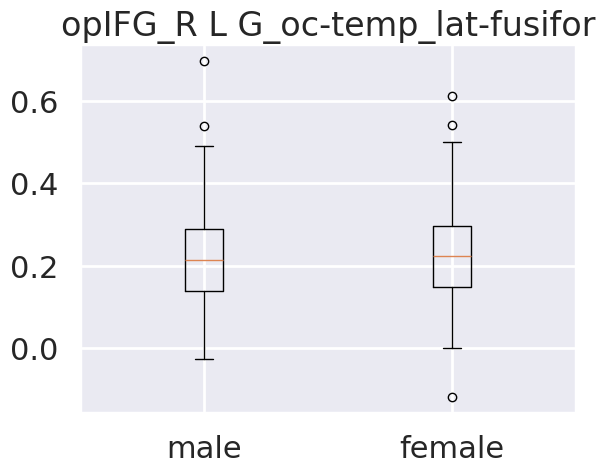

TtestResult(statistic=-0.9901442067517153, pvalue=0.3226429184512092, df=444.0)
male mean : 0.21643367910909092
male std : 0.1098183379873906
female mean : 0.2264770848318584
female std : 0.10389411762066779


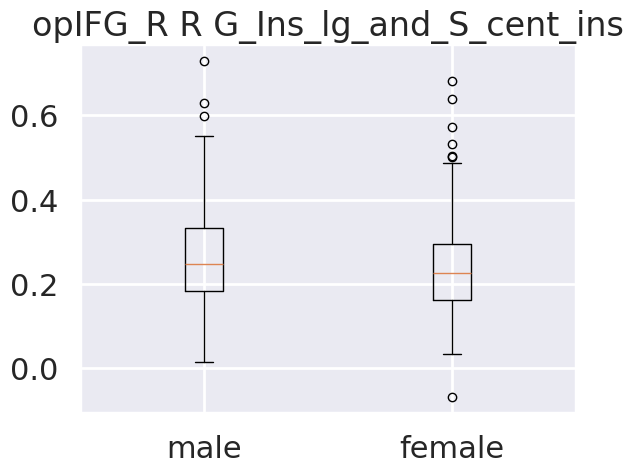

TtestResult(statistic=1.5032319765907831, pvalue=0.13349015197916975, df=444.0)
male mean : 0.2560846500727273
male std : 0.11677802001475575
female mean : 0.23962584481415927
female std : 0.11393043911461521


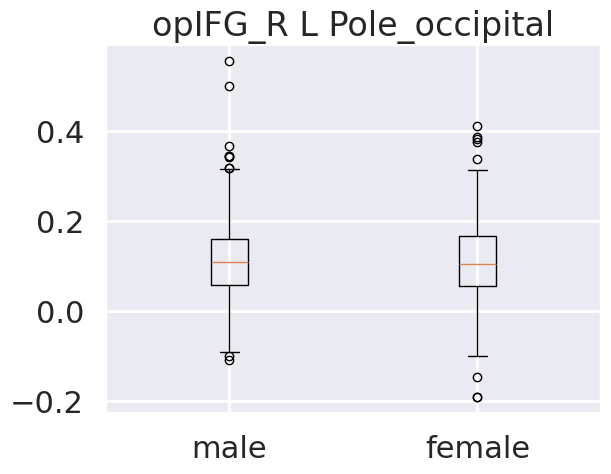

TtestResult(statistic=0.7247810761382535, pvalue=0.4689681169166011, df=444.0)
male mean : 0.1170176840959091
male std : 0.09457281950712053
female mean : 0.11049183997579647
female std : 0.09512536430262356


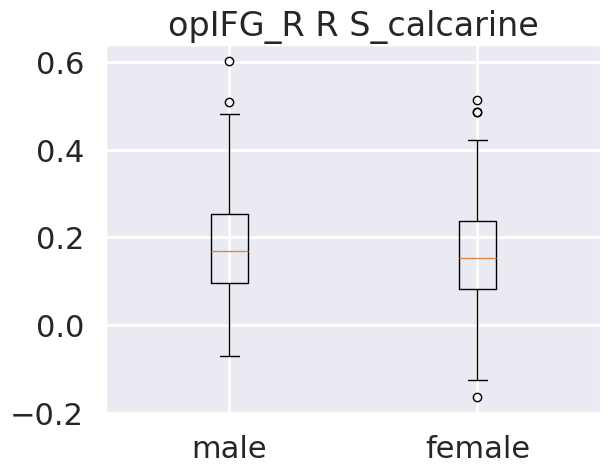

TtestResult(statistic=0.9747216383281959, pvalue=0.3302290972981793, df=444.0)
male mean : 0.1753950030236364
male std : 0.11110288916927817
female mean : 0.1652581727544248
female std : 0.10803273494292392


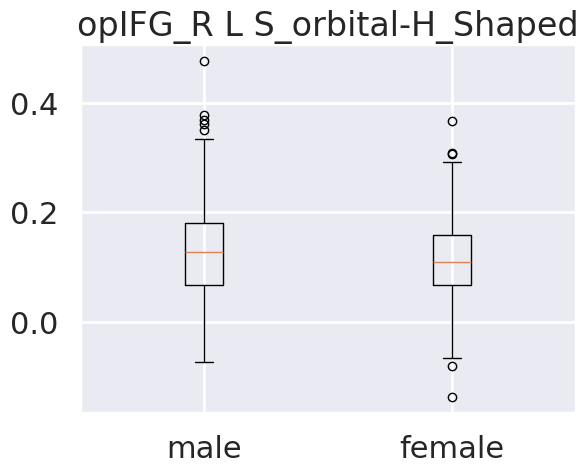

TtestResult(statistic=2.0532652593810847, pvalue=0.04063217634906046, df=444.0)
male mean : 0.12819354256818183
male std : 0.08764783205257284
female mean : 0.11203503897743362
female std : 0.07801062367094556


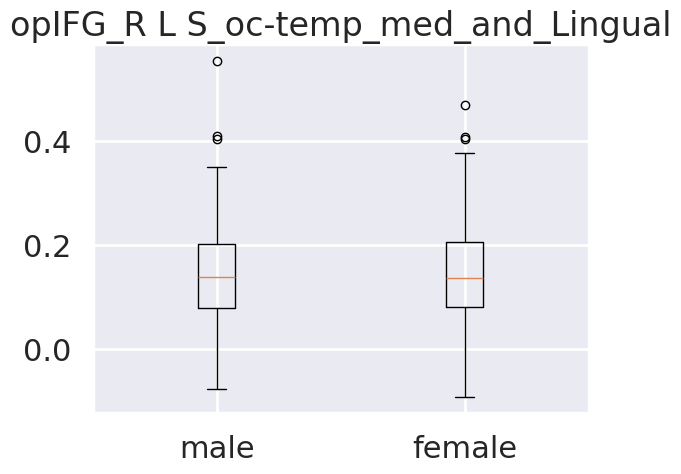

TtestResult(statistic=-0.360244458914998, pvalue=0.7188356351459093, df=444.0)
male mean : 0.1422618793368182
male std : 0.094818195761141
female mean : 0.14546593415398232
female std : 0.09259215543692742
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [104]:
rois = ["opIFG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_opIFG_R)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()



acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## pITG_L validation accuracy

Validation accuracy
The mean accuracy : 0.6420401785714285
The standard deviation of the accuracy : 0.029524732030938475
The lower boundry of the confidance interval of the accuracy : 0.5841717037907891
The upper boundry of the confidance interval of the accuracy : 0.6999086533520679

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            39.2558  22.7442
Homme            17.3473  32.6527
Mean sensitivity : 0.6940256600463537 Std sensitivity : 0.028890564810567537
Mean specificity : 0.5906843163587344 Std specificity : 0.03297372694426916

Testing accuracy
     coefficient    seed                       labels
26      0.258569  pITG_L             L G_parietal_sup
125     0.251404  pITG_L                R S_front_inf
9       0.229381  pITG_L      L G_cingul-Post-ventral
73      0.196164  pITG_L      L S_temporal_transverse
20      0.178793  pITG_L      L G_oc-temp_lat-fusifor
75      0.174681  pITG_L      R G_and_S_occipital_inf
83 

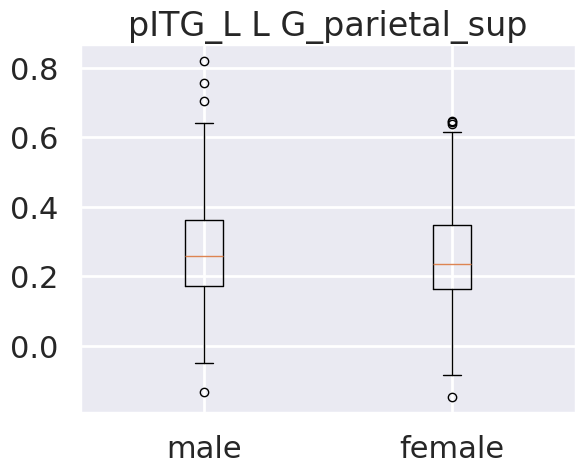

TtestResult(statistic=1.2775594744972645, pvalue=0.20207239044999334, df=444.0)
male mean : 0.26957147712954543
male std : 0.15651594183037884
female mean : 0.2514996581647345
female std : 0.14134056453004967


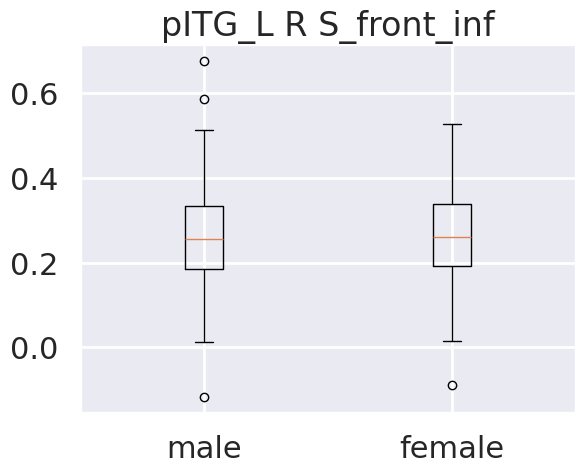

TtestResult(statistic=-0.3898606326263292, pvalue=0.6968265500966664, df=444.0)
male mean : 0.26279526316363633
male std : 0.11384920271212329
female mean : 0.26681815073893805
female std : 0.10345257020535056


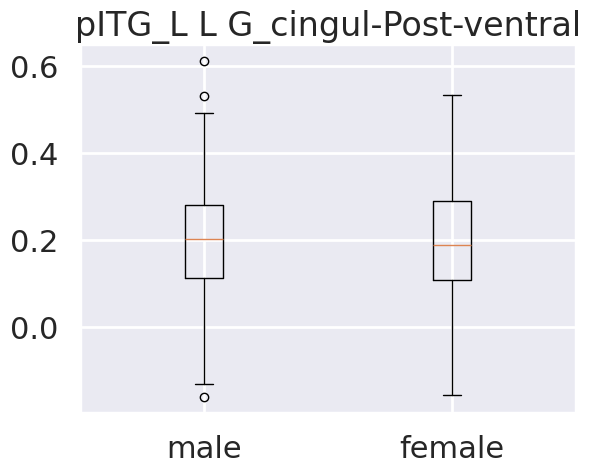

TtestResult(statistic=0.2660541577516194, pvalue=0.7903210003797976, df=444.0)
male mean : 0.20205080604545456
male std : 0.12422614125501692
female mean : 0.19888707633584068
female std : 0.1262803600581341


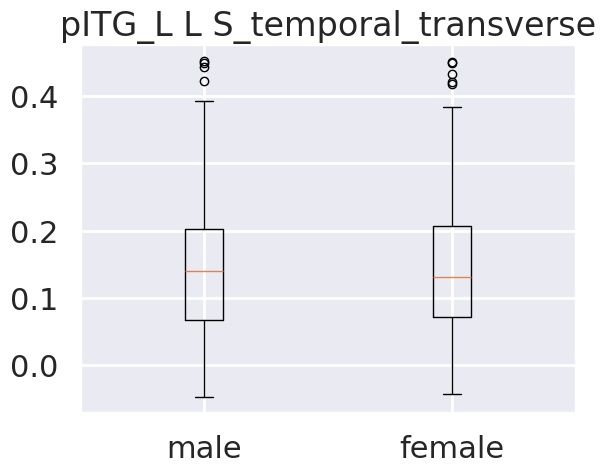

TtestResult(statistic=-0.005337239038893681, pvalue=0.9957439167530718, df=444.0)
male mean : 0.14612400199772727
male std : 0.10120385211558387
female mean : 0.14617460060132745
female std : 0.09855836662586634


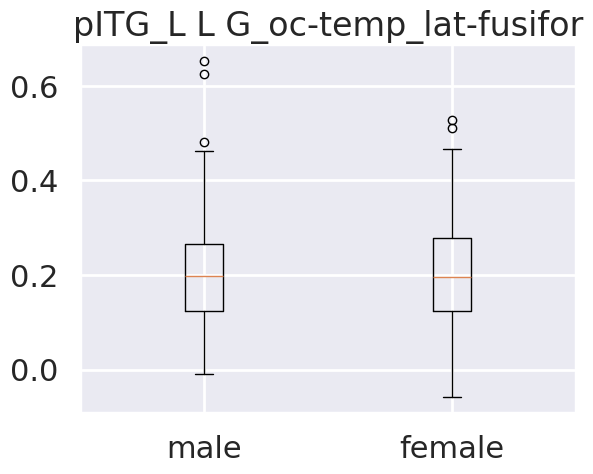

TtestResult(statistic=-0.3523231328642132, pvalue=0.724763114132243, df=444.0)
male mean : 0.19990744190772727
male std : 0.10649609252080425
female mean : 0.20348736029646017
female std : 0.10757072354747603


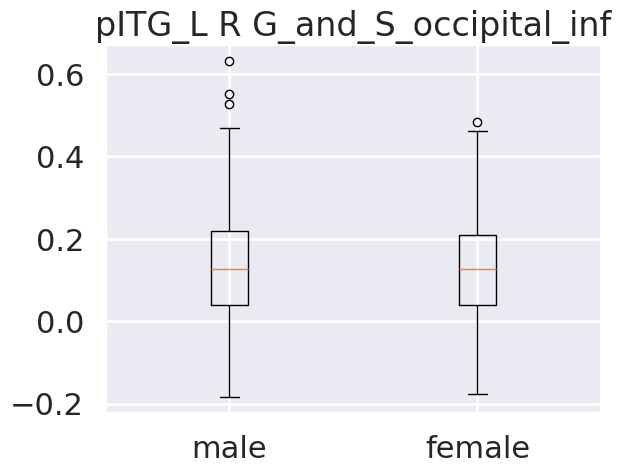

TtestResult(statistic=0.001970963289310874, pvalue=0.9984282850650938, df=444.0)
male mean : 0.13228784757036363
male std : 0.134596850044891
female mean : 0.13226327636283183
female std : 0.1280736610401677


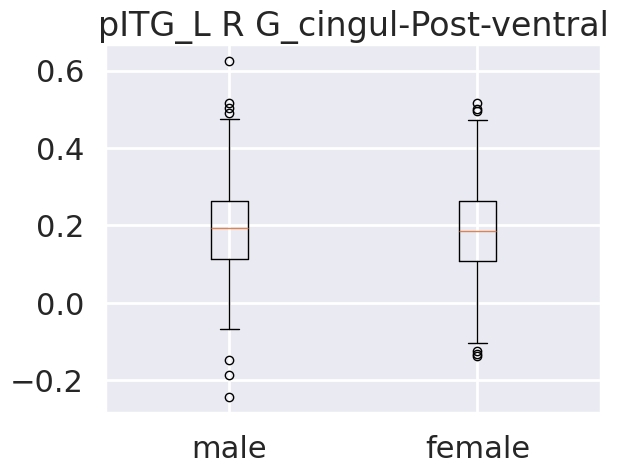

TtestResult(statistic=0.1294323294585559, pvalue=0.8970741805394739, df=444.0)
male mean : 0.18757393837099998
male std : 0.12519042209193637
female mean : 0.18603045791150444
female std : 0.12604914997701686


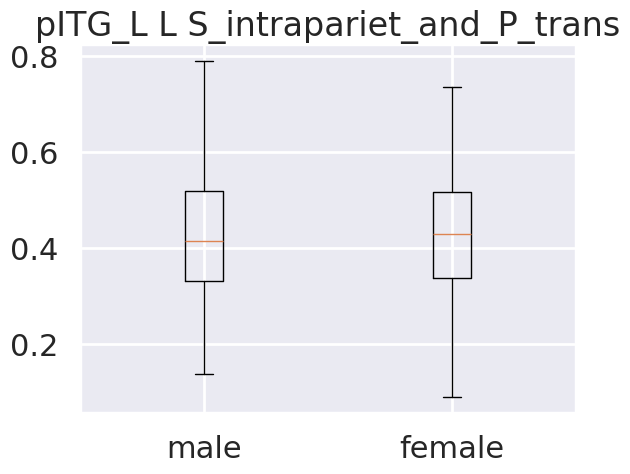

TtestResult(statistic=0.15169777175234894, pvalue=0.8794942172965604, df=444.0)
male mean : 0.42759644404545455
male std : 0.1302837656549137
female mean : 0.42571565088938057
female std : 0.130931286829129


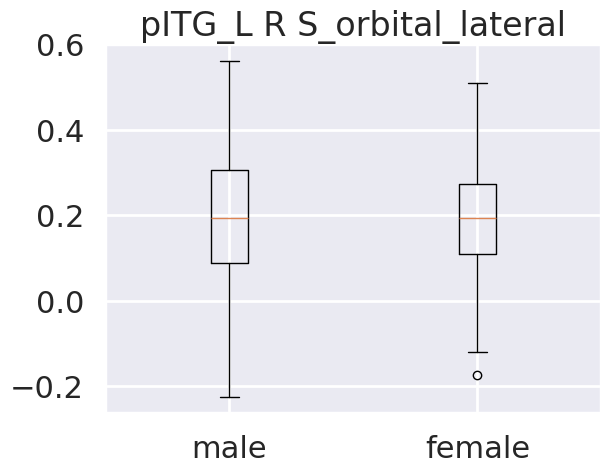

TtestResult(statistic=0.8149138002743364, pvalue=0.41555854201489295, df=444.0)
male mean : 0.19726935004318183
male std : 0.15445023561216564
female mean : 0.18631764366384954
female std : 0.1278057829390902


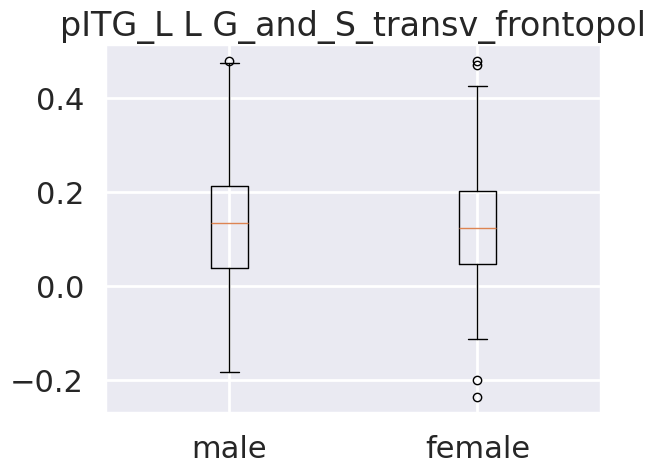

TtestResult(statistic=0.46036528274534155, pvalue=0.6454794277195661, df=444.0)
male mean : 0.13329592038227273
male std : 0.11925893213609366
female mean : 0.12810292579955754
female std : 0.11841713705097008
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [105]:
rois = ["pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_L)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()



acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## pITG_R validation accuracy

Validation accuracy
The mean accuracy : 0.6769830357142856
The standard deviation of the accuracy : 0.026632076629139478
The lower boundry of the confidance interval of the accuracy : 0.6247841655211722
The upper boundry of the confidance interval of the accuracy : 0.7291819059073991

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            43.4636  18.5364
Homme            17.6415  32.3585
Mean sensitivity : 0.7121188127201378 Std sensitivity : 0.026923144322169322
Mean specificity : 0.6371372145822212 Std specificity : 0.033218754844334966

Testing accuracy
     coefficient    seed                    labels
20      0.317350  pITG_R   L G_oc-temp_lat-fusifor
83      0.207225  pITG_R   R G_cingul-Post-ventral
91      0.203452  pITG_R         R G_insular_short
84      0.195611  pITG_R                R G_cuneus
125     0.194242  pITG_R             R S_front_inf
72      0.162033  pITG_R          L S_temporal_sup
80      0.158161  pITG_

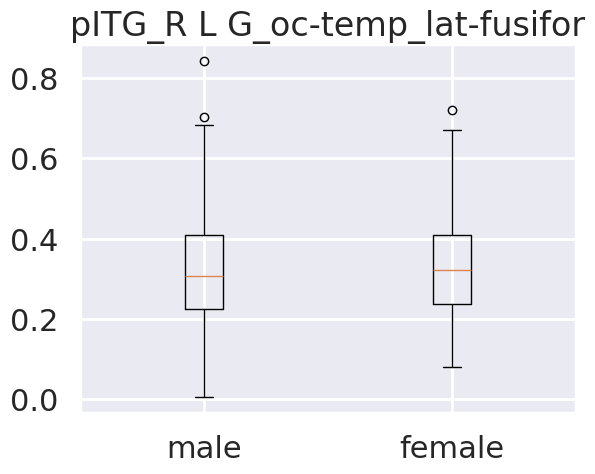

TtestResult(statistic=0.05559392250265574, pvalue=0.9556903136777086, df=444.0)
male mean : 0.3245795496704546
male std : 0.1395229674314357
female mean : 0.3238852111902655
female std : 0.12334245836892097


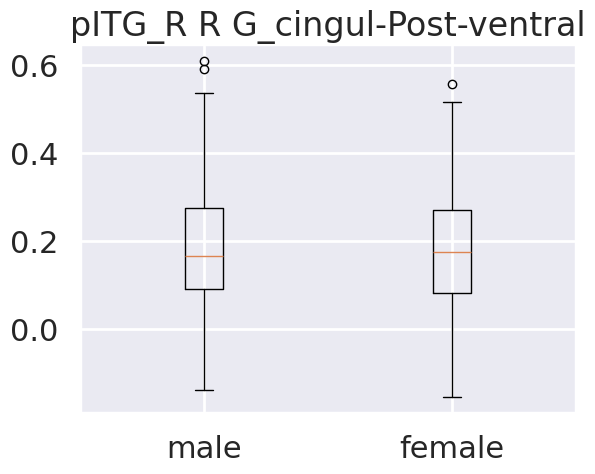

TtestResult(statistic=0.785990140622887, pvalue=0.43229252128733386, df=444.0)
male mean : 0.18269896478363637
male std : 0.14035311890865013
female mean : 0.17262970177920356
female std : 0.1294930282265483


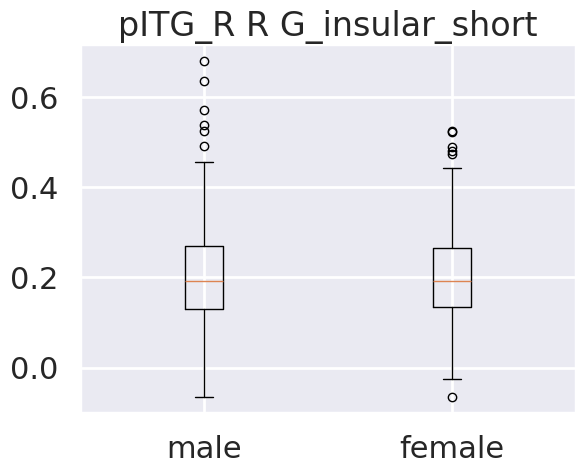

TtestResult(statistic=0.8163020504977502, pvalue=0.4147651343472084, df=444.0)
male mean : 0.2093050060027273
male std : 0.11681287896829293
female mean : 0.20074869443893806
female std : 0.1038248281853224


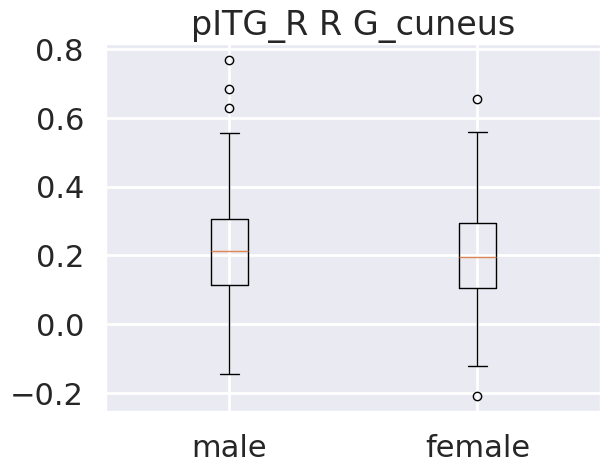

TtestResult(statistic=1.3083005997969617, pvalue=0.19144823693347288, df=444.0)
male mean : 0.21826787766727268
male std : 0.15102719800260528
female mean : 0.20021428982522121
female std : 0.1396453522401376


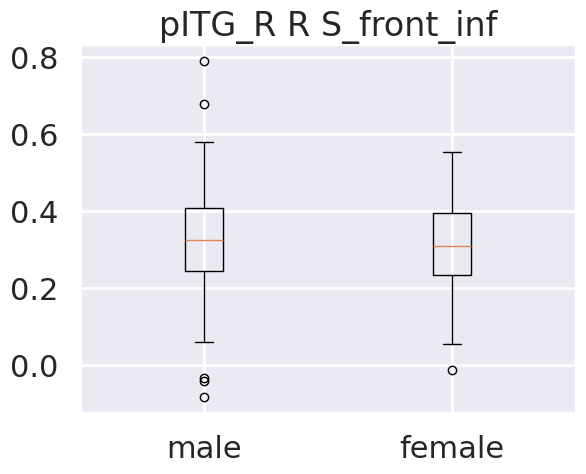

TtestResult(statistic=0.9656486526414011, pvalue=0.33474568366703705, df=444.0)
male mean : 0.32347226276818175
male std : 0.12120613574129573
female mean : 0.31306270038053097
female std : 0.10559196989800743


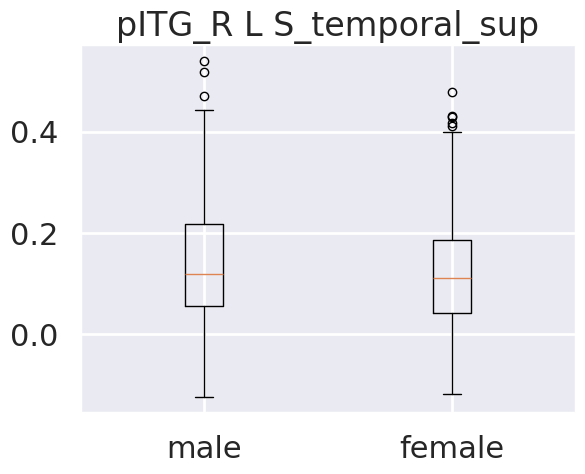

TtestResult(statistic=1.5050070186703721, pvalue=0.13303329591953397, df=444.0)
male mean : 0.13899118274863637
male std : 0.12237326089783937
female mean : 0.12194715708252213
female std : 0.11623887033473576


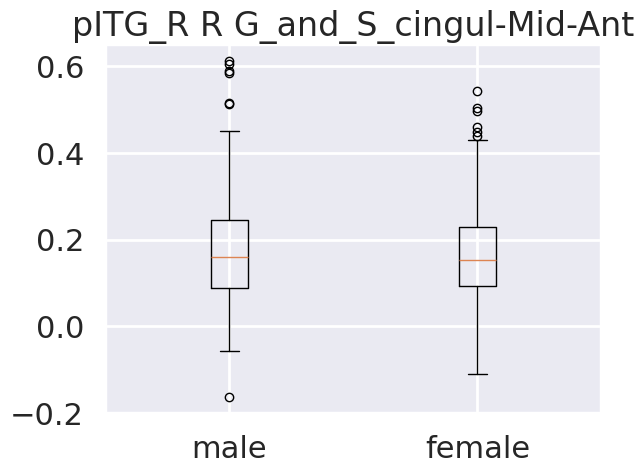

TtestResult(statistic=1.0558101625802878, pvalue=0.2916291029448552, df=444.0)
male mean : 0.17737232453545454
male std : 0.12719566858702955
female mean : 0.16530410570309734
female std : 0.11342504272797906


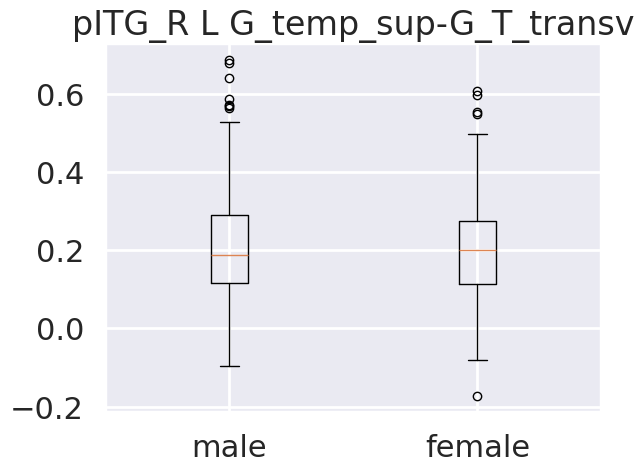

TtestResult(statistic=1.1334980599891324, pvalue=0.25761682087791904, df=444.0)
male mean : 0.21854762269136363
male std : 0.1406931484250914
female mean : 0.20409741841460177
female std : 0.12776928694525597


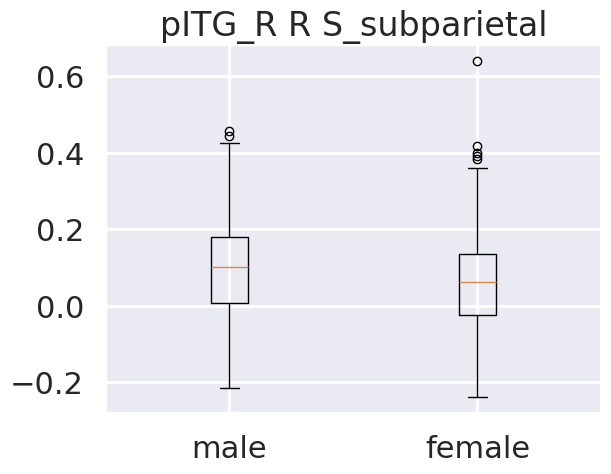

TtestResult(statistic=2.738549534420275, pvalue=0.006419310696767007, df=444.0)
male mean : 0.09850868294845455
male std : 0.13066100232363725
female mean : 0.06406320555544248
female std : 0.13427662772014276


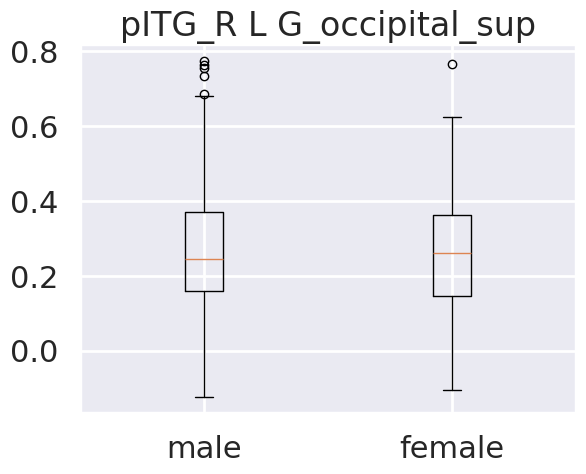

TtestResult(statistic=0.9629541940992754, pvalue=0.3360946577181738, df=444.0)
male mean : 0.27473477594409096
male std : 0.1715658534845672
female mean : 0.2598406360759292
female std : 0.15408335303503207
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [106]:
rois = ["pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_pITG_R)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()


acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## planumtemp_L validation accuracy

Validation accuracy
The mean accuracy : 0.6838375000000001
The standard deviation of the accuracy : 0.030617757317245742
The lower boundry of the confidance interval of the accuracy : 0.6238266956581985
The upper boundry of the confidance interval of the accuracy : 0.7438483043418017

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            48.0486  13.9514
Homme            21.4588  28.5412
Mean sensitivity : 0.692186413422034 Std sensitivity : 0.02910115488706826
Mean specificity : 0.6726303933829149 Std specificity : 0.04117240802243795

Testing accuracy
     coefficient          seed                       labels
60      0.285785  planumtemp_L  L S_oc-temp_med_and_Lingual
66      0.214379  planumtemp_L              L S_postcentral
108     0.189177  planumtemp_L      R G_temp_sup-Plan_polar
20      0.177437  planumtemp_L      L G_oc-temp_lat-fusifor
99      0.169222  planumtemp_L      R G_pariet_inf-Supramar
32      0.146572  planu

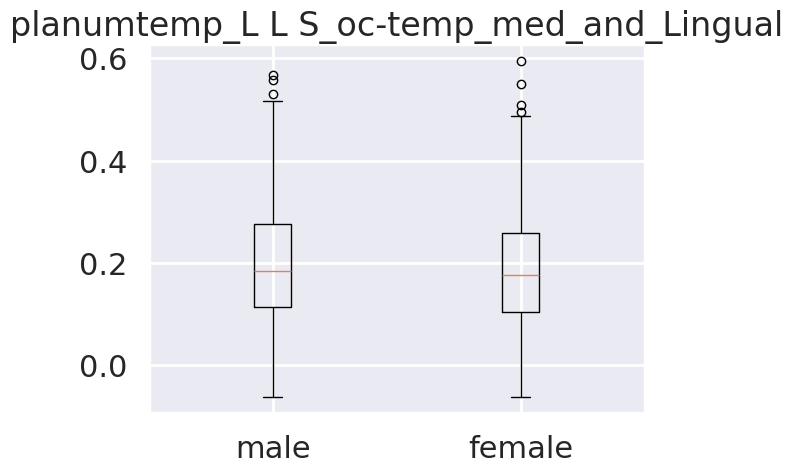

TtestResult(statistic=-0.018955201538938444, pvalue=0.9848853579000842, df=444.0)
male mean : 0.19560349765772725
male std : 0.11553457722911402
female mean : 0.1958168242159292
female std : 0.12143299330378049


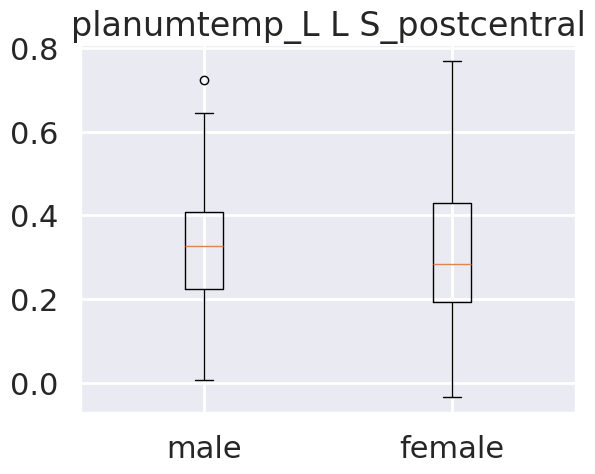

TtestResult(statistic=0.99881382874437, pvalue=0.31842891167423903, df=444.0)
male mean : 0.3188243096168182
male std : 0.13826779812472206
female mean : 0.30463629516946905
female std : 0.15994281470775304


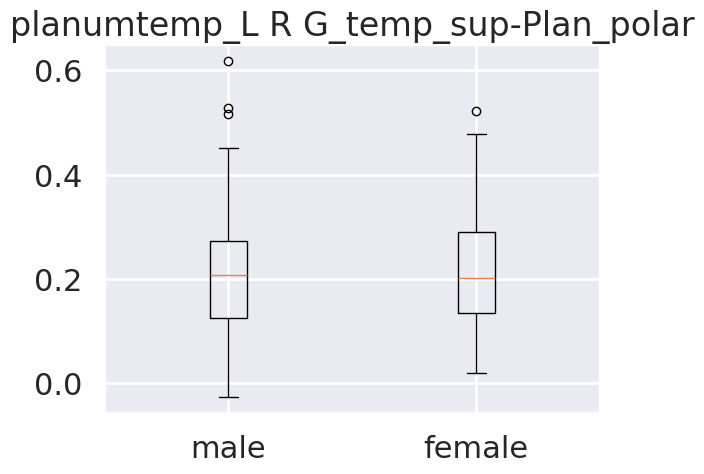

TtestResult(statistic=-0.49658022551965847, pvalue=0.6197308616234143, df=444.0)
male mean : 0.20703798182954544
male std : 0.10449484252167818
female mean : 0.21192919504867258
female std : 0.10304884232248941


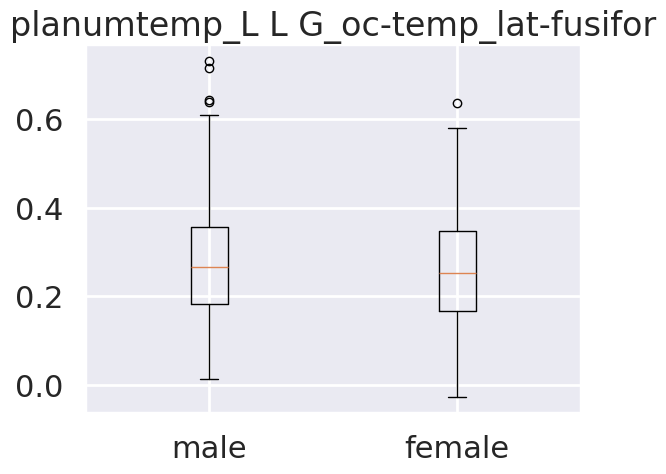

TtestResult(statistic=0.8312145629057236, pvalue=0.40629920488268956, df=444.0)
male mean : 0.27652223178636365
male std : 0.1299933971537437
female mean : 0.26641974534955754
female std : 0.12610447250617232


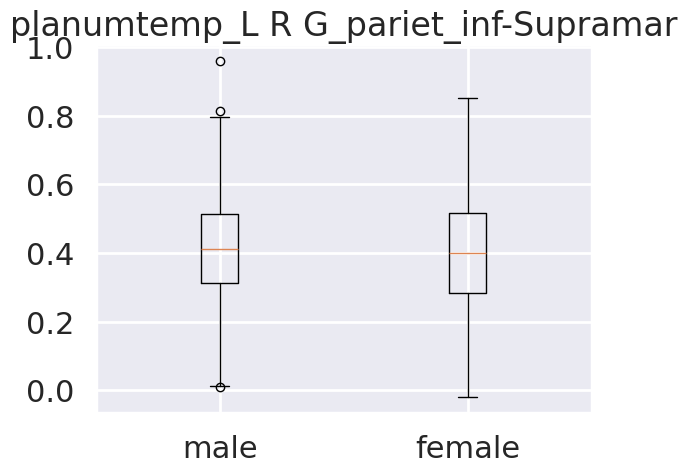

TtestResult(statistic=0.8112014664379938, pvalue=0.41768461521470845, df=444.0)
male mean : 0.4108449056727273
male std : 0.15872014519247643
female mean : 0.3983951438761062
female std : 0.1645088319088511


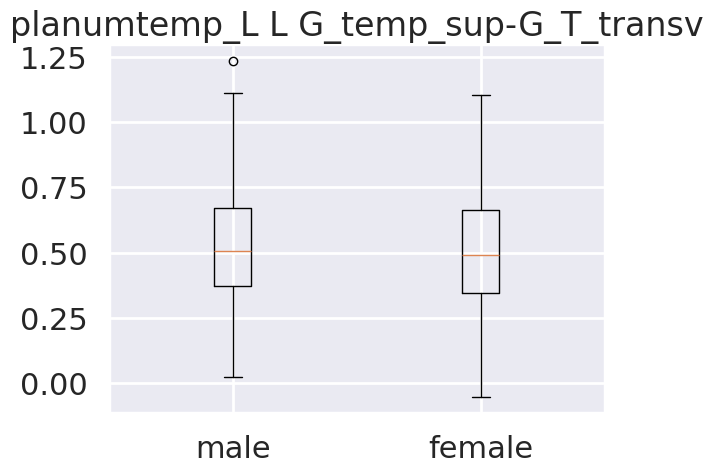

TtestResult(statistic=1.112502821549467, pvalue=0.26652399289422374, df=444.0)
male mean : 0.52790794775
male std : 0.2078075699697275
female mean : 0.5056785098318585
female std : 0.213085862485


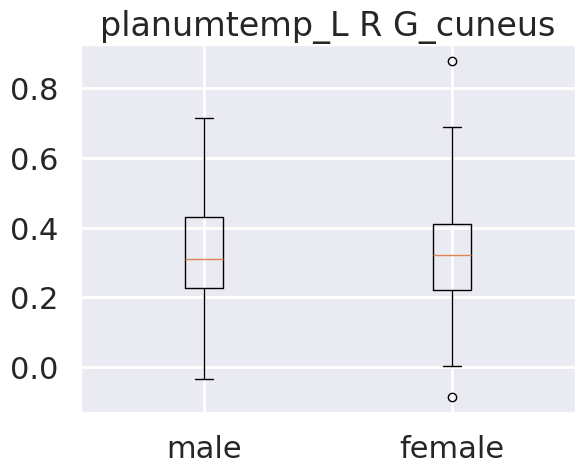

TtestResult(statistic=0.7406679099915333, pvalue=0.45928632702230665, df=444.0)
male mean : 0.3297348220481818
male std : 0.14929272325484488
female mean : 0.3191850437307964
female std : 0.1507875843231448


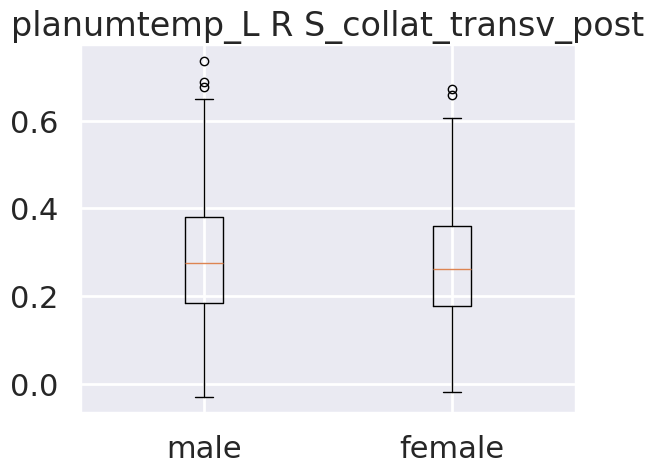

TtestResult(statistic=0.8630585561703593, pvalue=0.3885712180953744, df=444.0)
male mean : 0.28564585282045457
male std : 0.14625196444401473
female mean : 0.2739917209026549
female std : 0.13824941894914097


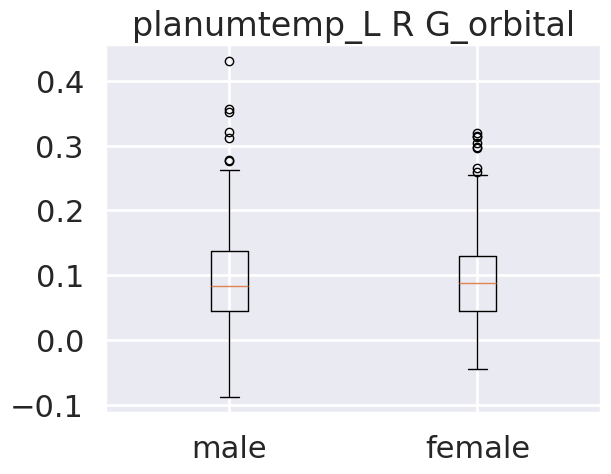

TtestResult(statistic=0.4833481967534641, pvalue=0.6290867887373555, df=444.0)
male mean : 0.09916828843359089
male std : 0.08204278142404257
female mean : 0.09560403915752211
female std : 0.07319149600450889


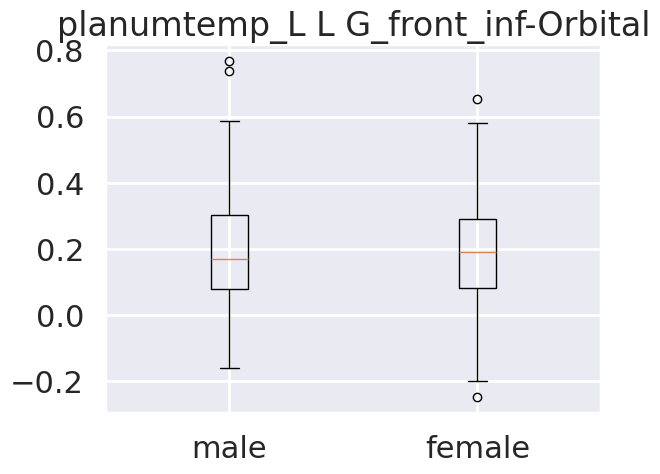

TtestResult(statistic=0.09720648324447106, pvalue=0.922606282865601, df=444.0)
male mean : 0.1958100565231818
male std : 0.16414401332641348
female mean : 0.19434243005460178
female std : 0.15393597212331298
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [107]:
rois = ["planumtemp_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_L)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## planumtemp_R validation accuracy

Validation accuracy
The mean accuracy : 0.6838366071428571
The standard deviation of the accuracy : 0.029771067814148736
The lower boundry of the confidance interval of the accuracy : 0.6254853142271256
The upper boundry of the confidance interval of the accuracy : 0.7421879000585886

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            42.7696  19.2304
Homme            16.1799  33.8201
Mean sensitivity : 0.7264799844052217 Std sensitivity : 0.03144984209708888
Mean specificity : 0.6385426848610832 Std specificity : 0.03423834160899033

Testing accuracy
     coefficient          seed                       labels
72      0.223593  planumtemp_R             L S_temporal_sup
60      0.222028  planumtemp_R  L S_oc-temp_med_and_Lingual
47      0.216804  planumtemp_R      L S_circular_insula_inf
108     0.211511  planumtemp_R      R G_temp_sup-Plan_polar
121     0.186898  planumtemp_R      R S_circular_insula_inf
145     0.171646  plan

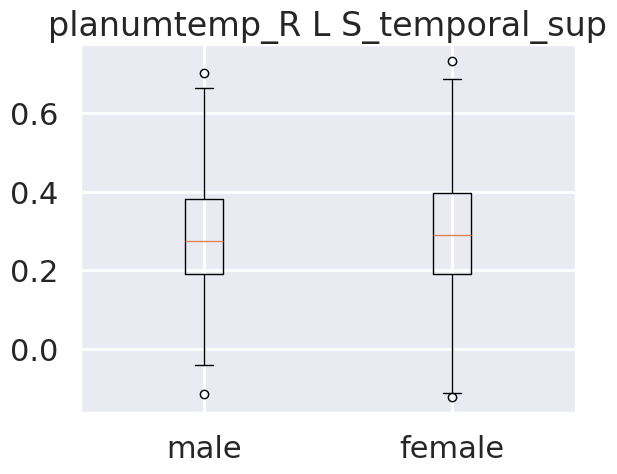

TtestResult(statistic=-0.5623665391173003, pvalue=0.5741501181938363, df=444.0)
male mean : 0.28790433803
male std : 0.14422700261098734
female mean : 0.295930255649115
female std : 0.1560759244227015


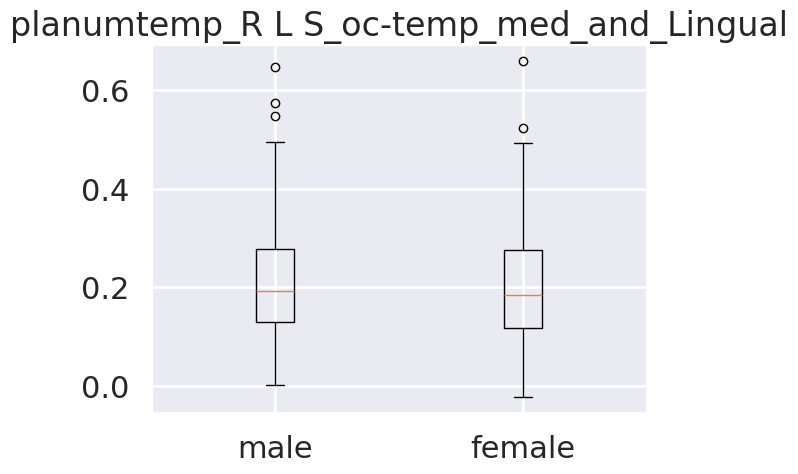

TtestResult(statistic=0.6303705603460131, pvalue=0.5287764652343739, df=444.0)
male mean : 0.21181543478699996
male std : 0.11171300472933252
female mean : 0.20492180302964605
female std : 0.11850702663759047


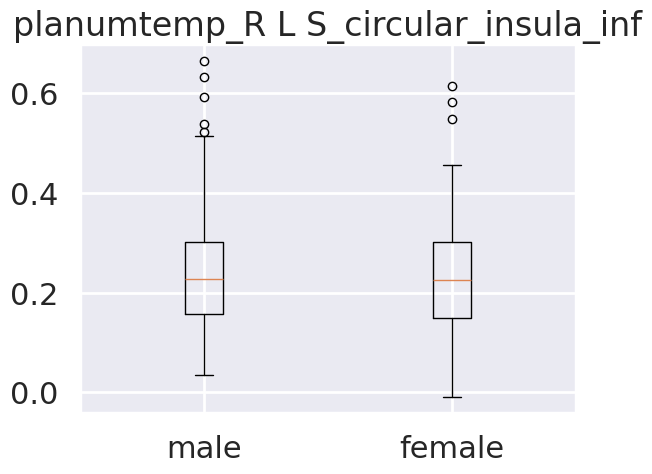

TtestResult(statistic=0.5700788027363477, pvalue=0.5689125960106347, df=444.0)
male mean : 0.23815464425000002
male std : 0.10999603167888458
female mean : 0.23228223751150442
female std : 0.10706043011814263


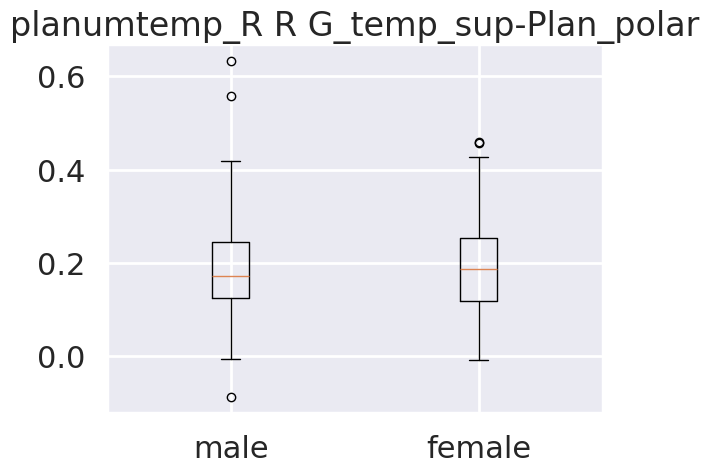

TtestResult(statistic=-0.7584824776565335, pvalue=0.44856462250649287, df=444.0)
male mean : 0.18800677794090911
male std : 0.0934470563869033
female mean : 0.19487283607964603
female std : 0.09719359451502213


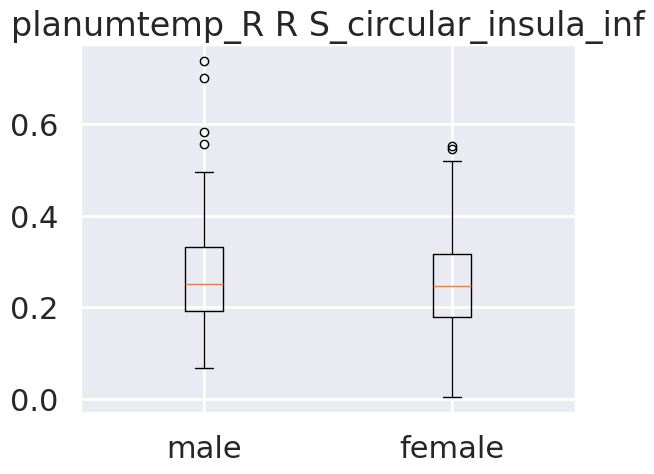

TtestResult(statistic=1.4058797870707365, pvalue=0.16045922476847255, df=444.0)
male mean : 0.26404327851363635
male std : 0.10784071039977033
female mean : 0.2500453904141593
female std : 0.10193681016282065


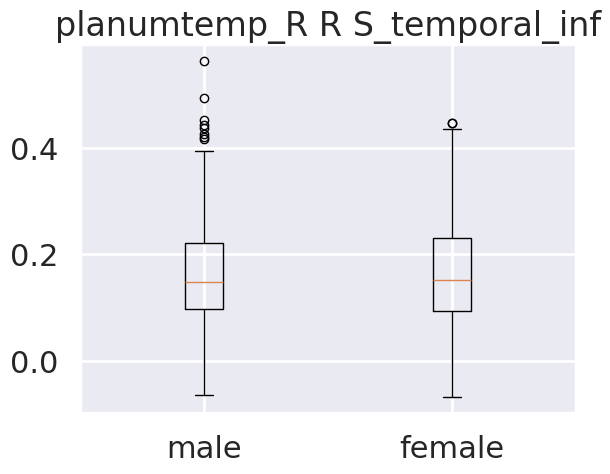

TtestResult(statistic=0.15190272589316534, pvalue=0.8793326560145229, df=444.0)
male mean : 0.16739266304727274
male std : 0.10256577624573711
female mean : 0.16591189901902653
female std : 0.10281745624533253


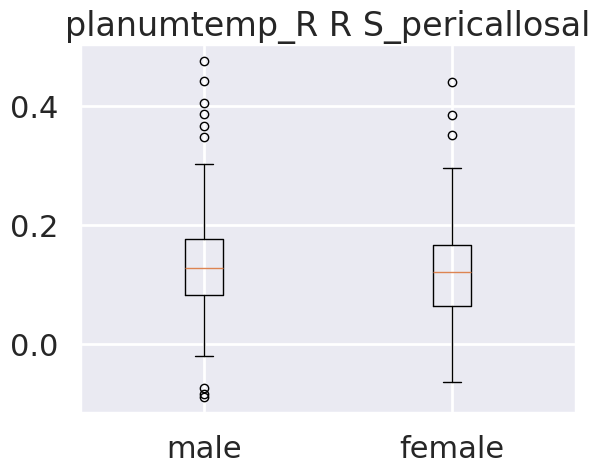

TtestResult(statistic=1.6707122700237407, pvalue=0.09548321340293443, df=444.0)
male mean : 0.13451138929909093
male std : 0.08431946209685855
female mean : 0.12144959410796462
female std : 0.08040941078395282


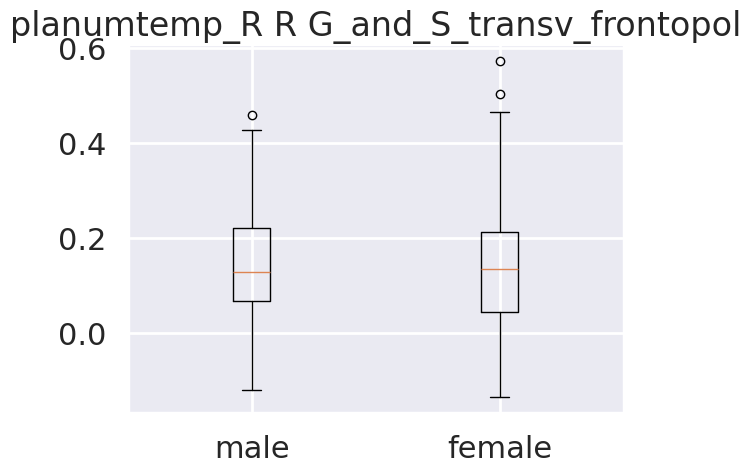

TtestResult(statistic=0.4243595305785367, pvalue=0.671509170134305, df=444.0)
male mean : 0.14278584594363636
male std : 0.11486733577190758
female mean : 0.13785455500876106
female std : 0.12934739592185884


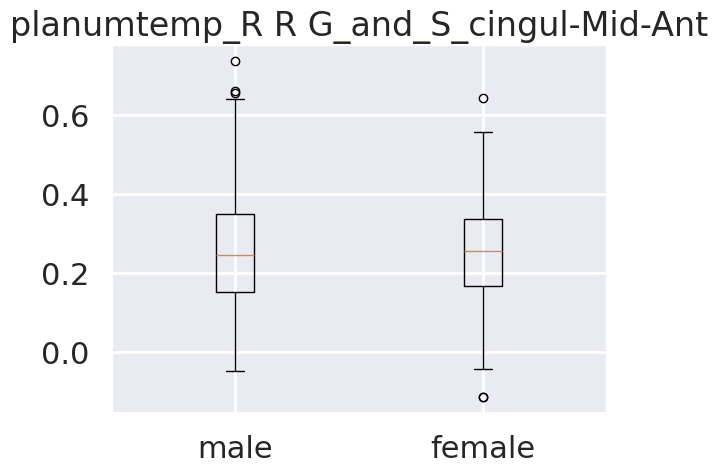

TtestResult(statistic=0.46253844238415165, pvalue=0.6439218303791144, df=444.0)
male mean : 0.2609372266636364
male std : 0.13749027519081208
female mean : 0.2550966605778761
female std : 0.12852686659757082


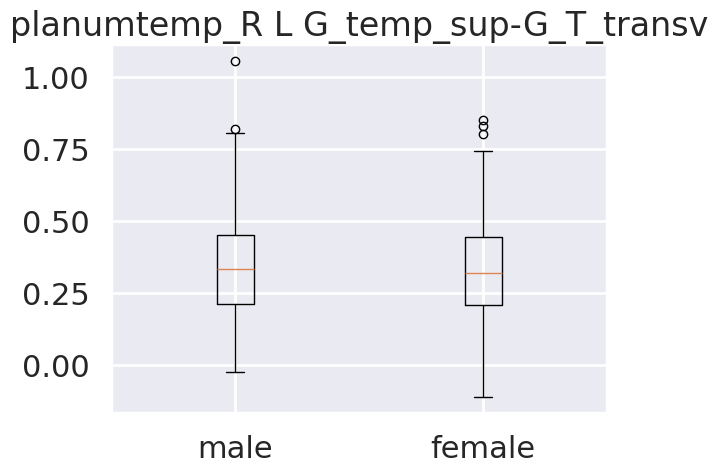

TtestResult(statistic=0.6378748366723407, pvalue=0.5238839830081853, df=444.0)
male mean : 0.34082361481499995
male std : 0.17402245266179422
female mean : 0.330362195261062
female std : 0.1715491335036446
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [108]:
rois = ["planumtemp_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_planumtemp_R)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## all left validation accuracy

Validation accuracy
The mean accuracy : 0.75559375
The standard deviation of the accuracy : 0.026942987316356307
The lower boundry of the confidance interval of the accuracy : 0.7027854948599416
The upper boundry of the confidance interval of the accuracy : 0.8084020051400583

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            47.7919  14.2081
Homme            13.1654  36.8346
Mean sensitivity : 0.7850700083745575 Std sensitivity : 0.030690791591861763
Mean specificity : 0.7226240457361631 Std specificity : 0.032920324944387444

Testing accuracy
     coefficient          seed                       labels
53      0.123777       opIFG_L                L S_front_sup
98      0.113710       opIFG_L       R G_pariet_inf-Angular
351     0.105832        aMTG_L  L S_intrapariet_and_P_trans
421     0.105135        aMTG_L                R S_front_inf
322     0.103736        aMTG_L             L G_parietal_sup
305     0.100285        aMTG

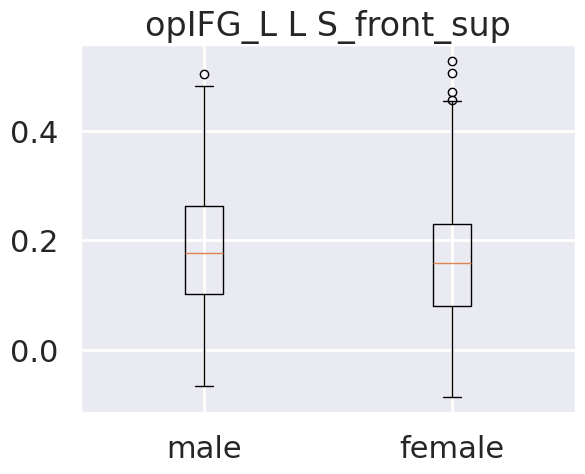

TtestResult(statistic=1.8386086382774387, pvalue=0.06664048715484525, df=444.0)
male mean : 0.18354724924686366
male std : 0.11555029853526483
female mean : 0.16325901403009732
female std : 0.11691880559681884


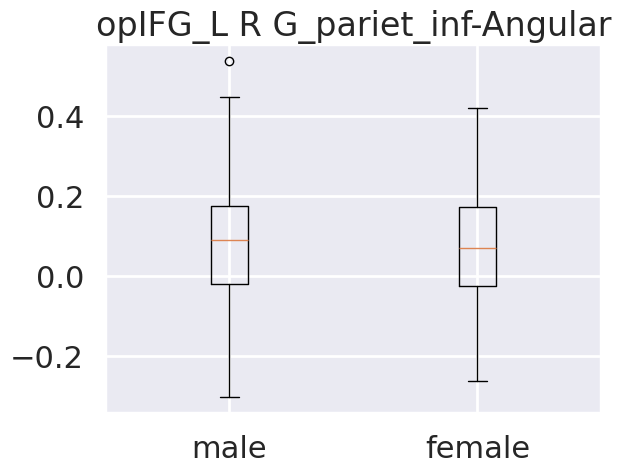

TtestResult(statistic=0.08591139105993699, pvalue=0.9315755833874969, df=444.0)
male mean : 0.07935426715545456
male std : 0.14282449297401265
female mean : 0.0782298258039823
female std : 0.13289471423540014


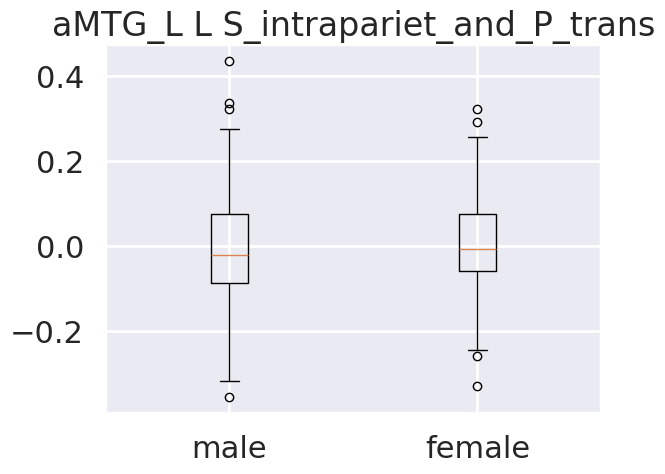

TtestResult(statistic=-0.5629449522849478, pvalue=0.5737565149961763, df=444.0)
male mean : -0.004352947120000001
male std : 0.11992515374089012
female mean : 0.0017103985353982307
female std : 0.10680532923333193


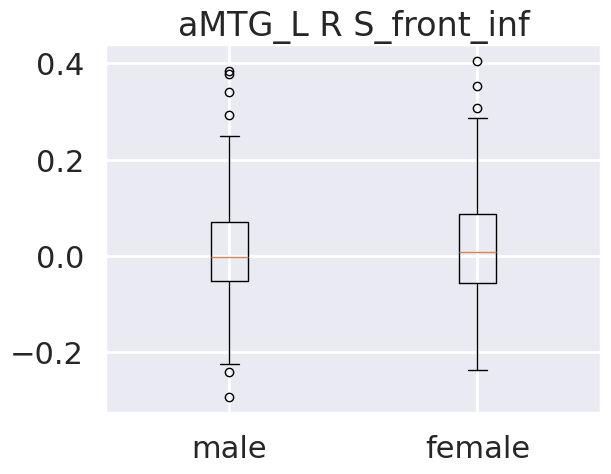

TtestResult(statistic=-1.0344019213226483, pvalue=0.3015113726056777, df=444.0)
male mean : 0.009040113515500001
male std : 0.11214850033551142
female mean : 0.020188220434349556
female std : 0.11487077247082961


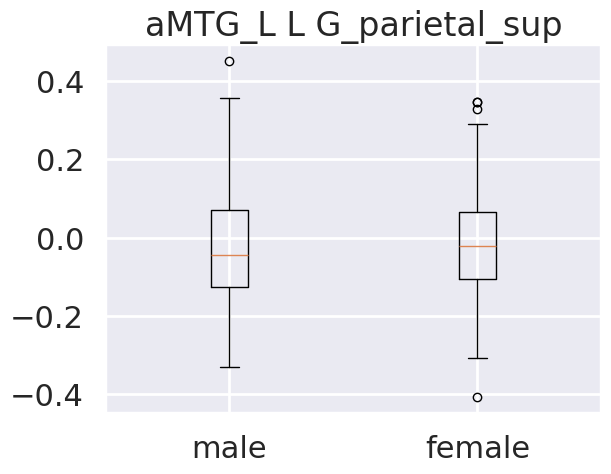

TtestResult(statistic=0.015908877647574173, pvalue=0.9873142336583003, df=444.0)
male mean : -0.019037156040909088
male std : 0.13980221990572175
female mean : -0.019240711578539817
female std : 0.12972998940269495


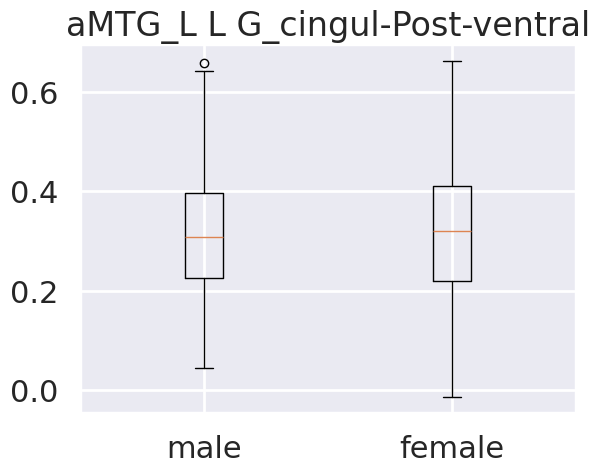

TtestResult(statistic=-0.2833432354183081, pvalue=0.7770458014163131, df=444.0)
male mean : 0.3156455165590909
male std : 0.12565269663262732
female mean : 0.3191625178451328
female std : 0.13555097899256496


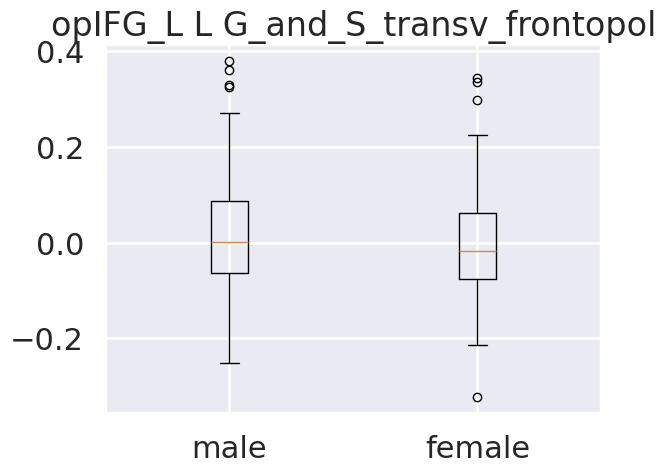

TtestResult(statistic=1.704073217878285, pvalue=0.08906705865566711, df=444.0)
male mean : 0.009279954413181817
male std : 0.11102207207238941
female mean : -0.00782524785345133
female std : 0.10034297686828818


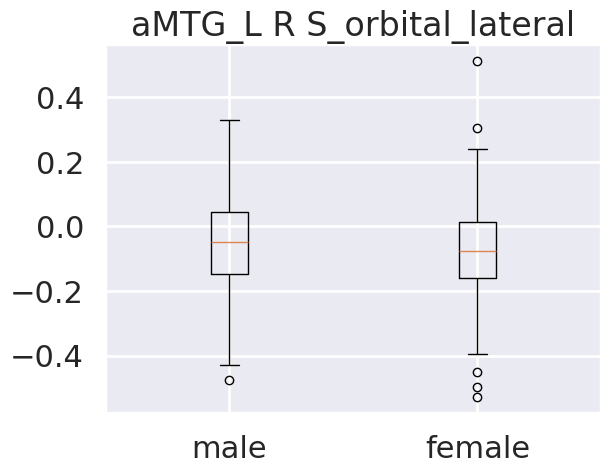

TtestResult(statistic=1.5922683491756897, pvalue=0.11203607391449234, df=444.0)
male mean : -0.05012122668031818
male std : 0.14338070010303233
female mean : -0.07177564318827433
female std : 0.14316029912268322


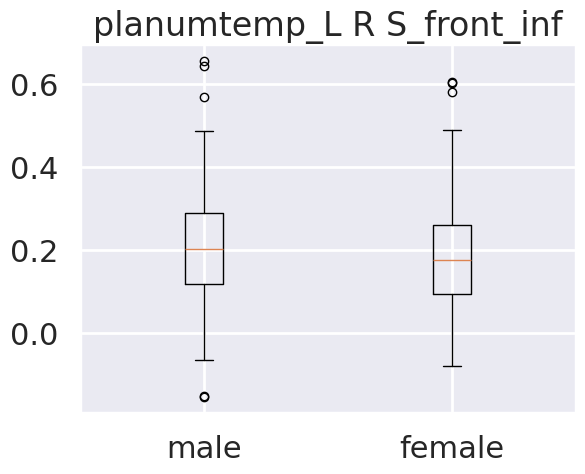

TtestResult(statistic=1.2098748966476487, pvalue=0.22697065486450205, df=444.0)
male mean : 0.20190828111636364
male std : 0.12683487723492423
female mean : 0.18740702922123895
female std : 0.1257102108596933


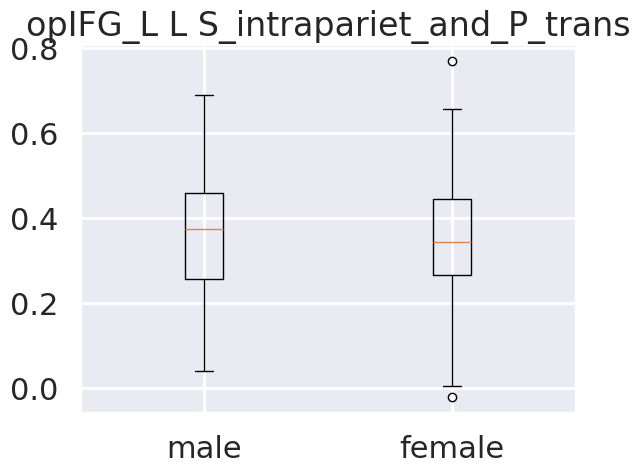

TtestResult(statistic=1.0378770541206963, pvalue=0.29989218232181175, df=444.0)
male mean : 0.36295411087727275
male std : 0.1438394817603057
female mean : 0.34900000852964597
female std : 0.13946053903379269
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [109]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_left)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## all right validation accuracy

Validation accuracy
The mean accuracy : 0.7362330357142857
The standard deviation of the accuracy : 0.031829129146318316
The lower boundry of the confidance interval of the accuracy : 0.6738479425875018
The upper boundry of the confidance interval of the accuracy : 0.7986181288410695

Confusion matrix (mean) :
predicted class    Femme    Homme
actual class                     
Femme            45.7133  16.2867
Homme            13.2552  36.7448
Mean sensitivity : 0.7762417849899873 Std sensitivity : 0.03338493652086484
Mean specificity : 0.6944463175452116 Std specificity : 0.038964230378200966

Testing accuracy
     coefficient          seed                       labels
53      0.134322       opIFG_R                L S_front_sup
66      0.114011       opIFG_R              L S_postcentral
316     0.104480        aMTG_R      L G_oc-temp_lat-fusifor
55      0.103655       opIFG_R  L S_intrapariet_and_P_trans
421     0.103610        aMTG_R                R S_front_inf
379     0.094846     

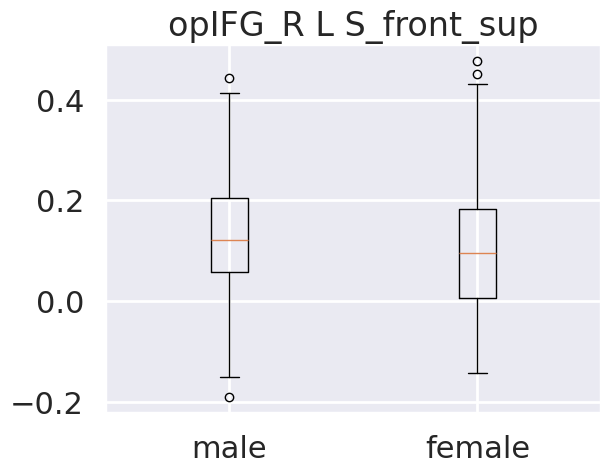

TtestResult(statistic=2.7712877132349694, pvalue=0.005818046217020924, df=444.0)
male mean : 0.13209549564272727
male std : 0.10837928174509652
female mean : 0.10247618119331857
female std : 0.11655067775022346


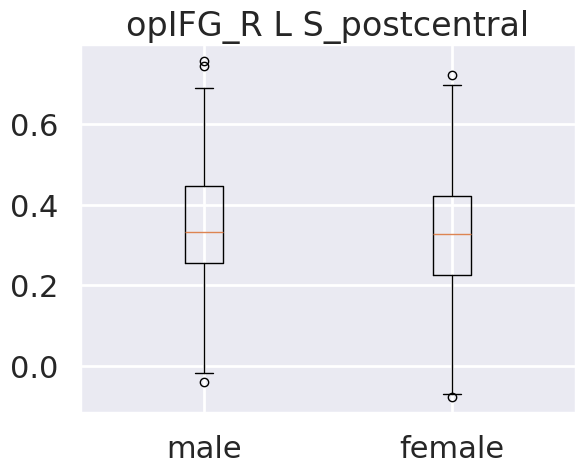

TtestResult(statistic=0.9151987861558548, pvalue=0.36058404718144454, df=444.0)
male mean : 0.3419503766181818
male std : 0.1373298867108125
female mean : 0.3299469699336283
female std : 0.13898137989012707


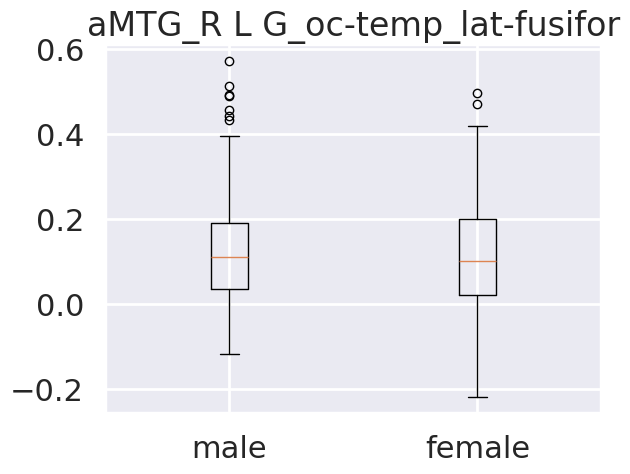

TtestResult(statistic=0.6618261297896938, pvalue=0.5084259884398799, df=444.0)
male mean : 0.1251803556624091
male std : 0.12416500737231072
female mean : 0.11723795153130832
female std : 0.12858531808264867


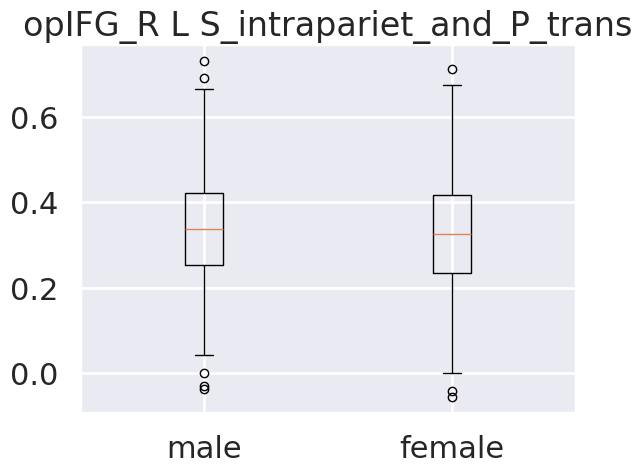

TtestResult(statistic=0.886164060317955, pvalue=0.3760088304470828, df=444.0)
male mean : 0.33837701796454545
male std : 0.1335731016008213
female mean : 0.3271137672234513
female std : 0.1342121309439049


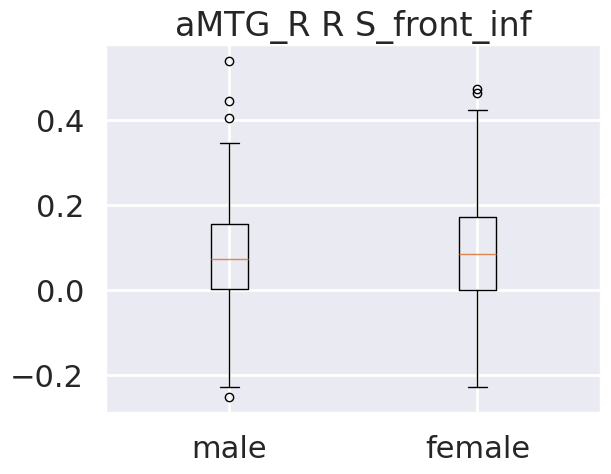

TtestResult(statistic=-0.8659935726660029, pvalue=0.38696138721745843, df=444.0)
male mean : 0.07918866444727271
male std : 0.12369684504008881
female mean : 0.08950797622964603
female std : 0.12729516350055226


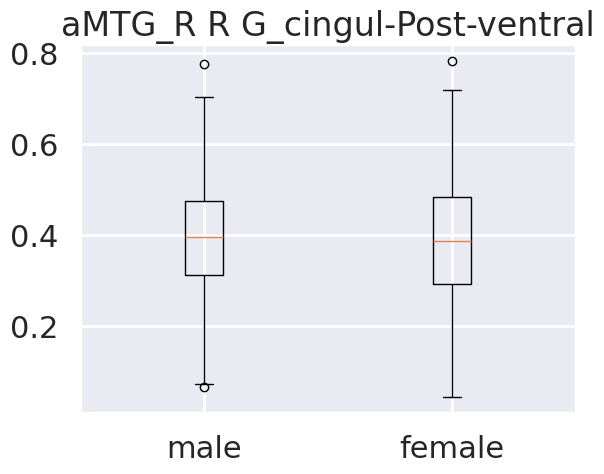

TtestResult(statistic=0.5399522640043164, pvalue=0.5895006586634257, df=444.0)
male mean : 0.38983515674545455
male std : 0.13128119707638264
female mean : 0.38286670389823
female std : 0.14036009370424207


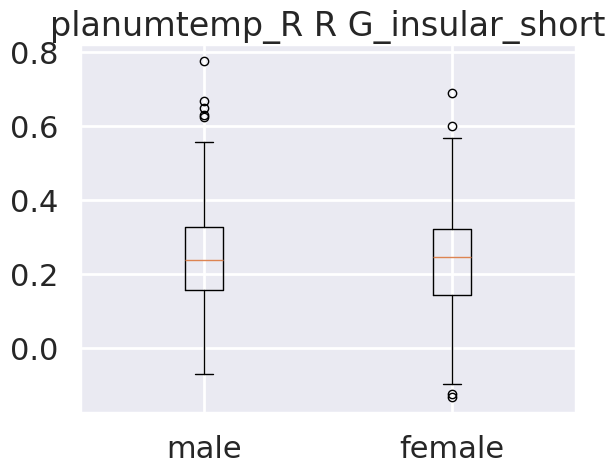

TtestResult(statistic=0.8609970021424133, pvalue=0.3897044052210804, df=444.0)
male mean : 0.2527016079177273
male std : 0.14417879050292717
female mean : 0.24125793585530975
female std : 0.13584668250426662


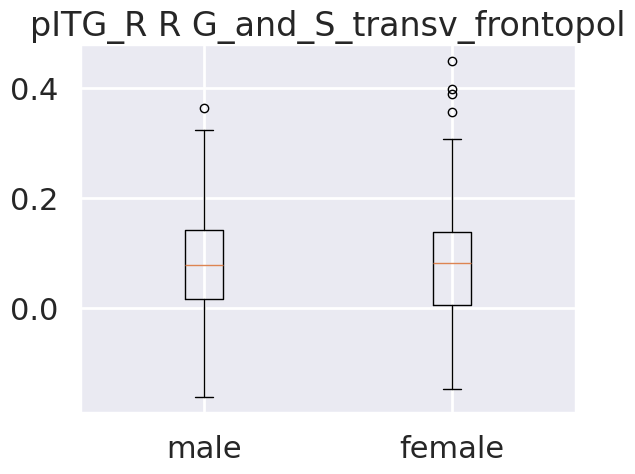

TtestResult(statistic=0.45150982516766125, pvalue=0.6518426041743509, df=444.0)
male mean : 0.08221655689954546
male std : 0.09251453858724128
female mean : 0.07808570323274336
female std : 0.10000274206737905


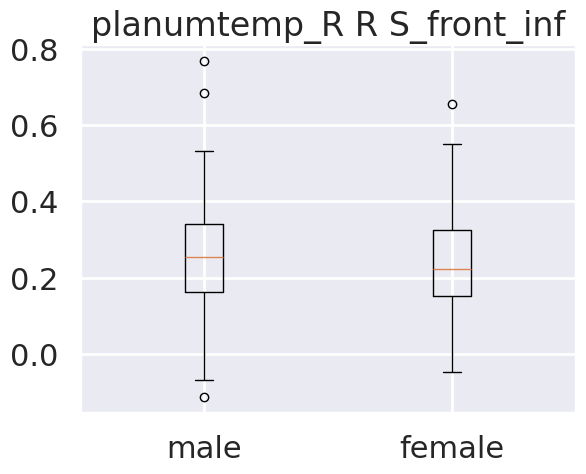

TtestResult(statistic=1.0229026635703389, pvalue=0.3069108647841219, df=444.0)
male mean : 0.2490507583409091
male std : 0.1253685705981462
female mean : 0.23684191620796463
female std : 0.12609419293424395


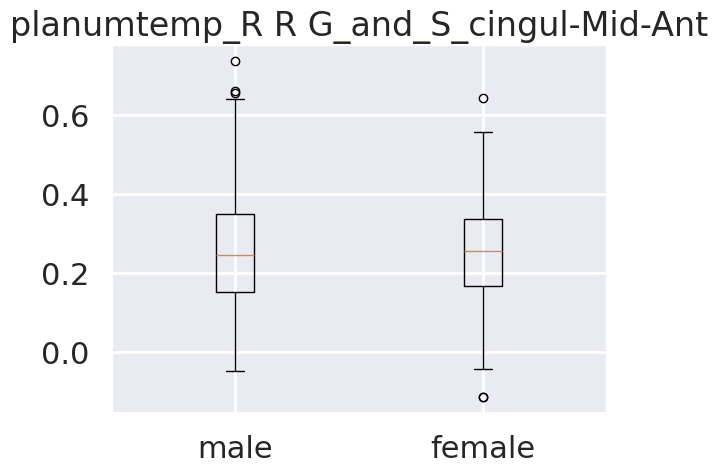

TtestResult(statistic=0.46253844238415165, pvalue=0.6439218303791144, df=444.0)
male mean : 0.2609372266636364
male std : 0.13749027519081208
female mean : 0.2550966605778761
female std : 0.12852686659757082
Empty DataFrame
Columns: [Region, Men, Women, P value]
Index: []


In [110]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
moyenne, scoresZ, pvalue, data_results = compute_results(results_path_all_right)


pdList = []
pdList.extend(data_results["confusion_matrix_validation"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()

acc_vald = np.asarray(data_results["acc_validation"])
moy = np.mean(acc_vald)
se = np.std(acc_vald)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)
print("Validation accuracy")
print("The mean accuracy : " + str(moy))
print("The standard deviation of the accuracy : " + str(se))
print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
print("\nConfusion matrix (mean) :")
print(mean_confusion)
sensitivity = data_results["confusion_matrix_validation"].apply(lambda x: x["Femme"][0] / (x["Femme"][0] + x["Femme"][1]))
specificity = data_results["confusion_matrix_validation"].apply(lambda x: x['Homme'][1] / (x["Homme"][1] + x["Homme"][0]))
print("Mean sensitivity : " + str(sensitivity.mean()) + " Std sensitivity : " + str(sensitivity.std()))
print("Mean specificity : " + str(specificity.mean()) + " Std specificity : " + str(specificity.std()))

print("\nTesting accuracy")
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs, data, df_boot)

## Test classification feature by feature on an independent set

In [54]:
# 53      0.071670       opIFG_L                L S_front_sup
# 98      0.068736       opIFG_L       R G_pariet_inf-Angular
# 305     0.067573        aMTG_L      L G_cingul-Post-ventral
# 4       0.062202       opIFG_L   L G_and_S_transv_frontopol
# 351     0.061009        aMTG_L  L S_intrapariet_and_P_trans
# 379     0.055271        aMTG_L      R G_cingul-Post-ventral
# 421     0.054923        aMTG_L                R S_front_inf
# 189     0.053367  planumtemp_L             L Pole_occipital
# 301     0.052666        aMTG_L         L G_and_S_cingul-Ant
# 431     0.051921        aMTG_L          R S_orbital_lateral

# the best feature (seed and their region)
seeds = ["opIFG_L", "opIFG_L", "aMTG_L", "opIFG_L", "aMTG_L", "aMTG_L" , "aMTG_L", "planumtemp_L", "aMTG_L", "aMTG_L"]
regions = ["L_S_front_sup", 
          "R_G_pariet_inf-Angular", 
          "L_G_cingul-Post-ventral", 
          "L_G_and_S_transv_frontopol", 
          "L_S_intrapariet_and_P_trans", 
          "R_G_cingul-Post-ventral",
           "R_S_front_inf",
         "L_Pole_occipital",
         "L_G_and_S_cingul-Ant",
         "R_S_orbital_lateral"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_fisherz/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__fisherz.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_train.csv")

x = []
y = []
for i in range(0, 1):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    signal = loaded[seeds[i]+"__"+regions[i]]
    for subject in Final_df["Subject"]:
        sub_sex = Final_df.loc[Final_df["Subject"] == subject]["Gender"].values[0]
        value = loaded.loc[loaded["Unnamed: 0"] == "sub-"+str(subject)][seeds[i]+"__"+regions[i]].values[0]
        x.append(value)
        y.append(sub_sex)
    x = np.asarray(x)
    x = x.reshape(-1,1)
    print("Testing : "+seeds[i]+" "+regions[i])
    model = machine_learning(x,y)
    print("\n")
    x = []
    y = []
        

Testing : opIFG_L L_S_front_sup
train: 356 test: 90
[array([0.61111111, 0.66666667, 0.44444444, 0.77777778, 0.72222222,
       0.5       , 0.72222222, 0.72222222, 0.61111111, 0.55555556,
       0.55555556, 0.66666667, 0.77777778, 0.66666667, 0.55555556,
       0.66666667, 0.58823529, 0.88235294, 0.70588235, 0.64705882])]
predicted class  Femme  Homme
actual class                 
Femme               27     19
Homme               11     33
accuracy test (r2) = 0.6666666666666666
accuracy train (r2) = 0.651685393258427




/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/cderoy/elmvenv/lib/python3

## Validation set

In [55]:
seeds = ["opIFG_L", "opIFG_L", "aMTG_L", "opIFG_L", "aMTG_L", "aMTG_L" , "aMTG_L", "planumtemp_L", "aMTG_L", "aMTG_L"]
regions = ["L_S_front_sup", 
          "R_G_pariet_inf-Angular", 
          "L_G_cingul-Post-ventral", 
          "L_G_and_S_transv_frontopol", 
          "L_S_intrapariet_and_P_trans", 
          "R_G_cingul-Post-ventral",
           "R_S_front_inf",
         "L_Pole_occipital",
         "L_G_and_S_cingul-Ant",
         "R_S_orbital_lateral"]

file_path = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_2024/atlas_means/destrieux_fisherz/seed-{seed_name}_atlas-destrieux_mean-all4_gmcorrected__fisherz.csv"
Final_df = pd.read_csv("/data/brambati/dataset/HCP/derivatives/training_sex_diff/HCP_matched_age_educ_validation.csv")

for i in range(0, 1):
    file = file_path.format(seed_name=seeds[i])
    loaded = pd.read_csv(file_path.format(seed_name=seeds[i]))
    Final_df["Unnamed: 0"] = Final_df["Subject"].apply(lambda x : "sub-"+str(x))
    loaded = loaded[loaded["Unnamed: 0"].isin(Final_df["Unnamed: 0"])]
    signal = loaded[seeds[i]+"__"+regions[i]]
    acc = 0
    for index, row in loaded.iterrows():
        real = Final_df[Final_df["Unnamed: 0"] == row["Unnamed: 0"]]["Gender"].values[0]
        prediction = model["model"].predict([[row[seeds[i]+"__"+regions[i]]]])[0]
        if real == prediction:
            acc += 1
    print("Accuracy for the prediction on the validation set with the " +seeds[i]+"__"+regions[i]+" pair: " + str(acc/len(loaded)))

Accuracy for the prediction on the validation set with the opIFG_L__L_S_front_sup pair: 0.5714285714285714


## Mean AUC

In [66]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results_test_validation_2024-12-09" / "LinearSVC" / "seed-all_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

In [67]:
# auc test
auc = data_results["auc_test"]
auc_test = np.asarray(auc)
moy = np.mean(auc_test)
se = np.std(auc_test)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)

print("The mean AUC : " + str(moy))
print("The standard deviation of the AUC : " + str(se))
print("The lower boundry of the confidance interval of the AUC : " + str(lower))
print("The upper boundry of the confidance interval of the AUC : " + str(upper))

The mean AUC : 0.8192131065851725
The standard deviation of the AUC : 0.042228740586496394
The lower boundry of the confidance interval of the AUC : 0.7364447750356397
The upper boundry of the confidance interval of the AUC : 0.9019814381347054


In [68]:
# auc validation
auc = data_results["auc_validation"]
auc_test = np.asarray(auc)
moy = np.mean(auc_test)
se = np.std(auc_test)
lower = moy - (1.96 * se)
upper = moy + (1.96 * se)

print("The mean AUC : " + str(moy))
print("The standard deviation of the AUC : " + str(se))
print("The lower boundry of the confidance interval of the AUC : " + str(lower))
print("The upper boundry of the confidance interval of the AUC : " + str(upper))

The mean AUC : 0.6852270322580646
The standard deviation of the AUC : 0.030427522020568396
The lower boundry of the confidance interval of the AUC : 0.6255890890977506
The upper boundry of the confidance interval of the AUC : 0.7448649754183786


# Validation bootstrapping

In [62]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/results_test_validation_2024-12-09/LinearSVC/')
results_all_seeds = study_dir / "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_aMTG_L = study_dir /  "seed-aMTG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
results_opIFG_L = study_dir / "seed-opIFG_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"
resutls_planumtemp_L = study_dir / "seed-planumtemp_L_atlas-destrieux_mean-all4_gmcorrected_iteration-10000_LinearSVC.pkl"

In [63]:
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L)

In [65]:
# aMTG_L L_G_and_S_cingul_Ant
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L L_G_and_S_cingul_Ant")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L L_G_and_S_cingul_Ant
predicted class    Femme    Homme
actual class                     
Femme            38.2316   7.4062
Homme             8.7749  35.5873
Sensitivity : 0.8133258166423792
Specificity : 0.8277367509042065
mean Accuracy train : 0.9232578651685394
mean Accuracy test : 0.8202100000000002


In [18]:
# aMTG_L L_G_cingul_Postventral
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_L_G_cingul_Postventral)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L L_G_cingul_Postventral")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L L_G_cingul_Postventral
predicted class  Femme  Homme
actual class                 
Femme             28.0   18.0
Homme             21.0   23.0
Sensitivity : 0.5714285714285714
Specificity : 0.5609756097560976
mean Accuracy train : 0.5421348314606743
mean Accuracy test : 0.5666666666666665


In [19]:
# aMTG_L L_S_intrapariet_and_P_trans
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_L_S_intrapariet_and_P_trans)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L L_S_intrapariet_and_P_trans")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L L_S_intrapariet_and_P_trans
predicted class  Femme  Homme
actual class                 
Femme             35.0   11.0
Homme             28.0   16.0
Sensitivity : 0.5555555555555556
Specificity : 0.5925925925925926
mean Accuracy train : 0.547752808988764
mean Accuracy test : 0.5666666666666665


In [20]:
# aMTG_L R_G_cingul_Post_ventral
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_R_G_cingul_Post_ventral)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L R_G_cingul_Post_ventral")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L R_G_cingul_Post_ventral
predicted class  Femme  Homme
actual class                 
Femme             26.0   20.0
Homme             23.0   21.0
Sensitivity : 0.5306122448979592
Specificity : 0.5121951219512195
mean Accuracy train : 0.5224719101123598
mean Accuracy test : 0.5222222222222223


In [21]:
# aMTG_L R_S_front_inf
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_R_S_front_inf)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L R_S_front_inf")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L R_S_front_inf
predicted class   Femme   Homme
actual class                   
Femme            23.003  22.997
Homme            26.000  18.000
Sensitivity : 0.4694202395771687
Specificity : 0.4390565163304632
mean Accuracy train : 0.539325842696629
mean Accuracy test : 0.45558888888888893


In [22]:
# aMTG_L R_S_orbital_lateral
moyenne, scoresZ, pvalue, data_results = compute_results(results_aMTG_L_R_S_orbital_lateral)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("aMTG_L R_S_orbital_lateral")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

aMTG_L R_S_orbital_lateral
predicted class  Femme  Homme
actual class                 
Femme             26.0   20.0
Homme             28.0   16.0
Sensitivity : 0.48148148148148145
Specificity : 0.4444444444444444
mean Accuracy train : 0.5140449438202248
mean Accuracy test : 0.4666666666666667


In [23]:
# opIFG_L L_G_and_S_transv_frontopol
moyenne, scoresZ, pvalue, data_results = compute_results(results_opIFG_L_L_G_and_S_transv_frontopol)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("opIFG_L L_G_and_S_transv_frontopol")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

opIFG_L L_G_and_S_transv_frontopol
predicted class  Femme  Homme
actual class                 
Femme             26.0   20.0
Homme             15.0   29.0
Sensitivity : 0.6341463414634146
Specificity : 0.5918367346938775
mean Accuracy train : 0.5786682584269663
mean Accuracy test : 0.6111111111111109


In [24]:
# opIFG_L L_S_front_sup
moyenne, scoresZ, pvalue, data_results = compute_results(results_opIFG_L_L_S_front_sup)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("results_opIFG_L_L_S_front_sup")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

results_opIFG_L_L_S_front_sup
predicted class  Femme  Homme
actual class                 
Femme             27.0   19.0
Homme             11.0   33.0
Sensitivity : 0.7105263157894737
Specificity : 0.6346153846153846
mean Accuracy train : 0.6516853932584271
mean Accuracy test : 0.6666666666666665


In [25]:
# opIFG_L R_G_pariet_inf_Angular
moyenne, scoresZ, pvalue, data_results = compute_results(results_opIFG_L_R_G_pariet_inf_Angular)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("opIFG_L R_G_pariet_inf_Angular")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

opIFG_L R_G_pariet_inf_Angular
predicted class  Femme  Homme
actual class                 
Femme             27.0   19.0
Homme             13.0   31.0
Sensitivity : 0.675
Specificity : 0.62
mean Accuracy train : 0.6320224719101122
mean Accuracy test : 0.6444444444444445


In [26]:
# planumtemp_L L_Pole_occipital
moyenne, scoresZ, pvalue, data_results = compute_results(resutls_planumtemp_L_L_Pole_occipital)
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion = mean_confusion.mean()
print("planumtemp_L L_Pole_occipital")
sensitivity, specificity = sensitivity_specificity(data_results["confusion_matrix"])
print("Sensitivity : " + str(sensitivity))
print("Specificity : " + str(specificity))
print("mean Accuracy train : " + str(data_results["acc_train"].mean()))
print("mean Accuracy test : " + str(data_results["acc_test"].mean()))

planumtemp_L L_Pole_occipital
predicted class  Femme  Homme
actual class                 
Femme             27.0   19.0
Homme             19.0   25.0
Sensitivity : 0.5869565217391305
Specificity : 0.5681818181818182
mean Accuracy train : 0.539325842696629
mean Accuracy test : 0.5777777777777775
